# Import libraries and define functions

In [1]:
#Import libraries necessary to do the analysis


import warnings
warnings.filterwarnings("ignore")


import km3io as kio
import km3db
import km3pipe as kp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
from progressbar import ProgressBar
import pickle
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from numpy import ones,vstack
from numpy.linalg import lstsq



import km3io
import numba

import awkward as ak
from numba import njit

from thepipe import Module
from km3pipe.dataclasses import Table
from km3pipe.hardware import Detector
from km3pipe.logger import get_logger
from km3pipe.constants import (
    C_WATER,
    SIN_CHERENKOV,
    TAN_CHERENKOV,
    V_LIGHT_WATER,
    C_LIGHT,
)
import km3pipe.math
import km3pipe.extras

import os
from pandas.compat.pickle_compat import _class_locations_map
from time import sleep
from tqdm import tqdm

_class_locations_map.update({
    ('pandas.core.internals.managers', 'BlockManager'): ('pandas.core.internals', 'BlockManager')
})


In [2]:
def DOM():
    """Reads DOM file and store list of positions, ids and dictionary"""


    #Read DOMS information on positions and id
    det = kp.hardware.Detector('/home/stefanescu/internship/muonstopwork/KM3NeT_00000049_20200625.detx')
    
    #Store position of DOMS in a np.array ([xxx][yyyy][zzzz])
    dom_x = []
    dom_y = []
    dom_z = []
    dom_id = []

    for dom,pos in det.dom_positions.items():
        dom_x.append(pos[0])
        dom_y.append(pos[1])
        dom_z.append(pos[2])
        dom_id.append(dom)
    
    dom_positions = np.array((dom_x,dom_y,dom_z))

    #Transpose the arrays to make a for loop for each distance
    dom_positions_bis = dom_positions.T
    

    #create dictionary of id vs index
    dict_id = {}
    for i in range(len(dom_positions_bis)):
        dict_id[i] = dom_id[i]

    #create dictionary of index vs id
    dict_index = {}
    for i in range(len(dom_positions_bis)):
        dict_index[dom_id[i]] = i

        
    return dom_positions_bis, dict_id, dict_index
    
dom_positions, dict_id, dict_index = DOM()

def plotdom():
    """Plot a 3D plot of DOM"""
    
    #3D plot stop positions cuts_bis

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
    
    ax.set_title("DOM Positions")
    ax.set_xlim([430,490])
    ax.set_ylim([550,600])
    ax.set_zlim([0,250])
    
    return plt.show()

def linear(xmin1,ymin1,xmax1,ymax1):
    """Returns m and n for 2 points"""
    points = [(xmin1,ymin1),(xmax1,ymax1)]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, n = lstsq(A, y_coords)[0]
    #print("Line Solution is y = {m}x + {n}".format(m=m,n=n))
    return m, n

def VolumeCut(pos_stop_bis,zsup,zinf,yred,xred):
    """Returns boolean list for cut based on stop positions inside a given volume, plus cuts in each direction
    Returns also the stop positions as a list of coordinates"""

    #Compute cuts_volume
    cuts_volume = []    
    
    #Define limits of our volume, taking into account the cut in each direction
    y_lim = [564.9+yred,584.1-yred] #y limits
    z_lim = [30+zinf,192-zsup] #z limits
    
#     print("Ylim is:", y_lim)
#     print("Zlim is:", z_lim)

    #two vertices of x in the x-y plane
    xmin1 = 431+xred
    xmax1 = 441+xred
    ymin1 = y_lim[1]
    ymax1 = y_lim[0]
    
    xmin2 = 474-xred
    xmax2 = 484-xred
    ymin2 = y_lim[1]
    ymax2 = y_lim[0]
    
    #linear regressions for the two extremes of paralelepipoid
    m1, n1 = linear(xmin1,ymin1,xmax1,ymax1)
    m2, n2 = linear(xmin2,ymin2,xmax2,ymax2)
    
    #Loop over all events
    coordinates = []
    
    for i in range(len(pos_stop_bis)):   
        
        x,y,z = pos_stop_bis[i,0],pos_stop_bis[i,1],pos_stop_bis[i,2] #coordinates of points of the events
        
            
        if (z >= z_lim[0]) & (z <= z_lim[1]): #check if in z range
            
            if (y >= y_lim[0]) & (y <= y_lim[1]):  #check if in y range
                
                if (x >= xmax1) & (x <= xmin2): #check if x in the middle of the paralelepipoid, if so, point fall inside volume
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])
                    
                elif (x >= xmin1) & (x <= xmax1): #check if for first extreme, point falls inside the volume
                    y1 = m1*x+n1
                    if y > y1:
                        cuts_volume.append(True)
                        coordinates.append([x,y,z])
                    else:
                        cuts_volume.append(False)
                        
                elif (x >= xmin2) & (x <= xmax2): #check if for second extreme, point falls inside the volume
                    y2 = m2*x+n2
                    if y < y2:
                        cuts_volume.append(True)
                        coordinates.append([x,y,z])
                    else:
                        cuts_volume.append(False)
                    

                else:
                    cuts_volume.append(False)
            else:
                cuts_volume.append(False)
        else:
            cuts_volume.append(False)


    return cuts_volume, coordinates

def Stops(file,cuts,tracks):
    """Calculate stop postions of file, based on boolean list of cuts"""

    #Read file using kio
    f = kio.OfflineReader(file)
    
    #Array of initial position x, y and z coordinates for each event considering the cuts_2
    pos_start = [f.events.tracks.pos_x[tracks][cuts][:,0].__array__(),f.events.tracks.pos_y[tracks][cuts][:,0].__array__(),f.events.tracks.pos_z[tracks][cuts][:,0].__array__()] 

    #Add all positions together, array of arrays
    pos_start = np.stack(pos_start)
    
    #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
    trackLength = f.events.tracks.fitinf[tracks][cuts][:,0,10].__array__()
    
    #stop postion, as pos start + track
    pos_stop_x  = pos_start[0,:] + f.events.tracks.dir_x[tracks][cuts][:,0].__array__()*trackLength # for x
    pos_stop_y  = pos_start[1,:] + f.events.tracks.dir_y[tracks][cuts][:,0].__array__()*trackLength # for y
    pos_stop_z  = pos_start[2,:] + f.events.tracks.dir_z[tracks][cuts][:,0].__array__()*trackLength # for z

    #Add all positions together, array of arrays
    pos_stop = np.stack((pos_stop_x, pos_stop_y, pos_stop_z))

    #Transpose the array to make a for loop for each distance
    pos_stop_bis = pos_stop.T
    
    return pos_stop, pos_stop_bis, pos_start, trackLength
    
    
def geoinfo(f,haveTrk,cuts_2,cuts_volume, cuts_length = 0, complete = True):
    """For a given list of cut boolans lists, computes the strat, stop and track lenght positions"""
    
    
    if cuts_length == 0:
        #Array of initial position x, y and z coordinates for each event considering the cuts_2 and cuts_R_dom
        pos_start_f = [f.events.tracks.pos_x[haveTrk][cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_y[haveTrk][cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_z[haveTrk][cuts_2][cuts_volume][:,0].__array__()] 

        #Add all positions together, array of arrays
        pos_start_f = np.stack(pos_start_f)
    
        #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
        trackLength_f = f.events.tracks.fitinf[haveTrk][cuts_2][cuts_volume][:,0,10].__array__()
        
        if complete:
            #stop postion, as pos start + track
            pos_stop_x_f  = pos_start_f[0,:] + f.events.tracks.dir_x[haveTrk][cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for x
            pos_stop_y_f  = pos_start_f[1,:] + f.events.tracks.dir_y[haveTrk][cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for y
            pos_stop_z_f  = pos_start_f[2,:] + f.events.tracks.dir_z[haveTrk][cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for z

             #Add all positions together, array of arrays
            pos_stop_f = np.stack((pos_stop_x_f, pos_stop_y_f, pos_stop_z_f))
            
            return pos_start_f, trackLength_f, pos_stop_f
        
        else:
            return pos_start_f, trackLength_f

            
    
    if cuts_length != 0:
    
        #Array of initial position x, y and z coordinates for each event considering the cuts_2 and cuts_R_dom
        pos_start_f = [f.events.tracks.pos_x[haveTrk][cuts_2][cuts_volume][cuts_length][:,0].__array__(),f.events.tracks.pos_y[haveTrk][cuts_2][cuts_volume][cuts_length][:,0].__array__(),f.events.tracks.pos_z[haveTrk][cuts_2][cuts_volume][cuts_length][:,0].__array__()] 

        #Add all positions together, array of arrays
        pos_start_f = np.stack(pos_start_f)
    
        #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
        trackLength_f = f.events.tracks.fitinf[haveTrk][cuts_2][cuts_volume][cuts_length][:,0,10].__array__()
    
        if complete:
            #stop postion, as pos start + track
            pos_stop_x_f  = pos_start_f[0,:] + f.events.tracks.dir_x[haveTrk][cuts_2][cuts_volume][cuts_length][:,0].__array__()*trackLength_f # for x
            pos_stop_y_f  = pos_start_f[1,:] + f.events.tracks.dir_y[haveTrk][cuts_2][cuts_volume][cuts_length][:,0].__array__()*trackLength_f # for y
            pos_stop_z_f  = pos_start_f[2,:] + f.events.tracks.dir_z[haveTrk][cuts_2][cuts_volume][cuts_length][:,0].__array__()*trackLength_f # for z

            #Add all positions together, array of arrays
            pos_stop_f = np.stack((pos_stop_x_f, pos_stop_y_f, pos_stop_z_f))
            
            return pos_start_f, trackLength_f, pos_stop_f
        
        else:
            return pos_start_f, trackLength_f

def GUILLON_Cuts(file,E=2,lik=200,dir_z=None,zsup=0,zinf=0,yred=0,xred=0):
    """Returns dataframe for a km3net root file, cutting events based on E, lik, dir_z, Volume.
    Default values: E=2.GeV, lik=200, dir_z=All,Volume=All initial volume, """
    
    
    #Read file using kio
    f = kio.OfflineReader(file)
    print("----------------------------------------------------------------------------")
    print("File readed...")
    
    #total number of events
    total_events = len(f.events)
    
    print("Filtering based on E and lik...")
    #array of booleans, true if n_tracks >= 1
    haveTrk = np.array(f.events.n_tracks, dtype=bool)
    
    #array of booleans for E and lik filters + haveTrk
    cuts_1 = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik))
    print("Filtration completed, filtering in dir_z...")
    
    #filter for z_direction, if not specified, just an array of True values
    if dir_z:
        cuts_z = np.array(f.events.tracks.dir_z[haveTrk][:,0] <= dir_z)
    else:
        cuts_z = np.broadcast_to(True,(1,total_events))
        
        
    #cuts of E, lik, z boolean array
    cuts_2 = cuts_1 & cuts_z
    
    print("Filtration complted, calculating stop positions...")
    
    
    #Call Stops function to compute stop postions based on cuts_2, as well as start positions and tracklenght
    pos_stop, pos_stop_bis, pos_start, trackLength = Stops(file,cuts_2,haveTrk)
    
    print("Stop postions calculated")
    print("Computing Volume information...")
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume, coordinates = VolumeCut(pos_stop_bis,zsup,zinf,yred,xred)
    
    
    #Perform final cut, using cuts_2 and cuts_volume
    filtered_events = f.events[haveTrk][cuts_2][cuts_volume]
    
    print("Filtration finished")
    
    #Calculate track lenght
    print("Calculating track lenghts...")
    pos_start_f, trackLength_f = geoinfo(f,haveTrk,cuts_2,cuts_volume, cuts_length = 0, complete = False)
    
     
    #filter based on tracklength longitude
    print("Filtering the track length ...")
    min_track, max_track = 70, 160
    cuts_length = []
    for track in trackLength_f:
        if (track >= min_track) & (track <= max_track):
            cuts_length.append(True)
        else:
            cuts_length.append(False)
            
    print("Filtration finished")
    
    
    #Calculate again final postions for the data, based on the two cuts, in order to have a proper dataframe, and don't loose
    #track of events id... (Due to the fact of the double filtration, step needed for solving computing problems)
    
    print("Recalculating stop postions")
    pos_start_f, trackLength_f, pos_stop_f = geoinfo(f,haveTrk,cuts_2,cuts_volume, cuts_length = cuts_length, complete = True)
     
    #Select only good events after all filters
    filtered_events = f.events[haveTrk][cuts_2][cuts_volume][cuts_length]
    
    #Calculate % of filtered events
    filtered_events_n = len(filtered_events)
    print(len(filtered_events), " events selected, from a total of ", total_events)
    print(str("{:.2f}".format((total_events-filtered_events_n)*100/total_events))+"% of events filtered")
    
    #Exception in case any event is selected
    if filtered_events_n == 0:
        print("Filtration finished, any event selected")
        print("----------------------------------------------------------------------------")
    
    else:
        #Create the dataframe, including also id!!!
        print("Dataframe with all desired variables for the filtered events created")
        print("----------------------------------------------------------------------------")


        #DataFrame all list
        data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.n_hits,filtered_events.hits.id,filtered_events.hits.a,filtered_events.hits.channel_id,filtered_events.hits.dom_id,filtered_events.hits.pmt_id,filtered_events.hits.t,filtered_events.hits.tdc,filtered_events.hits.pos_x,filtered_events.hits.pos_y,filtered_events.hits.pos_z,filtered_events.hits.dir_x,filtered_events.hits.dir_y,filtered_events.hits.dir_z,filtered_events.hits.tot,filtered_events.hits.trig,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start_f[0],pos_start_f[1],pos_start_f[2],trackLength_f,pos_stop_f[0],pos_stop_f[1],pos_stop_f[2]))
        df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','frame_index','trigger_counter','n_hits','hits_id','hits_amplitude','hits_channel_id','hits_dom_id','hits_pmt_id','hits_t','hits_tdc','hits_pos_x','hits_pos_y','hits_pos_z','hits_dir_x','hits_dir_y','hits_dir_z','hits_tot','hits_trig','t_sec','t_ns','t_track','E_Gev',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","trackLength","stop_x","stop_y","stop_z"])


        return df_cuts
    
    
    
def plot3D(df,dom_positions):
    """Plots the stop positions in a 3D plot"""
    
    #3D plot stop positions cuts_bis

    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    x = df["stop_x"]
    y = df["stop_y"]
    z = df["stop_z"]
    
    ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
    ax.scatter3D(x, y, z, s=5,depthshade=False, marker=".",label="first")

    ax.set_title("Stop Positions")
    ax.set_xlim([430,490])
    ax.set_ylim([550,600])
    ax.set_zlim([0,250])
    
    return plt.show()



def plot2var(df,var1,var2,var1_min=0.1,var1_max=0.1,var2_min=0.1,var2_max=0.1,logscale_x = False,logscale_y = False):
    """For a given dataframe, plots 2d histogram of var1 vs var2.
    Can be specified min and max for both var1 and var2, and set logscale in x and in y.
    Example with all parameters:
    plot2var(df_8,"E_Gev","lik",var1_min=10,var1_max=50000,var2_min=100,var2_max=1000,logscale_x=True,logscale_y=True)"""
    
    fig, axe = plt.subplots(figsize=(7,7))
    
    if (var1_min!=0.1) & (var1_max!=0.1):
        min_x = var1_min
        max_x = var1_max
    else:
        min_x = df[var1].min()
        max_x = df[var1].max()
        
    if (var2_min!=0.1) & (var2_max!=0.1):
        min_y = var2_min
        max_y = var2_max
    else:
        min_y = df[var2].min()
        max_y = df[var2].max()
        
    if logscale_x:
        axe.set_xscale('log')
    bins_x = np.linspace(min_x,max_x,150)
    
    if logscale_y:
        axe.set_yscale('log')
    bins_y = np.linspace(min_y,max_y,150)
    
    
    h2 = plt.hist2d(df[var1],df[var2],bins=[bins_x,bins_y], norm=mpl.colors.LogNorm())
    plt.xlabel(f'{var1}')
    plt.ylabel(f'{var2}')
    plt.title(f'{var1} vs {var2}')
    fig.colorbar(h2[3])
    
    #return h2
    

    
    
def plot2scat(df,var1,var2,size=1,var1_min=0.1,var1_max=0.1,var2_min=0.1,var2_max=0.1,logscale_x = False,logscale_y = False):
    """For a given dataframe, plots scattering histogram of var1 vs var2.
    Can be specified min and max for both var1 and var2, and set logscale in x and in y.
    Example with all parameters:
    plot2var(df_8,"E_Gev","lik",var1_min=10,var1_max=50000,var2_min=100,var2_max=1000,logscale_x=True,logscale_y=True)"""
    
    fig, axe = plt.subplots(figsize=(7,7))
    
    if (var1_min!=0.1) & (var1_max!=0.1):
        min_x = var1_min
        max_x = var1_max
    else:
        min_x = df[var1].min()
        max_x = df[var1].max()
        
    if (var2_min!=0.1) & (var2_max!=0.1):
        min_y = var2_min
        max_y = var2_max
    else:
        min_y = df[var2].min()
        max_y = df[var2].max()
        
    if logscale_x:
        axe.set_xscale('log')
    #bins_x = np.linspace(min_x,max_x,150)
    
    if logscale_y:
        axe.set_yscale('log')
    #bins_y = np.linspace(min_y,max_y,150)
    
    
    h2 = plt.plot(df[var1],df[var2],"o",markersize=size)#,bins=[bins_x,bins_y], norm=mpl.colors.LogNorm())
    plt.xlabel(f'{var1}')
    plt.ylabel(f'{var2}')
    plt.title(f'{var1} vs {var2}')
    #fig.colorbar(h2[3])
    
    #return h2
    
        
def hist1d(df,var,var_min=False,var_max=False,logscale_x = False,logscale_y = False,bins=100):
    """Plots 1D histogram of frequencies for a variable"""
    
    fig, axe = plt.subplots(figsize=(7,7))
    
    if var_min & var_max:
        min_x = var_min
        max_x = var_max
    else:
        min_x = df[var].min()
        max_x = df[var].max()
    
    if logscale_x:
        axe.set_xscale('log')
    bins_x = np.linspace(min_x,max_x,bins)
    
    if logscale_y:
        axe.set_yscale('log')
       
    
    h2 = plt.hist(df[var],bins=bins_x)
    plt.xlabel(f'{var}')
    plt.title(f"Frequency of {var}")
    
    return plt.show()


def track_data_theoric(df,var1_min=0.1,var1_max=0.1,var2_min=0.1,var2_max=0.1,logscale_x = False,logscale_y = False,meters_E = 4.):
    """Plots theoretical muon range vs E, and the track lenght vs energy from the dataframe"""
    
    var1 = "E_Gev"
    var2 = "trackLength"
    
    fig, axe = plt.subplots(figsize=(7,7))
    
    if (var1_min!=0.1) & (var1_max!=0.1):
        min_x = var1_min
        max_x = var1_max
    else:
        min_x = df[var1].min()
        max_x = df[var1].max()
        
    if (var2_min!=0.1) & (var2_max!=0.1):
        min_y = var2_min
        max_y = var2_max
    else:
        min_y = df[var2].min()
        max_y = df[var2].max()
        
    if logscale_x:
        axe.set_xscale('log')
    bins_x = np.linspace(min_x,max_x,150)
    
    if logscale_y:
        axe.set_yscale('log')
    bins_y = np.linspace(min_y,max_y,150)
    
    
    h2 = plt.hist2d(df[var1],df[var2],bins=[bins_x,bins_y], norm=mpl.colors.LogNorm(), label = "data")
    plt.xlabel(f'{var1}')
    plt.ylabel(f'{var2}')
    plt.title(f'{var1} vs {var2}')
    fig.colorbar(h2[3])
    
    E = np.linspace(10,70,100)
    lenght_theoric = meters_E*E
    plt.plot(E,lenght_theoric, color="r", label = "Theoretical Muon range in water")
    
    plt.legend()
    
    
    
    #return h2
    
def dE_dx():
    
    file = "stop_muon2.csv"
    data = pd.read_csv(file)
    data["E"] = data["E"]/1000

    Energies = np.linspace(9,80,100)


    distances = []

    
    for energy in Energies:

        for n, E in enumerate(data["E"]):

            if E == energy:
                distances.append(data["d"][n]/100)
                break
            else:
                if E < energy:
                    pass
                elif E > energy:
                    E1 = data["E"][n-1]
                    E2 = data["E"][n]
                    Distance1 = data["d"][n-1]/100
                    Distance2 = data["d"][n]/100

                    slope = (Distance2-Distance1)/(E2-E1)
                    intercept = Distance2-slope*E2

                    Distance_wanted = slope*energy +intercept
                    distances.append(Distance_wanted)

                    break   


    return Energies, distances

    
    
def track_data_theoric_real(df,var1_min=0.1,var1_max=0.1,var2_min=0.1,var2_max=0.1,logscale_x = False,logscale_y = False,meters_E = 4.,file = "stop_muon2.csv",E = np.linspace(9,80,100)):
    """Plots theoretical muon range vs E, and the track lenght vs energy from the dataframe"""
    
    var1 = "E_Gev"
    var2 = "trackLength"
    
    fig, axe = plt.subplots(figsize=(7,7))
    
    if (var1_min!=0.1) & (var1_max!=0.1):
        min_x = var1_min
        max_x = var1_max
    else:
        min_x = df[var1].min()
        max_x = df[var1].max()
        
    if (var2_min!=0.1) & (var2_max!=0.1):
        min_y = var2_min
        max_y = var2_max
    else:
        min_y = df[var2].min()
        max_y = df[var2].max()
        
    if logscale_x:
        axe.set_xscale('log')
    bins_x = np.linspace(min_x,max_x,150)
    
    if logscale_y:
        axe.set_yscale('log')
    bins_y = np.linspace(min_y,max_y,150)
    
    
    h2 = plt.hist2d(df[var1],df[var2],bins=[bins_x,bins_y], norm=mpl.colors.LogNorm(), label = "data")
    plt.xlabel(f'{var1}')
    plt.ylabel(f'{var2}')
    plt.title(f'{var1} vs {var2}')
    fig.colorbar(h2[3])
    
    EE = np.linspace(10,70,100)
    lenght_theoric = meters_E*EE
    plt.plot(EE,lenght_theoric, color="b", label = "Theoretical Muon range in water")
    
    Es, distncs = dE_dx()
    plt.plot(Es,distncs, color="r", label = "Theoretical Muon range in water using table")
    
    plt.legend()
    
    
    
    #return h2
    
    
def closest_dom(df):
    """Returns closest DOM id to end of track point"""

    #Compute stop positions of df_complete
    pos_stop_bis = np.array([df["stop_x"],df["stop_y"],df["stop_z"]]).T
    
    #info of DOM positions
    dom_positions, dict_id, dict_index = DOM()
    
    closest_dom_end_track = []
    
    #compute distances from stop position for each event
    for event in pos_stop_bis:    #loop over events
        distances_index = []
        for index, dom in enumerate(dom_positions):  #loop over doms
            r = ((dom[0]-event[0])**2+(dom[1]-event[1])**2+(dom[2]-event[2])**2)**0.5   
            distances_index.append([r,index])               #compute distance and index of fom
        
        minimum = min(distances_index)       #take closest dom index and store its id
        index_closest_dom = minimum[1]
        id_closest_dom = dict_id[index_closest_dom]
        closest_dom_end_track.append(id_closest_dom)
    
    return closest_dom_end_track
        
    
    
def DetectorUnits():
    """Splits the list of detector in the 6 different DUMS, as an array of arrays of id of the DOMs"""
    dom_positions, dict_id, dict_index = DOM()
    #Compute 6 lists with ids of DOMS of each column
    # 6 list of zeros to be fulfilled with id of detector for each du
    DU = np.zeros((6,18))
    i = 0
    n = 0
    for dum in range(6): #loop over 6 columns
        ids = []
        for dom in range(18): #store the 18 doms if od each column
            ids.append(dict_id[i])
            i += 1
        DU[n,:] = ids
        n+=1    
    return DU
DU = DetectorUnits()


def DetectorUnits_plane_z():
    """Splits the list of detector in the 18 different z planes, as an array of arrays of id of the DOMs"""
    dom_positions, dict_id, dict_index = DOM()
    #Compute 18 lists with ids of DOMS of each plane in z
    # 18 list of zeros to be fulfilled with id of detector for each plane
    DU_plane_z = np.zeros((18,6))
    i = 0
    n = 0
    for dum in range(18): #loop over 18 planes
        ids = []
        ii = i
        for dom in range(6): #store the 6 doms of each plane
            ids.append(dict_id[ii])
            ii += 18
        i += 1
        DU_plane_z[n,:] = ids
        n+=1
        
    return DU_plane_z

DU_plane_z = DetectorUnits_plane_z()
    
    
    
def plot_DU(df,var):
    """For a given variable (must be hits), takes a random event and plots its distribution over time for the 6 DU separately"""

    i = np.random.choice(len(df)) #choose an event randomly
    #compute z positions, dom ids and times
    z_positions = df.iloc[i][var]
    dom_ids = df.iloc[i]["hits_dom_id"]
    time = df.iloc[i]["hits_t"]
    #separate info by DU units
    zs = [[],[],[],[],[],[]]
    ts = [[],[],[],[],[],[]]
    #loop over doms_id
    for event, dom_id in enumerate(dom_ids):
        #Locate the column corresonding to the dom
        for column in range(6):
            #store information for the given dom in its corresponding column
            if dom_id in DU[column,:]:
                zs[column].append(z_positions[event])
                ts[column].append(time[event])

    plt.figure(figsize=(15,7))
    for i in range(6):
        plt.subplot(2,3,i+1)
        time_b = (np.array(ts[i]) - min(ts[i]))*10**-3 #substract max time to get an absolute value in microseconds
        plt.plot(time_b,zs[i],"o")
        plt.suptitle(f"{var} of hit vs time for each DU")
        plt.xlabel(r'time($\mu$s)')
        plt.ylabel(f"{var}")
    plt.show()
    
    
    
def cherenkov(calib_hits, track):
    """Compute parameters of Cherenkov photons emitted from a track and hitting a PMT.
    calib_hits is the table of calibrated hits of the track.

    Parameters
    ----------
    calib_hits : kp Table or a DataFrame or a numpy recarray or a dict.
        Table of calibrated hits with the following parameters:
            - pos_x.
            - pos_y.
            - pos_z.
            - dir_x.
            - dir_y.
            - dir_z.
    track : awkward.Array, DataFrame, numpy.recarray, km3pipe.Table or a dict.
        One track with the following parameters:
            - pos_x.
            - pos_y.
            - pos_z.
            - dir_x.
            - dir_y.
            - dir_z.
            - t.

    Returns
    -------
    ndarray
        a structured array of the physics parameters of Cherenkov photons:
            - d_photon_closest: the closest distance between the PMT and the track
            (it is perpendicular to the track).
            - d_photon: distance traveled by the photon from the track to the PMT.
            - d_track: distance along the track where the photon was emitted.
            - t_photon: time of photon travel in [s].
            - cos_photon_PMT: cos angle of impact of photon with respect to the PMT direction:
            - dir_x_photon, dir_y_photon, dir_z_photon: photon directions.
    """

    pd = km3pipe.extras.pandas()

    if isinstance(calib_hits, (dict, pd.DataFrame, np.ndarray, Table, ak.Record)):
        calib_pos = np.array(
            [calib_hits["pos_x"], calib_hits["pos_y"], calib_hits["pos_z"]]
        ).T
        calib_dir = np.array(
            [calib_hits["dir_x"], calib_hits["dir_y"], calib_hits["dir_z"]]
        ).T

    if isinstance(track, (dict, pd.core.series.Series, pd.DataFrame)):
        track_pos = np.array([track["pos_x"], track["pos_y"], track["pos_z"]]).T
        track_dir = np.array([track["dir_x"], track["dir_y"], track["dir_z"]]).T
        track_t = track["t"]

    if isinstance(track, (Table, np.ndarray)):
        track_pos = np.array([track["pos_x"], track["pos_y"], track["pos_z"]]).reshape(
            3,
        )
        track_dir = np.array([track["dir_x"], track["dir_y"], track["dir_z"]]).reshape(
            3,
        )
        track_t = track["t"][0]

    if isinstance(track, (ak.Array, ak.Record)):
        track_pos = np.array([track.pos_x, track.pos_y, track.pos_z]).T
        track_dir = np.array([track.dir_x, track.dir_y, track.dir_z]).T
        track_t = track.t

    out = _cherenkov(calib_pos, calib_dir, track_pos, track_dir, track_t)

    return out.view(
        dtype=[
            ("d_photon_closest", "<f8"),
            ("d_photon", "<f8"),
            ("d_track", "<f8"),
            ("t_photon", "<f8"),
            ("cos_photon_PMT", "<f8"),
            ("dir_x_photon", "<f8"),
            ("dir_y_photon", "<f8"),
            ("dir_z_photon", "<f8"),
        ]
    ).reshape(
        len(out),
    )


def _cherenkov(calib_pos, calib_dir, track_pos, track_dir, track_t):
    """calculate Cherenkov photons parameters"""
    rows = len(calib_pos)
    out = np.zeros((rows, 8))

    for i in range(rows):
        # (vector PMT) - (vector track position)
        V = calib_pos[i] - track_pos
        L = np.sum(V * track_dir)
        out[i, 0] = np.sqrt(np.sum(V * V) - L * L)  # d_photon_closest
        out[i, 1] = out[i][0] / SIN_CHERENKOV  # d_photon
        out[i, 2] = L - out[i][0] / TAN_CHERENKOV  # d_track
        out[i, 3] = (
            track_t + out[i][2] / C_LIGHT + out[i][1] / V_LIGHT_WATER
        )  # t_photon
        V_photon = V - (out[i][2] * track_dir)  # photon position
        norm = np.sqrt(np.sum(V_photon * V_photon))
        out[i, 5:8] = V_photon / norm  # photon direction

        # cos angle of impact of photon with respect to the PMT direction
        out[i, 4] = np.sum(out[i][5:8] * calib_dir[i])
    return out


def track_hit_preparation(event,df):
    """For a given event, returns ordered information of track and hit, to feed the cherenkov function"""


    calib_hits = pd.DataFrame(columns=['pos_x','pos_y','pos_z','dir_x','dir_y','dir_z'])

    calib_hits["pos_x"] = df.iloc[event]["hits_pos_x"]
    calib_hits["pos_y"] = df.iloc[event]["hits_pos_y"]
    calib_hits["pos_z"] = df.iloc[event]["hits_pos_z"]
    calib_hits["dir_x"] = df.iloc[event]["hits_dir_x"]
    calib_hits["dir_y"] = df.iloc[event]["hits_dir_y"]
    calib_hits["dir_z"] = df.iloc[event]["hits_dir_z"]
    
    track = pd.Series(index=['pos_x','pos_y','pos_z','dir_x','dir_y','dir_z','t'])
    track["pos_x"] = df.iloc[event]["start_x"]
    track["pos_y"] = df.iloc[event]["start_y"]
    track["pos_z"] = df.iloc[event]["start_z"]
    track["dir_x"] = df.iloc[event]["dir_x"]
    track["dir_y"] = df.iloc[event]["dir_y"]
    track["dir_z"] = df.iloc[event]["dir_z"]
    track["t"] = df.iloc[event]["t_track"]
    track = pd.DataFrame(track).T
    
    return calib_hits, track
    

def plot_time_flight(longitude, df,log = False, weighted=False, bins=20):
    
    times = np.array([])
    
    
    if weighted:
        weights = np.array([])
    
    for event in range(longitude):
        calib_hits, track = track_hit_preparation(event,df)
        result = cherenkov(calib_hits, track)
        time_to_plot = df.iloc[event]["hits_t"]-result['t_photon']
        times = np.concatenate((times,time_to_plot))
        
        if weighted:
            weights_event = df.iloc[event][weighted]
            weights = np.concatenate((weights,weights_event))
        
    if weighted:
        plt.hist(times*10**-3, weights=weights, bins=bins)
        plt.title("Weighted")
    
    else:
        plt.hist(times*10**-3, bins=bins)
        plt.title("Not weighted")
    
    plt.xlabel(r'Delta time ($\mu$s)')
    
    if log == True:
        plt.yscale("log")
    plt.show()
    
def plot_time_flight_new(df,log=False,weighted=False,bins=20):
    
    times = df.delta_t*10**-3
    
    
    if weighted:
        weights = df.hit_amplitude
        plt.hist(times, weights=weights, bins=bins)
        plt.title("Weighted")
    
    else:
        plt.hist(times, bins=bins)
        plt.title("Not weighted")
    
    plt.xlabel(r'Delta time ($\mu$s)')
    
    if log == True:
        plt.yscale("log")
    plt.show()

def plot_time_flight_cuts(df,log=False,weighted=False,bins=20,title = ""):
    
    times = df.delta_t*10**-3
    
    
    if weighted:
        weights = df.hit_amplitude
        graph = plt.hist(times, weights=weights, bins=bins)
    
    
    else:
        graph = plt.hist(times, bins=bins)
    
    plt.title(title)
    
    plt.xlabel(r'Delta time ($\mu$s)')
    
    if log == True:
        plt.yscale("log")
    
    return graph

    
    
def GUILLON_Cuts_Simulation(file,E=2,lik=200,dir_z=None,zsup=0,zinf=0,yred=0,xred=0):
    """Returns dataframe for a km3net root file, cutting events based on E, lik, dir_z, Volume.
    Default values: E=2.GeV, lik=200, dir_z=All,Volume=All initial volume.
    Function only to use for files without hit information, such as the MC simulations"""
    
    
    #Read file using kio
    f = kio.OfflineReader(file)
    print("----------------------------------------------------------------------------")
    print("File readed...")
    
    #total number of events
    total_events = len(f.events)
    
    print("Filtering based on E and lik...")
    #array of booleans, true if n_tracks >= 1
    haveTrk = np.array(f.events.n_tracks, dtype=bool)
    
    #array of booleans for E and lik filters + haveTrk
    cuts_1 = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik))
    print("Filtration completed, filtering in dir_z...")
    
    #filter for z_direction, if not specified, just an array of True values
    if dir_z:
        cuts_z = np.array(f.events.tracks.dir_z[haveTrk][:,0] <= dir_z)
    else:
        cuts_z = np.broadcast_to(True,(1,total_events))
        
        
    #cuts of E, lik, z boolean array
    cuts_2 = cuts_1 & cuts_z
    
    print("Filtration complted, calculating stop positions...")
    
    
    #Call Stops function to compute stop postions based on cuts_2, as well as start positions and tracklenght
    pos_stop, pos_stop_bis, pos_start, trackLength = Stops(file,cuts_2,haveTrk)
    
    print("Stop postions calculated")
    print("Computing Volume information...")
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume, coordinates = VolumeCut(pos_stop_bis,zsup,zinf,yred,xred)
    
    
    #Perform final cut, using cuts_2 and cuts_volume
    filtered_events = f.events[haveTrk][cuts_2][cuts_volume]
    
    print("Filtration finished")
    
    #Calculate track lenght
    print("Calculating track lenghts...")
    pos_start_f, trackLength_f = geoinfo(f,haveTrk,cuts_2,cuts_volume, cuts_length = 0, complete = False)
    
     
    #filter based on tracklength longitude
    print("Filtering the track length ...")
    min_track, max_track = 70, 160
    cuts_length = []
    for track in trackLength_f:
        if (track >= min_track) & (track <= max_track):
            cuts_length.append(True)
        else:
            cuts_length.append(False)
            
    print("Filtration finished")
    
    
    #Calculate again final postions for the data, based on the two cuts, in order to have a proper dataframe, and don't loose
    #track of events id... (Due to the fact of the double filtration, step needed for solving computing problems)
    
    print("Recalculating stop postions")
    pos_start_f, trackLength_f, pos_stop_f = geoinfo(f,haveTrk,cuts_2,cuts_volume, cuts_length = cuts_length, complete = True)
     
    #Select only good events after all filters
    filtered_events = f.events[haveTrk][cuts_2][cuts_volume][cuts_length]
    
    #Calculate % of filtered events
    filtered_events_n = len(filtered_events)
    print(len(filtered_events), " events selected, from a total of ", total_events)
    print(str("{:.2f}".format((total_events-filtered_events_n)*100/total_events))+"% of events filtered")
    
    #Exception in case any event is selected
    if filtered_events_n == 0:
        print("Filtration finished, any event selected")
        print("----------------------------------------------------------------------------")
    
    else:
        #Create the dataframe, including also id!!!
        print("Dataframe with all desired variables for the filtered events created")
        print("----------------------------------------------------------------------------")


        #DataFrame all list
        data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start_f[0],pos_start_f[1],pos_start_f[2],trackLength_f,pos_stop_f[0],pos_stop_f[1],pos_stop_f[2]))
        df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','t_sec','t_ns','t_track','E_Gev',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","trackLength","stop_x","stop_y","stop_z"])


        return df_cuts
    
    
def compt_mean_z():
    """Compute mean height of each plane"""
    z_means = []
    for plane in DU_plane_z:
        z_height = []
        for dom in plane:
            z_height.append(dom_positions[dict_index[dom]][2])
        z_means.append(np.mean(z_height))
        
    return z_means

#This functions compute, for three different tyes of z planes (Superior, Inferior or extra), a list of booleans for individual
#doms, corresponing to each pmt, considering the column of the dom. For each type of plane, the condition at each column will
#variate

def SUP_plane():
    DU_Sup_0 = []
    DU_Sup_1 = []
    DU_Sup_2 = []
    DU_Sup_3 = []
    DU_Sup_4 = []
    DU_Sup_5 = []

    for angle in pmt_angles: #Loop over all pmts of a DOM

        #condition for column 0
        if (angle[0] >= 0) & (angle[1] <= 0) & (angle[2] <= 0):
            DU_Sup_0.append(True)
        else:
            DU_Sup_0.append(False)

        #condition for column 1
        if (angle[1] <= 0) & (angle[2] <= 0):
            DU_Sup_1.append(True)
        else:
            DU_Sup_1.append(False)

        #condition for column 2
        if (angle[0] <= 0) & (angle[1] <= 0) & (angle[2] <= 0):
            DU_Sup_2.append(True)
        else:
            DU_Sup_2.append(False)

        #condition for column 3
        if (angle[0] >= 0) & (angle[1] >= 0) & (angle[2] <= 0):
            DU_Sup_3.append(True)
        else:
            DU_Sup_3.append(False)

        #condition for column 5
        if (angle[1] >= 0) & (angle[2] <= 0):
            DU_Sup_4.append(True)
        else:
            DU_Sup_4.append(False)

        #condition for column 4
        if (angle[0] <= 0) & (angle[1] >= 0) & (angle[2] <= 0):
            DU_Sup_5.append(True)
        else:
            DU_Sup_5.append(False)    


    #Build a dictionary
    DUS_Sup = {}
    DUS_Sup[0] = DU_Sup_0
    DUS_Sup[1] = DU_Sup_1
    DUS_Sup[2] = DU_Sup_2
    DUS_Sup[3] = DU_Sup_3
    DUS_Sup[4] = DU_Sup_4
    DUS_Sup[5] = DU_Sup_5
    
    return DUS_Sup

def Inf_plane():
    DU_Inf_0 = []
    DU_Inf_1 = []
    DU_Inf_2 = []
    DU_Inf_3 = []
    DU_Inf_4 = []
    DU_Inf_5 = []

    for angle in pmt_angles: #Loop over all pmts of a DOM

        #condition for column 0
        if (angle[0] >= 0) & (angle[1] <= 0) & (angle[2] >= 0):
            DU_Inf_0.append(True)
        else:
            DU_Inf_0.append(False)

        #condition for column 1
        if (angle[1] <= 0) & (angle[2] >= 0):
            DU_Inf_1.append(True)
        else:
            DU_Inf_1.append(False)

        #condition for column 2
        if (angle[0] <= 0) & (angle[1] <= 0) & (angle[2] >= 0):
            DU_Inf_2.append(True)
        else:
            DU_Inf_2.append(False)

        #condition for column 3
        if (angle[0] >= 0) & (angle[1] >= 0) & (angle[2] >= 0):
            DU_Inf_3.append(True)
        else:
            DU_Inf_3.append(False)

        #condition for column 5
        if (angle[1] >= 0) & (angle[2] >= 0):
            DU_Inf_4.append(True)
        else:
            DU_Inf_4.append(False)

        #condition for column 4
        if (angle[0] <= 0) & (angle[1] >= 0) & (angle[2] >= 0):
            DU_Inf_5.append(True)
        else:
            DU_Inf_5.append(False)    


    #Build a dictionary
    DUS_Inf = {}
    DUS_Inf[0] = DU_Inf_0
    DUS_Inf[1] = DU_Inf_1
    DUS_Inf[2] = DU_Inf_2
    DUS_Inf[3] = DU_Inf_3
    DUS_Inf[4] = DU_Inf_4
    DUS_Inf[5] = DU_Inf_5
    
    return DUS_Inf

def Extra_Plane():
    DU_Ext_0 = []
    DU_Ext_1 = []
    DU_Ext_2 = []
    DU_Ext_3 = []
    DU_Ext_4 = []
    DU_Ext_5 = []

    for angle in pmt_angles: #Loop over all pmts of a DOM

        #condition for column 0
        if (angle[0] >= 0) & (angle[1] <= 0):
            DU_Ext_0.append(True)
        else:
            DU_Ext_0.append(False)

        #condition for column 1
        if (angle[1] <= 0):
            DU_Ext_1.append(True)
        else:
            DU_Ext_1.append(False)

        #condition for column 2
        if (angle[0] <= 0) & (angle[1] <= 0):
            DU_Ext_2.append(True)
        else:
            DU_Ext_2.append(False)

        #condition for column 3
        if (angle[0] >= 0) & (angle[1] >= 0):
            DU_Ext_3.append(True)
        else:
            DU_Ext_3.append(False)

        #condition for column 5
        if (angle[1] >= 0):
            DU_Ext_4.append(True)
        else:
            DU_Ext_4.append(False)

        #condition for column 4
        if (angle[0] <= 0) & (angle[1] >= 0):
            DU_Ext_5.append(True)
        else:
            DU_Ext_5.append(False)    


    #Build a dictionary
    DUS_Ext = {}
    DUS_Ext[0] = DU_Ext_0
    DUS_Ext[1] = DU_Ext_1
    DUS_Ext[2] = DU_Ext_2
    DUS_Ext[3] = DU_Ext_3
    DUS_Ext[4] = DU_Ext_4
    DUS_Ext[5] = DU_Ext_5
    
    return DUS_Ext


def pmt_ratios():
    """Compute pmt active-non-active ratios for the 3 types of z planes"""

    totals = 31*6
    
    actives_ext,actives_sup,actives_inf  = 0,0,0

    for col_Ext, col_Sup, col_Inf in zip(DUS_Ext,DUS_Sup,DUS_Inf):
        for dom_e,dom_s,dom_i in zip(DUS_Ext[col_Ext],DUS_Sup[col_Sup],DUS_Inf[col_Inf]):
            if dom_e:
                actives_ext +=1
            if dom_s:
                actives_sup +=1
            if dom_i:
                actives_inf +=1

    ratio_ext,ratio_sup,ratio_inf = actives_ext/totals,actives_sup/totals,actives_inf/totals
    
    total_active_ext = int(round(ratio_ext*31*6))
    total_active_sup = int(round(ratio_sup*31*6))
    total_active_inf = int(round(ratio_inf*31*6))
    total_extra = (total_active_ext+total_active_sup+total_active_inf)/(3*31*6)
    total_sup_inf = (total_active_sup+total_active_inf)/(2*31*6)

    return total_extra,total_sup_inf

def pmt_cut(event,df):
    """For a given event, returns a list of booleans corresponding to rejection-acceptance of hits based on the
    geometry of the pmt oreintation in the planes closer to the end of track position"""
    
    #Check z position of end of track
    stop_z_track = df.iloc[event]["stop_z"]
    
    #compute z_means of each plane
    z_means = compt_mean_z()
    
    #Compute the two planes in between the end_track    
    n = 0
    z = z_means[n]
    while stop_z_track > z:
            n+=1
            z = z_means[n]
    
    z_low = z_means[n-1]
    z_high = z_means[n]
    
    
    #Check if stop_z_track is closer than 1 m from one plane, in order to include it also in the analysis
    z_extra = False
    if (stop_z_track - z_low) < 1:
        z_extra = z_means[n-2]
        
        
    #Compute pmt information 

    cut_hits_planes = [] #empty list, will store booleans for all hits of the track in the selected z planes

    for m,hit in enumerate(df.iloc[event]["hits_t"]): #loop over hits

        #identify dom_id
        dom_id = df.iloc[event]['hits_dom_id'][m]
        #identify pmt_id
        pmt_id = df.iloc[event]['hits_channel_id'][m]
        
        #check if hit is in one of the doms of the z-plane selected. 2 exceptions, depening on if z extra is selected or not
        
        if z_extra:
            if dom_id in DU_plane_z[n]:   #hit in superior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Sup[cl_n][pmt_id])
                
            elif dom_id in DU_plane_z[n-1]:  #hit in middle plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Ext[cl_n][pmt_id])
                
            elif dom_id in DU_plane_z[n-2]: #hit in inferior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Inf[cl_n][pmt_id])
                
            else: #Dom not in the z-planes seleted
                cut_hits_planes.append(False)

        else:
            if dom_id in DU_plane_z[n]: #hit in superior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Sup[cl_n][pmt_id])
                
            elif dom_id in DU_plane_z[n-1]:#hit in inferior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Inf[cl_n][pmt_id])
            
            else: #Dom not in the z-planes seleted
                cut_hits_planes.append(False)

    #Compute the ratio between PMTs considered facing the volume, and not facing the volume
    total_extra,total_sup_inf = pmt_ratios()
    
    
    #Store ratio corresponding to the event
    if z_extra:
        ratio_event = total_extra
    else:
        ratio_event = total_sup_inf
    
        
    return cut_hits_planes, ratio_event

def subselection(df):
    """Returns dataframe of delta times and hit amplitudes based on geometryc filtration
    of pmts"""

    #Do the subselection of only filtered hits
    df_sub = pd.DataFrame()
    subset_time = df['delta_t'][df['cuts'] == 1]
    subset_amplitude = df['hit_amplitude'][df['cuts'] == 1]

    df_sub["delta_t"] = subset_time
    df_sub["hit_amplitude"] = subset_amplitude

    print(len(df_sub)/len(df)*100, "% from total hits selected")
    
    return df_sub
        
    
def histo_cut(df,lower_cut=-1,higher_cut=1, bins = 100, weight = False):
    """Cuts the histogram in a time window choosen by the user, returns counts and shows the histogram,
    either wieghted or not weighted with the amplitudes"""
    
    time_window = [lower_cut,higher_cut]


    times_micra = df["delta_t"]*10**-3
    new_times = []
    new_amplitudes = []
    for n,time in enumerate(times_micra):
        if (time > time_window[1]) | (time < time_window[0]):
            pass
        else:
            new_times.append(time)
            new_amplitudes.append(df.iloc[n]["hit_amplitude"])
    
    if weight:
        counts, edges, plot = plt.hist(new_times,weights =new_amplitudes, bins=bins)
    else:
        counts, edges, plot = plt.hist(new_times, bins=bins)
        
    plt.yscale("log")
    plt.show()
    
    return new_times, new_amplitudes, counts


def bckg_substraction(counts,bins_bckg = [0,40],lower_cut=-1,higher_cut=1,bins = 100,weight = True, log = True):
    """For a given number of counts, and some parameters setted when cutting the hisotgram, calculates
    bckg, substarct it from the main histogram, and returns a plot of final result"""
    
    #calculate bckg as mean number of counts of each bin
    bckg = int(round(float(np.mean(counts[bins_bckg[0]:bins_bckg[1]]))))
    
    #Calculate new results after substracting background
    counts_new = counts-bckg

    #Calculate uncertainty of new bins
    uncertainty = []
    for count in counts:
        if count >= bckg:
            uncertainty.append(1.41*np.sqrt(count))
        else:
            uncertainty.append(1.41*np.sqrt(bckg))

    #plot results
    fig, axe = plt.subplots(figsize=(10,8))     
    plt.errorbar(np.linspace(lower_cut,higher_cut,bins),counts_new, yerr=uncertainty , fmt="o", ecolor="r", elinewidth=2, 
                 capsize=4)
    if log:
        plt.yscale("log")
        
    plt.xlabel(r'Delta time ($\mu$s)')
    
    if weight:
        plt.title("Weighted")
    else:
        plt.title("Not weighted")

    #plt.ylim(10**0,10**5)
    plt.show()
    
    return counts_new, uncertainty

def merging_events(path_file):
    """For the input dataframe, merge times, amplitudes, pmts and doms id of each hit of each event,
    return it as a pandas dataframe. Also list of booleans based on pmt geometry cutting"""
    
    df_FINAL = pd.read_pickle(path_file)

    times = np.array([])
    amplitudes = np.array([])
    pmts = np.array([])
    doms = np.array([])
    cuts = np.array([])

    for event in range(len(df_FINAL)):

        calib_hits, track = track_hit_preparation(event,df_FINAL)


        result = cherenkov(calib_hits, track)
        cut_event,ratio = pmt_cut(event,df_FINAL)    
        

        #Store variables
        time_to_plot = df_FINAL.iloc[event]["hits_t"]-result['t_photon']
        times = np.concatenate((times,time_to_plot))
        
        cuts = np.concatenate((cuts,cut_event))

        pmts_event = df_FINAL.iloc[event]['hits_channel_id']
        pmts = np.concatenate((pmts,pmts_event))

        doms_event = df_FINAL.iloc[event]['hits_dom_id']
        doms = np.concatenate((doms,doms_event))

        amplitude_event = df_FINAL.iloc[event]["hits_amplitude"]
        amplitudes = np.concatenate((amplitudes,amplitude_event))
        
        ratios.append(ratio)

    
    df = pd.DataFrame({"delta_t":times, "pmt_id": pmts, "dom_id" : doms, "hit_amplitude" : amplitudes, "cuts":cuts})
    
    return df, ratios

    
    
    


def pmt_cut_bis(event,df):
    """For a given event, returns a list of booleans corresponding to rejection-acceptance of hits based on the
    geometry of the pmt orientation in the planes closer to the end of track position. It also returns a list of booleans
    corresponding to hits facing the detector or not, also not in the z planes"""
    
    #Check z position of end of track
    stop_z_track = df.iloc[event]["stop_z"]
    
    #compute z_means of each plane
    z_means = compt_mean_z()
    
    #Compute the two planes in between the end_track    
    n = 0
    z = z_means[n]
    while stop_z_track > z:
            n+=1
            z = z_means[n]
    
    z_low = z_means[n-1]
    z_high = z_means[n]
    
    
    #Check if stop_z_track is closer than 1 m from one plane, in order to include it also in the analysis
    z_extra = False
    if (stop_z_track - z_low) < 1:
        z_extra = z_means[n-2]
        
        
    #Compute pmt information 

    cut_hits_planes = [] #empty list, will store booleans for all hits of the track in the selected z planes
    is_on_plane = [] #empty list, will store booleans with info of hit corresponding to one of the z planes or not

    for m,hit in enumerate(df.iloc[event]["hits_t"]): #loop over hits

        #identify dom_id
        dom_id = df.iloc[event]['hits_dom_id'][m]
        #identify pmt_id
        pmt_id = df.iloc[event]['hits_channel_id'][m]
        
        #check if hit is in one of the doms of the z-plane selected. 2 exceptions, depening on if z extra is selected or not
        
        if z_extra:
            if dom_id in DU_plane_z[n]:   #hit in superior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Sup[cl_n][pmt_id])
                is_on_plane.append(True)
                
            elif dom_id in DU_plane_z[n-1]:  #hit in middle plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Ext[cl_n][pmt_id])
                is_on_plane.append(True)
                
            elif dom_id in DU_plane_z[n-2]: #hit in inferior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Inf[cl_n][pmt_id])
                is_on_plane.append(True)
                
            else: #Dom not in the z-planes selected, use common dictionary to compute if out or in of Detector Volume
                cl_n = check_column(dom_id)
                cut_hits_planes.append(DUS_TOTAL[cl_n][pmt_id])
                is_on_plane.append(False)

        else:
            if dom_id in DU_plane_z[n]: #hit in superior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Sup[cl_n][pmt_id])
                is_on_plane.append(True)
                
            elif dom_id in DU_plane_z[n-1]:#hit in inferior plane
                #find out DU
                for cl_n,column in enumerate(DU):
                    if dom_id in column:
                        break
                #Compute boolean for pmt orientation, based on z plane column number of DU
                cut_hits_planes.append(DUS_Inf[cl_n][pmt_id])
                is_on_plane.append(True)
            
            else: #Dom not in the z-planes seleted
                cl_n = check_column(dom_id)
                cut_hits_planes.append(DUS_TOTAL[cl_n][pmt_id])
                is_on_plane.append(False)

        
    return cut_hits_planes, is_on_plane



def check_column(dom_id):

    limits = np.array([17,35,53,71,89])
    
    if dict_index[dom_id] <= limits[0]:
        col_n = 0
    elif (dict_index[dom_id] > limits[0]) & (dict_index[dom_id] <= limits[1]):
        col_n = 1
    elif (dict_index[dom_id] > limits[1]) & (dict_index[dom_id] <= limits[2]):
        col_n = 2
    elif (dict_index[dom_id] > limits[2]) & (dict_index[dom_id] <= limits[3]):
        col_n = 3
    elif (dict_index[dom_id] > limits[3]) & (dict_index[dom_id] <= limits[4]):
        col_n = 4
    elif dict_index[dom_id] > limits[4]:
        col_n = 5
        
    return col_n

def pmt_inside_outside():
    """Dictionaries based on booleans for each pmt of each DOM, with True if pmt is looking inside, and false if
    looking outside the volume of the detector"""
    DU_Inf_0 = []
    DU_Inf_1 = []
    DU_Inf_2 = []
    DU_Inf_3 = []
    DU_Inf_4 = []
    DU_Inf_5 = []

    for angle in pmt_angles: #Loop over all pmts of a DOM

        #condition for column 0
        if (angle[0] >= 0) & (angle[1] <= 0):
            DU_Inf_0.append(True)
        else:
            DU_Inf_0.append(False)

        #condition for column 1
        if (angle[1] <= 0):
            DU_Inf_1.append(True)
        else:
            DU_Inf_1.append(False)

        #condition for column 2
        if (angle[0] <= 0) & (angle[1] <= 0):
            DU_Inf_2.append(True)
        else:
            DU_Inf_2.append(False)

        #condition for column 3
        if (angle[0] >= 0) & (angle[1] >= 0):
            DU_Inf_3.append(True)
        else:
            DU_Inf_3.append(False)

        #condition for column 5
        if (angle[1] >= 0):
            DU_Inf_4.append(True)
        else:
            DU_Inf_4.append(False)

        #condition for column 4
        if (angle[0] <= 0) & (angle[1] >= 0):
            DU_Inf_5.append(True)
        else:
            DU_Inf_5.append(False)    


    #Build a dictionary
    DUS_TOTAL = {}
    DUS_TOTAL[0] = DU_Inf_0
    DUS_TOTAL[1] = DU_Inf_1
    DUS_TOTAL[2] = DU_Inf_2
    DUS_TOTAL[3] = DU_Inf_3
    DUS_TOTAL[4] = DU_Inf_4
    DUS_TOTAL[5] = DU_Inf_5
    
    return DUS_TOTAL


def merging_events_bis(path_file):
    """For the input dataframe, merge times, amplitudes, pmts and doms id of each hit of each event,
    return it as a pandas dataframe. Also list of booleans based on pmt geometry cutting, and list of booleans
    if the hit is in the selected z or not."""
    
    df_FINAL = pd.read_pickle(path_file)

    times = np.array([])
    amplitudes = np.array([])
    cuts = np.array([])
    is_on_plane = np.array([])
    

    for event in range(len(df_FINAL)):

        calib_hits, track = track_hit_preparation(event,df_FINAL)

        result = cherenkov(calib_hits, track)
        cut_hits_planes, is_on_planes =  pmt_cut_bis(event,df_FINAL)
        
        
        cuts = np.concatenate((cuts,cut_hits_planes))
        is_on_plane = np.concatenate((is_on_plane,is_on_planes))
                

        #Store variables
        time_to_plot = df_FINAL.iloc[event]["hits_t"]-result['t_photon']
        times = np.concatenate((times,time_to_plot))

        
        amplitude_event = df_FINAL.iloc[event]["hits_amplitude"]
        amplitudes = np.concatenate((amplitudes,amplitude_event))

    
    df = pd.DataFrame({"delta_t":times, "hit_amplitude" : amplitudes, "cuts":cuts, "is_on_plane":is_on_plane})
    
    return df

def histo_cut_big(df_FINAL_merged,lower_cut=-1,higher_cut=1, bins = 100, weight = False):
    time_window = [lower_cut, higher_cut]
    new_times = df_FINAL_merged['delta_t'][(df_FINAL_merged['delta_t']*10**-3 < time_window[1]) & (df_FINAL_merged['delta_t']*10**-3 > time_window[0])]
    new_amplitudes = df_FINAL_merged['hit_amplitude'][(df_FINAL_merged['delta_t']*10**-3 < time_window[1]) & (df_FINAL_merged['delta_t']*10**-3 > time_window[0])]
    
    if weight:
        counts, edges, plot = plt.hist(new_times, bins=bins, weights = new_amplitudes )
    
    else:
        counts, edges, plot = plt.hist(new_times, bins=bins)
    
    plt.yscale("log")
    plt.show()
    
    return counts

    
    

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


# Cells regarding the small dataframe (df_complete)

## list of root files

In [72]:
ls /public/guillon/km3netdata_internship/data

datav6.0.jorcarec.aanet.00008801.root*  datav6.0.jorcarec.aanet.00008962.root*
datav6.0.jorcarec.aanet.00008802.root*  datav6.0.jorcarec.aanet.00008963.root*
datav6.0.jorcarec.aanet.00008803.root*  datav6.0.jorcarec.aanet.00009571.root*
datav6.0.jorcarec.aanet.00008804.root*  datav6.0.jorcarec.aanet.00009572.root*
datav6.0.jorcarec.aanet.00008960.root*  datav6.0.jorcarec.aanet.00009573.root*
datav6.0.jorcarec.aanet.00008961.root*  datav6.0.jorcarec.aanet.00009574.root*


## Filtration applied

In [63]:
# file1 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008801.root"
# file2 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008802.root"
# file3 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008803.root"
# file4 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008804.root"
# file5 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008960.root"
# file6 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008961.root"
# file7 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008962.root"
# file8 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008963.root"
# file9 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009571.root"
# file10 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009572.root"
# file11 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009573.root"
# file12 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009574.root"

# E = 2.
# lik = 200


# df_00008801 = GUILLON_Cuts(file1,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008802 = GUILLON_Cuts(file2,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008803 = GUILLON_Cuts(file3,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008804 = GUILLON_Cuts(file4,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008960 = GUILLON_Cuts(file5,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008961 = GUILLON_Cuts(file6,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008962 = GUILLON_Cuts(file7,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00008963 = GUILLON_Cuts(file8,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00009571 = GUILLON_Cuts(file9,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00009572 = GUILLON_Cuts(file10,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00009573 = GUILLON_Cuts(file11,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# print("\n")
# df_00009574 = GUILLON_Cuts(file12,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)


### Merging all dataframes together, and storing the dataframe

In [68]:
# frames = [df_00008802,df_00008803,df_00008804,df_00008960,df_00008961,df_00008962,df_00008963,df_00009571,df_00009572,df_00009573,df_00009574]
# df_complete = pd.concat(frames)
# print("Shape: ", df_complete.shape)
# print("Size: ", df_complete.size)

In [67]:
# df_complete.index = np.array(list(range(len(df_complete))))
# df_complete.to_pickle('dataframes_volumecut/df_complete.pkl')
# df_complete.head()

## Load the data

In [3]:
df_complete = pd.read_pickle("dataframes_volumecut/df_complete.pkl")
df_complete.head()

id  run_id  frame_index  trigger_counter  n_hits  \
0   1211    8802         1680              128     175   
1   2781    8802         3592              265     208   
2   4982    8802         6290              491     349   
3   9410    8802        11844              954     195   
4  14548    8802        18252             1486     237   

                                             hits_id  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      hits_amplitude  \
0  [1.2389603160123224, 1.1176397808807381, 0.828...   
1  [1.5223372950739724, 1.0097999406851943, 4.074...   
2  [1.0097999406851943, 1.0097999406851943, 1.238...   
3  [1.2389603160123224, 2.26148617811904, 0.91387...   
4  [0.7524857728641442, 0.5226604098865926, 1.817...   

                                     hits_channel_id  \
0  [23, 10, 10, 14, 10, 20, 1, 7, 9, 10, 27, 29, ...   
1  [4, 9, 17, 28, 10, 25, 0, 20, 27, 12, 9, 9, 14...   
2  [25, 15, 3, 18, 12, 19, 19, 21, 2, 5, 1, 6, 3,...   
3  [4, 15, 0, 1, 1, 8, 30, 24, 23, 14, 16, 18, 10...   
4  [17, 4, 19, 15, 17, 2, 22, 23, 15, 6, 6, 15, 1...   

                                         hits_dom_id  \
0  [806451572, 806465101, 806465101, 806469630, 8...   
1  [806451572, 806451572, 806451572, 806465101, 8...   
2  [806451572, 806451572, 806465101, 806465101, 8...   
3  [806451572, 806451572, 806465101, 806469630, 8...   
4  [806451572, 806451572, 806451572, 806465101, 8...   

                                              hits_t  ...     dir_y     dir_z  \
0  [65580249.082, 65578179.831, 65579087.301, 655...  ... -0.168472 -0.984615   
1  [61469212.93, 61469705.725999996, 61469711.24,...  ...  0.146999 -0.986110   
2  [3657435.425, 3659672.3099999996, 3657957.269,...  ...  0.107802 -0.978670   
3  [39818699.6, 39818696.79, 39818747.734000005, ...  ... -0.139857 -0.987583   
4  [40792800.67, 40793383.87, 40793404.761, 40792...  ... -0.204384 -0.961317   

      start_x     start_y     start_z trackLength      stop_x      stop_y  \
0  453.070366  598.155918  209.507457  135.187836  446.801817  575.380511   
1  443.490674  554.416972  196.109950  120.388200  452.799018  572.113884   
2  424.908171  559.264099  214.006886  150.070145  451.152396  575.441904   
3  480.665545  592.873121  218.134080  142.488090  470.469179  572.945171   
4  480.471395  603.552480  198.029779  144.540736  453.781113  574.010670   

      stop_z  closest_DOM_end_track  
0  76.399467              808982547  
1  77.393933              808974758  
2  67.137667              806483369  
3  77.415330              806451572  
4  59.080383              808979729  

[5 rows x 35 columns]

In [4]:
print("Shape: ", df_complete.shape)
print("Size: ", df_complete.size)

Shape:  (471, 35)
Size:  16485


## Some plots 

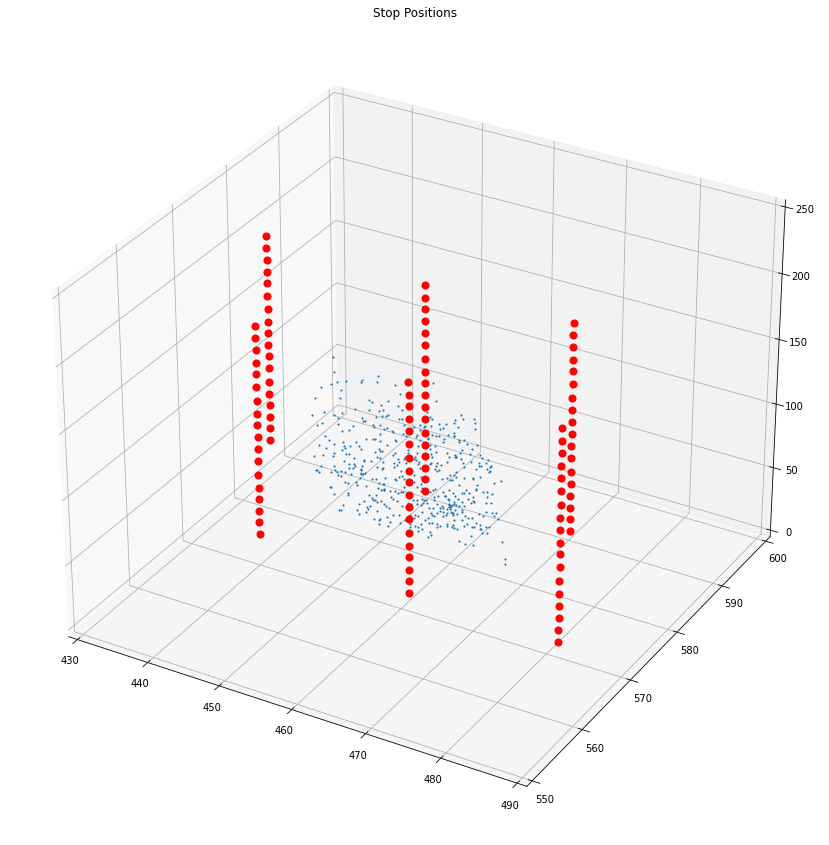

In [4]:
plot3D(df_complete,dom_positions)

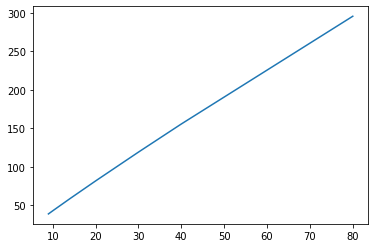

In [386]:
Es, distncs = dE_dx()
plt.plot(Es,distncs)

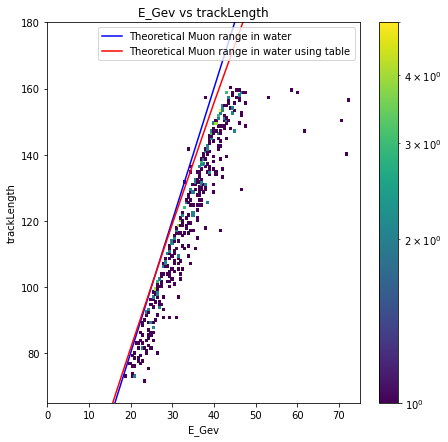

In [387]:
track_data_theoric_real(df_complete,var1_min=0,var1_max=75,var2_min=65,var2_max=180)

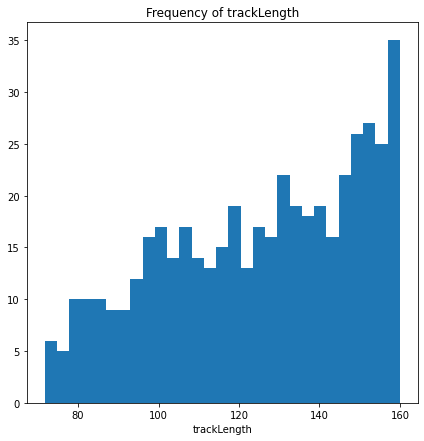

In [5]:
hist1d(df_complete,"trackLength",bins=30)

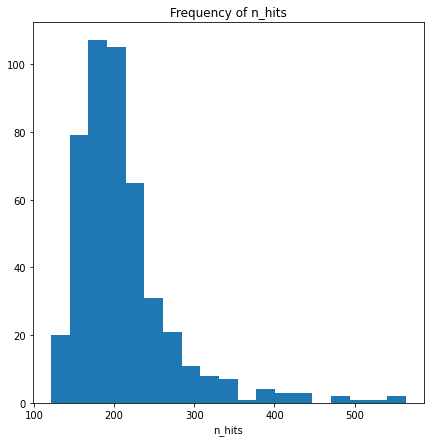

In [8]:
hist1d(df_complete,"n_hits",bins=20)

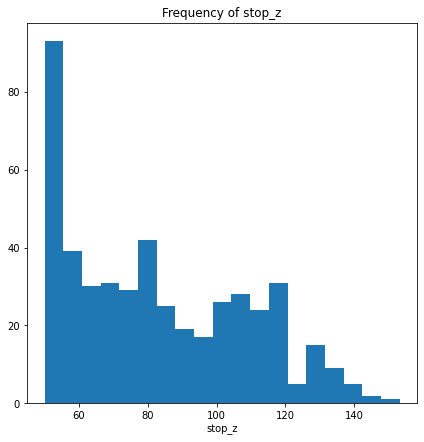

In [10]:
hist1d(df_complete,"stop_z",bins=20)

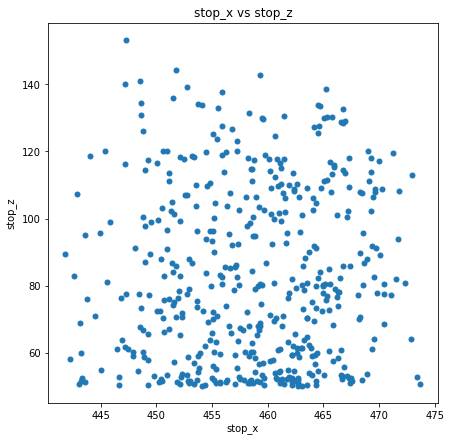

In [9]:
plot2scat(df_complete,"stop_x","stop_z",size=5)

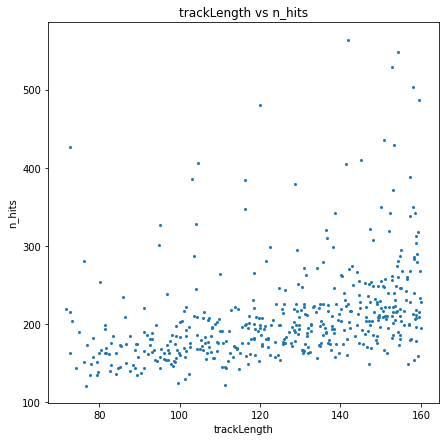

In [9]:
plot2scat(df_complete,"trackLength","n_hits",size=2)

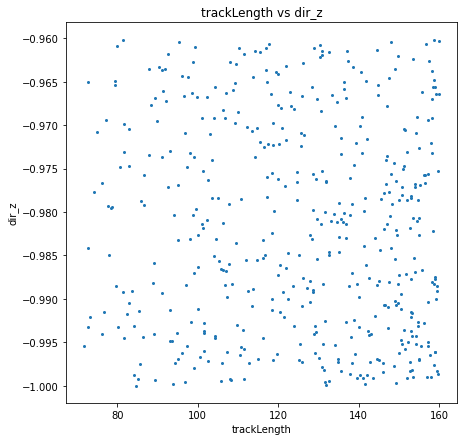

In [10]:
plot2scat(df_complete,"trackLength","dir_z",size=2)

### Plots hits position for a given track!

Text(0.5, 1.0, 'Hits x vs y position for a given track')

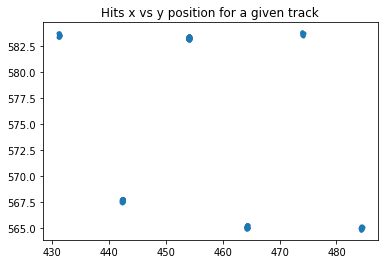

In [11]:
x_positions = df_complete.iloc[0]["hits_pos_x"]
y_positions = df_complete.iloc[0]["hits_pos_y"]
plt.plot(x_positions,y_positions,".")
plt.title("Hits x vs y position for a given track")

### Plots hits position for x vs y for a given track!

Text(0.5, 1.0, 'X position of hit vs time')

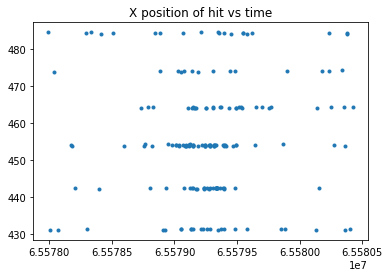

In [12]:
x_positions = df_complete.iloc[0]["hits_pos_x"]
time = df_complete.iloc[0]["hits_t"]
plt.plot(time,x_positions,".")
plt.title("X position of hit vs time")

###  Plots of variables for a given event, separated by DU

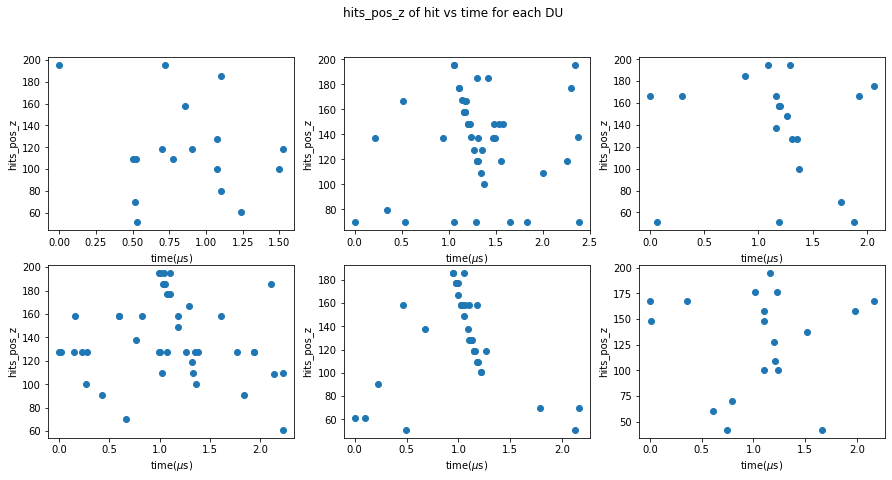

In [15]:
plot_DU(df_complete,"hits_pos_z")

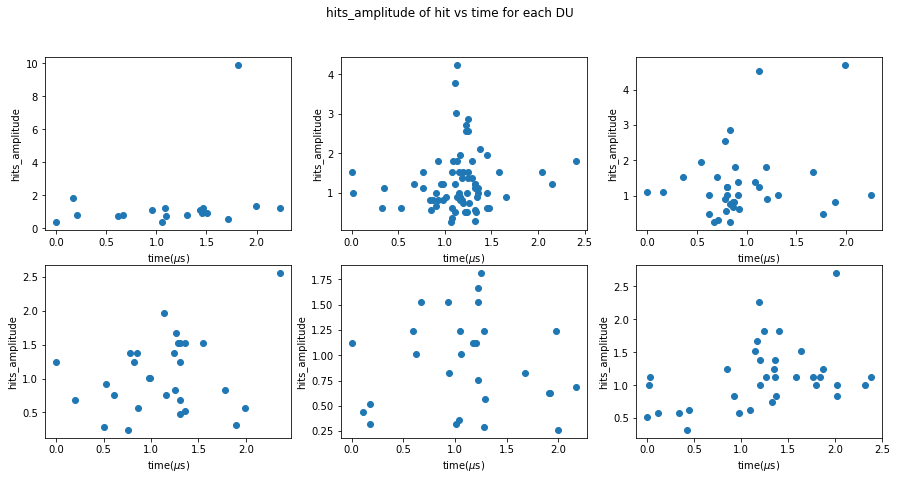

In [17]:
plot_DU(df_complete,"hits_amplitude")

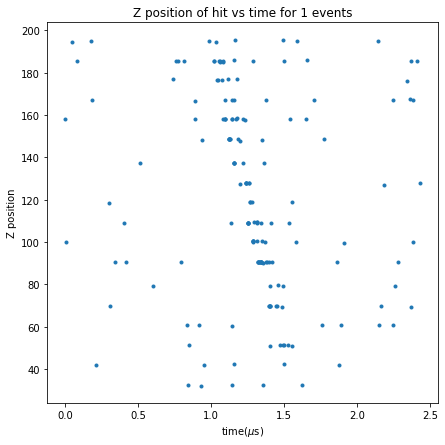

In [18]:
fig, axe = plt.subplots(figsize=(7,7))
for i in range(1):
    z_positions = df_complete.iloc[i]["hits_pos_z"]
    time = df_complete.iloc[i]["hits_t"]
    time_b = (time -min(time))*10**-3
    plt.plot(time_b,z_positions,".")
    n = i+1
    plt.title(f"Z position of hit vs time for {n} events")
    plt.xlabel(r'time($\mu$s)')
    plt.ylabel("Z position")
    

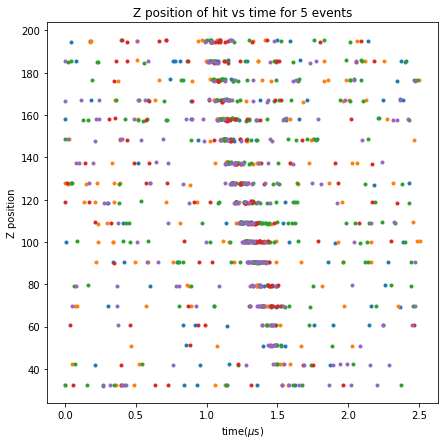

In [19]:
fig, axe = plt.subplots(figsize=(7,7))
for i in range(5):
    z_positions = df_complete.iloc[i]["hits_pos_z"]
    time = df_complete.iloc[i]["hits_t"]
    time_b = (time -min(time))*10**-3
    plt.plot(time_b,z_positions,".")
    n = i+1
    plt.title(f"Z position of hit vs time for {n} events")
    plt.xlabel(r'time($\mu$s)')
    plt.ylabel("Z position")
    

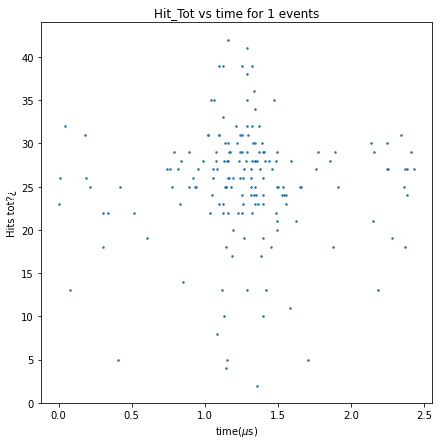

In [20]:
fig, axe = plt.subplots(figsize=(7,7))
for i in range(1):
    tot = df_complete.iloc[i]["hits_tot"]
    time = df_complete.iloc[i]["hits_t"]
    time_b = (time -min(time))*10**-3
    plt.plot(time_b,tot,".",markersize = 3)
    n = i+1
    plt.title(f"Hit_Tot vs time for {n} events")
    plt.xlabel(r'time($\mu$s)')
    plt.ylabel("Hits tot?¿")

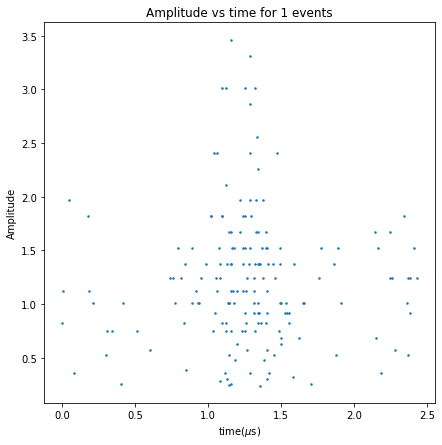

In [21]:
fig, axe = plt.subplots(figsize=(7,7))
for i in range(1):
    amplitude = df_complete.iloc[i]["hits_amplitude"]
    time = df_complete.iloc[i]["hits_t"]
    time_b = (time -min(time))*10**-3
    plt.plot(time_b,amplitude,".",markersize = 3)
    n = i+1
    plt.title(f"Amplitude vs time for {n} events")
    plt.xlabel(r'time($\mu$s)')
    plt.ylabel("Amplitude")

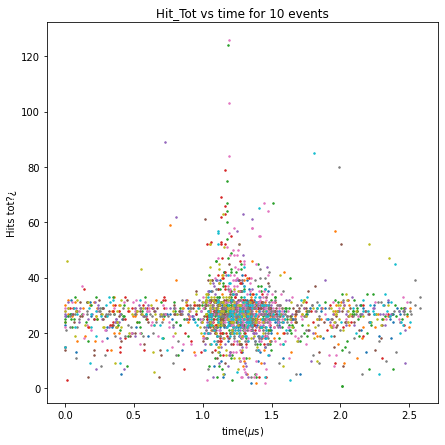

In [22]:
fig, axe = plt.subplots(figsize=(7,7))
for i in range(10):
    tot = df_complete.iloc[i]["hits_tot"]
    time = df_complete.iloc[i]["hits_t"]
    time_b = (time -min(time))*10**-3
    plt.plot(time_b,tot,".",markersize = 3)
    plt.title("Hit_Tot vs time for 10 events")
    plt.xlabel(r'time($\mu$s)')
    plt.ylabel("Hits tot?¿")

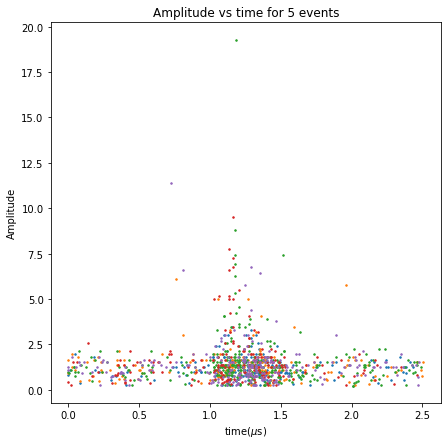

In [23]:
fig, axe = plt.subplots(figsize=(7,7))
for i in range(5):
    amplitude = df_complete.iloc[i]["hits_amplitude"]
    time = df_complete.iloc[i]["hits_t"]
    time_b = (time -min(time))*10**-3
    plt.plot(time_b,amplitude,".",markersize = 3)
    n = i+1
    plt.title(f"Amplitude vs time for {n} events")
    plt.xlabel(r'time($\mu$s)')
    plt.ylabel("Amplitude")

### All information for a given row

In [24]:
df_complete.iloc[0]

id                                                                    1211
run_id                                                                8802
frame_index                                                           1680
trigger_counter                                                        128
n_hits                                                                 175
hits_id                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
hits_amplitude           [1.2389603160123224, 1.1176397808807381, 0.828...
hits_channel_id          [23, 10, 10, 14, 10, 20, 1, 7, 9, 10, 27, 29, ...
hits_dom_id              [806451572, 806465101, 806465101, 806469630, 8...
hits_t                   [65580249.082, 65578179.831, 65579087.301, 655...
hits_tdc                 [65372502, 65370092, 65371000, 65370222, 65371...
hits_pos_x               [464.4, 453.914, 453.914, 484.295, 484.247, 48...
hits_pos_y               [565.263, 583.342, 583.342, 565.013, 565.115, ...
hits_pos_z               

## Compute closest to end of the track dom_id for each event

In [25]:
closest_dom_end_track = closest_dom(df_complete)

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


## Show that is not the same DOM as the last one on the hits_dom_id list

In [27]:
dom_closest = closest_dom_end_track[0]
doms_event_0 = df_complete.loc[df_complete.index == 0, "hits_dom_id"].values[0]
last_dom = doms_event_0[-1]
print(last_dom, dom_closest)

809544061 808982547


## Add closest DOM_id to the dataframe

In [47]:
df_complete["closest_DOM_end_track"] = closest_dom_end_track
df_complete.to_pickle('dataframes_volumecut/df_complete.pkl')

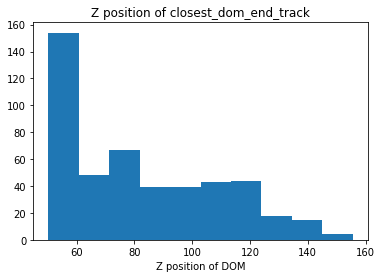

In [28]:
zs = []
for i in df_complete["closest_DOM_end_track"].values[:]:
    zs.append(dom_positions[dict_index[i]][2])
plt.hist(zs, bins = 10)
plt.title("Z position of closest_dom_end_track")
plt.xlabel("Z position of DOM")
plt.show()

In [29]:
df_complete.head()

id  run_id  frame_index  trigger_counter  n_hits  \
0   1211    8802         1680              128     175   
1   2781    8802         3592              265     208   
2   4982    8802         6290              491     349   
3   9410    8802        11844              954     195   
4  14548    8802        18252             1486     237   

                                             hits_id  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      hits_amplitude  \
0  [1.2389603160123224, 1.1176397808807381, 0.828...   
1  [1.5223372950739724, 1.0097999406851943, 4.074...   
2  [1.0097999406851943, 1.0097999406851943, 1.238...   
3  [1.2389603160123224, 2.26148617811904, 0.91387...   
4  [0.7524857728641442, 0.5226604098865926, 1.817...   

                                     hits_channel_id  \
0  [23, 10, 10, 14, 10, 20, 1, 7, 9, 10, 27, 29, ...   
1  [4, 9, 17, 28, 10, 25, 0, 20, 27, 12, 9, 9, 14...   
2  [25, 15, 3, 18, 12, 19, 19, 21, 2, 5, 1, 6, 3,...   
3  [4, 15, 0, 1, 1, 8, 30, 24, 23, 14, 16, 18, 10...   
4  [17, 4, 19, 15, 17, 2, 22, 23, 15, 6, 6, 15, 1...   

                                         hits_dom_id  \
0  [806451572, 806465101, 806465101, 806469630, 8...   
1  [806451572, 806451572, 806451572, 806465101, 8...   
2  [806451572, 806451572, 806465101, 806465101, 8...   
3  [806451572, 806451572, 806465101, 806469630, 8...   
4  [806451572, 806451572, 806451572, 806465101, 8...   

                                              hits_t  ...     dir_y     dir_z  \
0  [65580249.082, 65578179.831, 65579087.301, 655...  ... -0.168472 -0.984615   
1  [61469212.93, 61469705.725999996, 61469711.24,...  ...  0.146999 -0.986110   
2  [3657435.425, 3659672.3099999996, 3657957.269,...  ...  0.107802 -0.978670   
3  [39818699.6, 39818696.79, 39818747.734000005, ...  ... -0.139857 -0.987583   
4  [40792800.67, 40793383.87, 40793404.761, 40792...  ... -0.204384 -0.961317   

      start_x     start_y     start_z trackLength      stop_x      stop_y  \
0  453.070366  598.155918  209.507457  135.187836  446.801817  575.380511   
1  443.490674  554.416972  196.109950  120.388200  452.799018  572.113884   
2  424.908171  559.264099  214.006886  150.070145  451.152396  575.441904   
3  480.665545  592.873121  218.134080  142.488090  470.469179  572.945171   
4  480.471395  603.552480  198.029779  144.540736  453.781113  574.010670   

      stop_z  closest_DOM_end_track  
0  76.399467              808982547  
1  77.393933              808974758  
2  67.137667              806483369  
3  77.415330              806451572  
4  59.080383              808979729  

[5 rows x 35 columns]

### Info of track and hit for a given event

In [30]:
file1 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008801.root"
f = kio.OfflineReader(file1)
#print all parameters for an event (evt)
for evt in f.events:
    print (dir(evt))  #list of parameter/attributes per event
    break
    
print("\n")
#Tracks variable for first event (evt)
for var in evt.tracks:
    print(var, evt.tracks[var])

print("\n")
#Tracks variable for first event (evt)
for var in evt.hits:
    print(var, evt.hits[var])

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_fields', '_make', '_replace', '_source', 'comment', 'count', 'det_id', 'flags', 'frame_index', 'hits', 'id', 'index', 'mc_event_time_ns', 'mc_event_time_sec', 'mc_hits', 'mc_id', 'mc_run_id', 'mc_t', 'mc_tracks', 'mc_trks', 'n_hits', 'n_mc_hits', 'n_mc_tracks', 'n_mc_trks', 'n_tracks', 'n_trks', 'overlays', 'run_id', 't_ns', 't_sec', 'tracks', 'trigger_counter', 'trigger_mask', 'trks', 'usr', 'usr_names', 'w', 'w2list', 'w3list']


id [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ... 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
pos_x [482, 482, 482, 489, 

## Distirbution of hits amplitude for all events together!

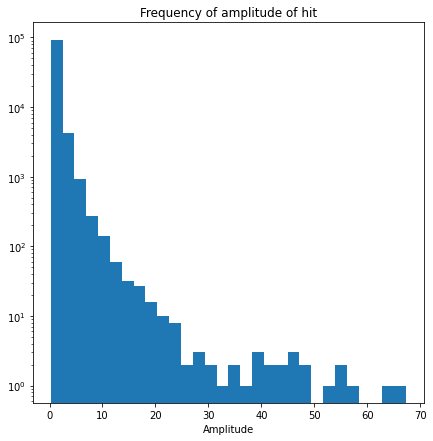

In [31]:
n = len(df_complete)
fig, axe = plt.subplots(figsize=(7,7))
amplitudes = np.array([])
for i in range(len(df_complete)):
    x = np.asarray(df_complete.iloc[i]["hits_amplitude"])
    amplitudes = np.concatenate((amplitudes,x))
    
    if i == n:
        break
    
plt.hist(amplitudes,bins=30)
plt.title(f"Frequency of amplitude of hit")
plt.xlabel("Amplitude")
plt.yscale('log')

### Z vs delta time and amplitude vs delta time for some events

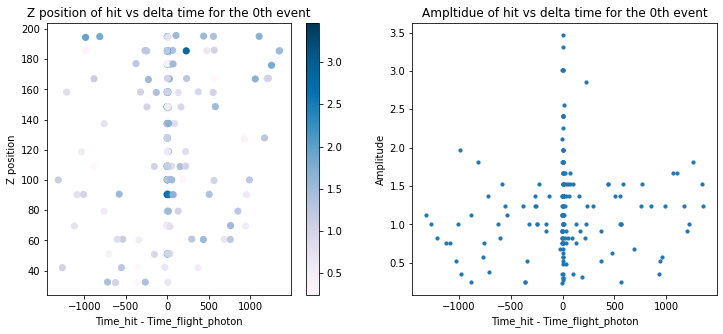

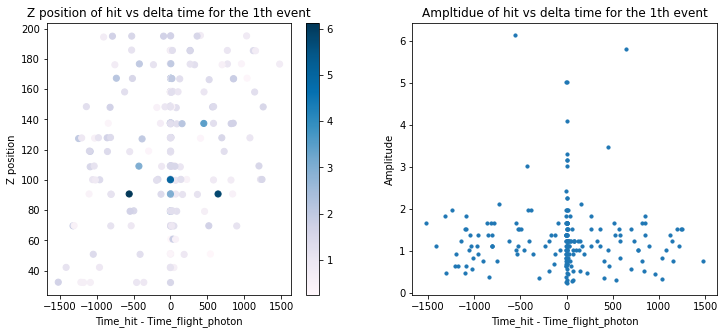

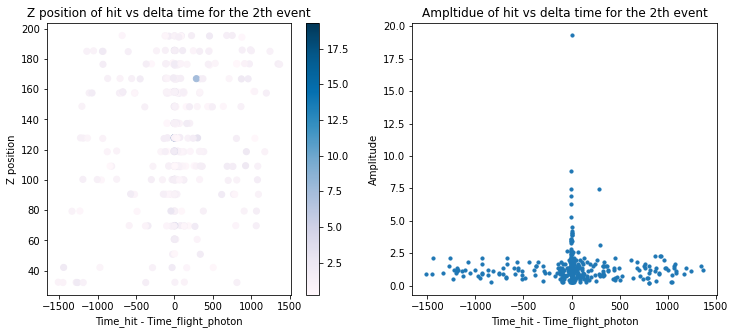

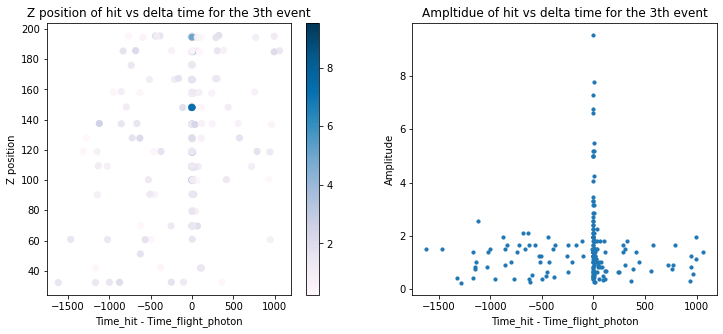

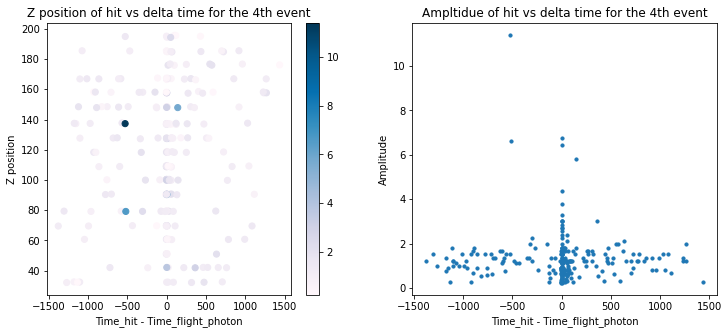

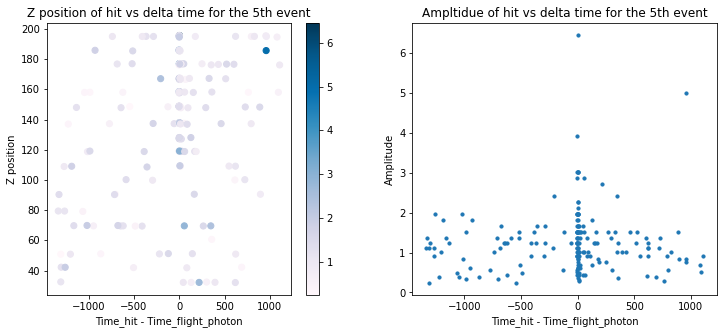

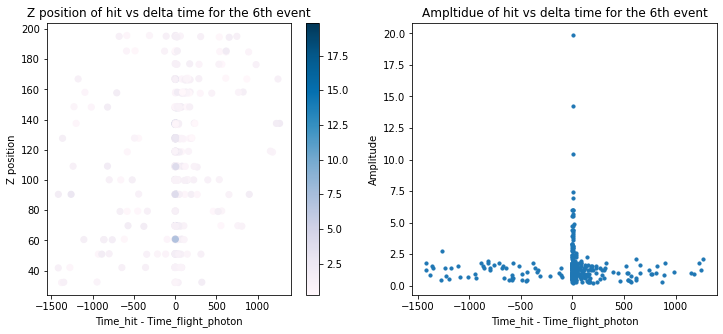

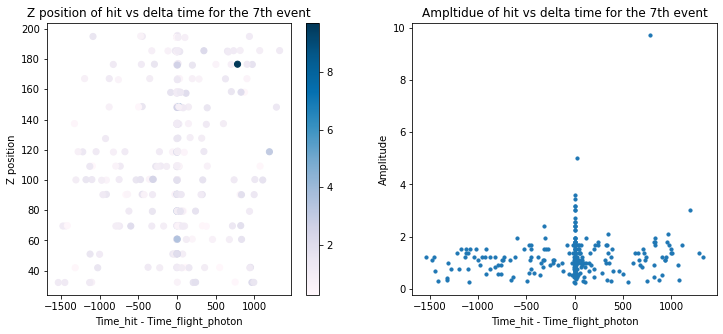

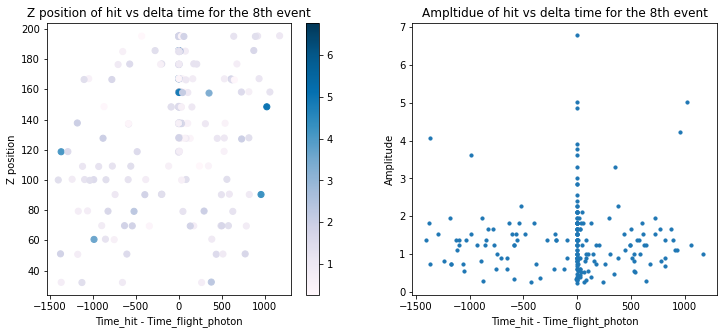

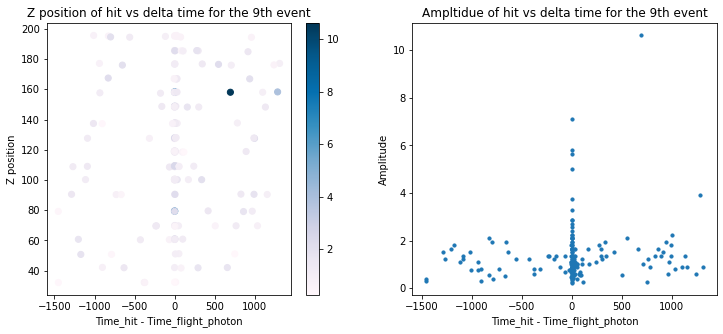

In [55]:
for event in range(10):
#event = 12
    calib_hits, track = track_hit_preparation(event,df_complete)
    result = cherenkov(calib_hits, track)
    time_to_plot = df_complete.iloc[event]["hits_t"]-result['t_photon']
    z_coordinates = df_complete.iloc[event]["hits_pos_z"]
    amplitudes = df_complete.iloc[event]["hits_amplitude"]

    fig, axe = plt.subplots(figsize=(12,5))
    plt.subplot(121)
    sc = plt.scatter(time_to_plot,z_coordinates,marker=".",s=150, c=amplitudes, cmap= "PuBu")
    plt.title(f"Z position of hit vs delta time for the {event}th event")
    plt.xlabel("Time_hit - Time_flight_photon")
    plt.ylabel("Z position")
    plt.colorbar(sc)

    plt.subplot(122)
    sc1 = plt.scatter(time_to_plot,amplitudes,marker="o",s=10)#, c=amplitudes, cmap= "PuBu")
    plt.title(f"Ampltidue of hit vs delta time for the {event}th event")
    plt.xlabel("Time_hit - Time_flight_photon")
    plt.ylabel("Amplitude")
    #plt.colorbar(sc1)
    plt.show()

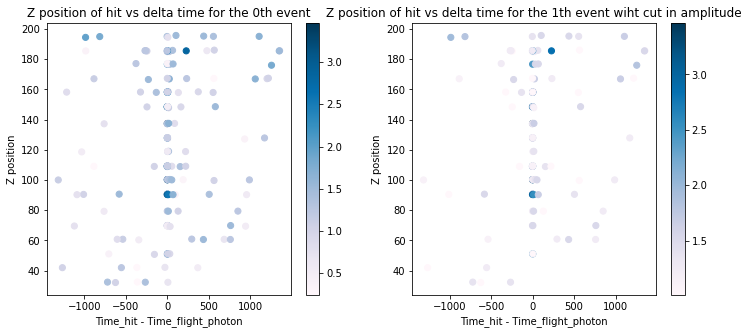

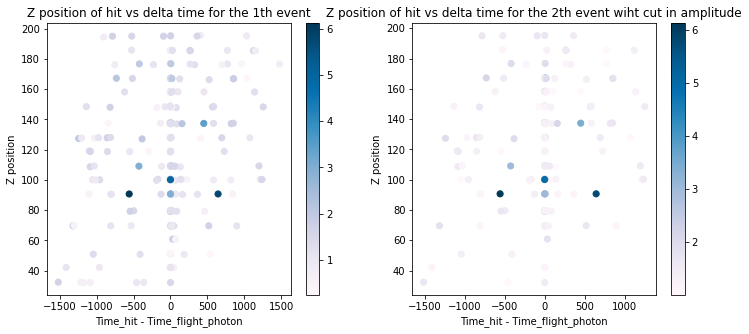

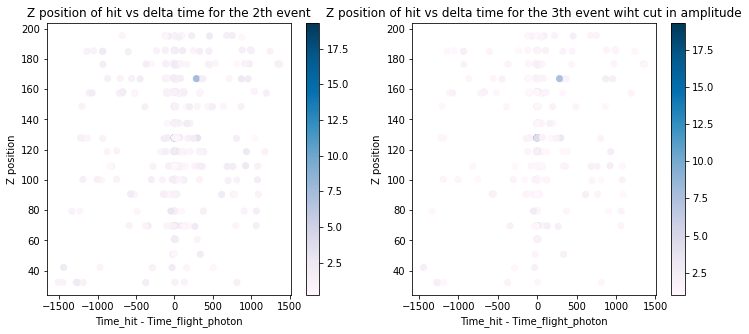

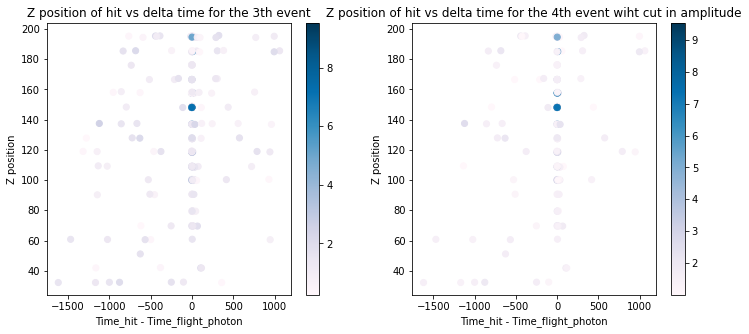

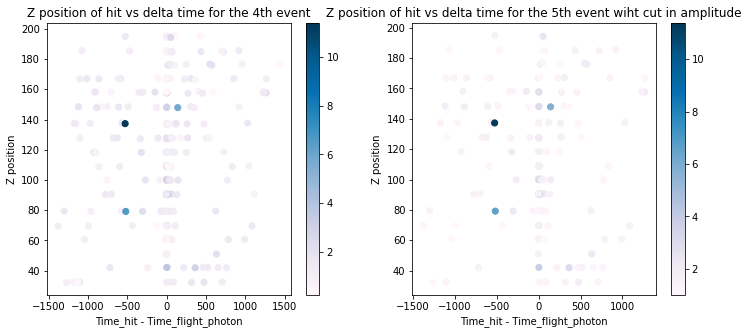

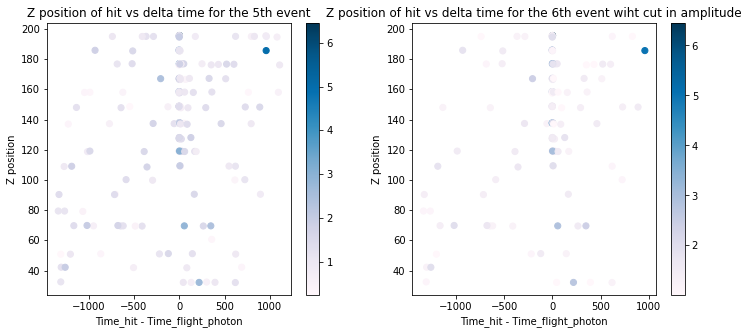

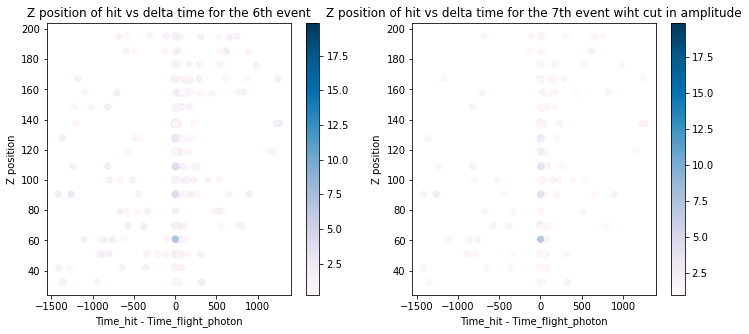

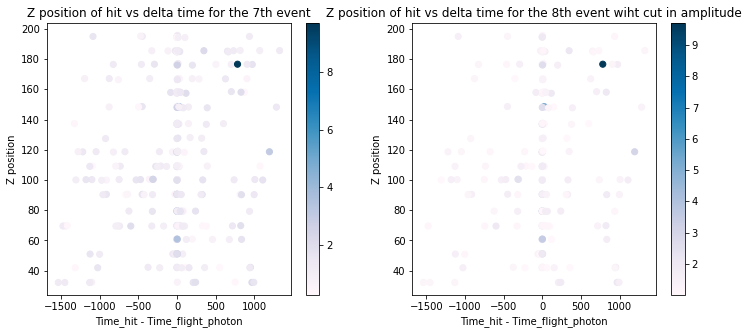

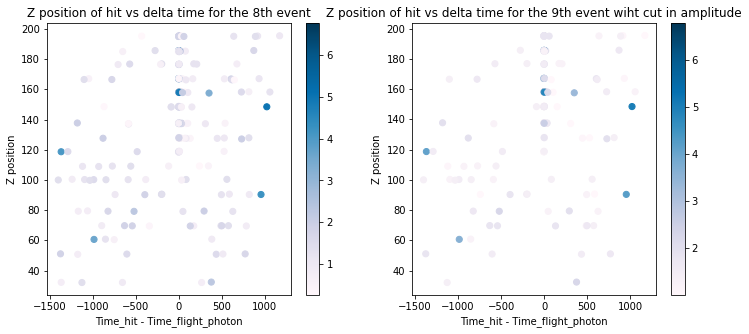

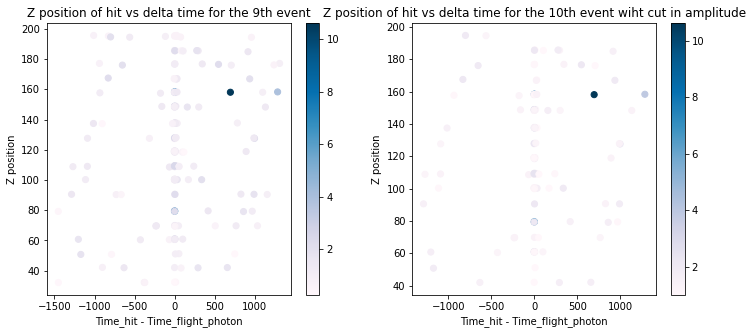

In [60]:
for event in range(10):
#event = 12
    calib_hits, track = track_hit_preparation(event,df_complete)
    result = cherenkov(calib_hits, track)
    time_to_plot = df_complete.iloc[event]["hits_t"]-result['t_photon']
    z_coordinates = df_complete.iloc[event]["hits_pos_z"]
    amplitudes = df_complete.iloc[event]["hits_amplitude"]
    
    cut = []
    for amplitude in amplitudes:
        if amplitude >= 1:
            cut.append(True)
        else:
            cut.append(False)

    fig, axe = plt.subplots(figsize=(12,5))
    
    plt.subplot(121)
    sc = plt.scatter(time_to_plot,z_coordinates,marker=".",s=150, c=amplitudes, cmap= "PuBu")
    plt.title(f"Z position of hit vs delta time for the {event}th event")
    plt.xlabel("Time_hit - Time_flight_photon")
    plt.ylabel("Z position")
    plt.colorbar(sc)
    
    
    plt.subplot(122)
    sc1 = plt.scatter(time_to_plot[cut],z_coordinates[cut],marker=".",s=150, c=amplitudes[cut], cmap= "PuBu")
    plt.title(f"Z position of hit vs delta time for the {event+1}th event wiht cut in amplitude")
    plt.xlabel("Time_hit - Time_flight_photon")
    plt.ylabel("Z position")
    plt.colorbar(sc1)
    
    plt.show()

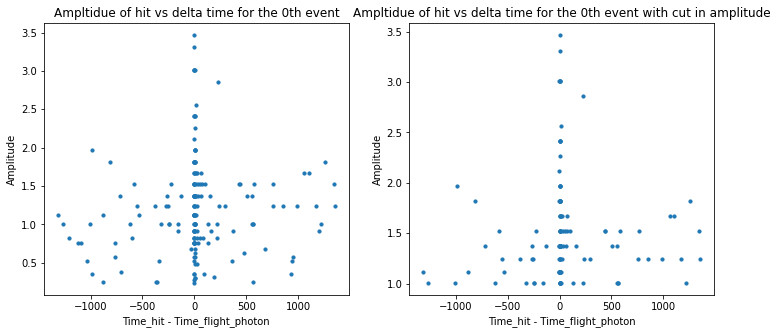

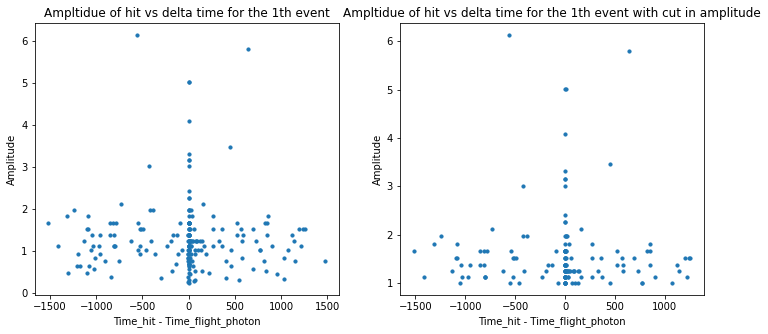

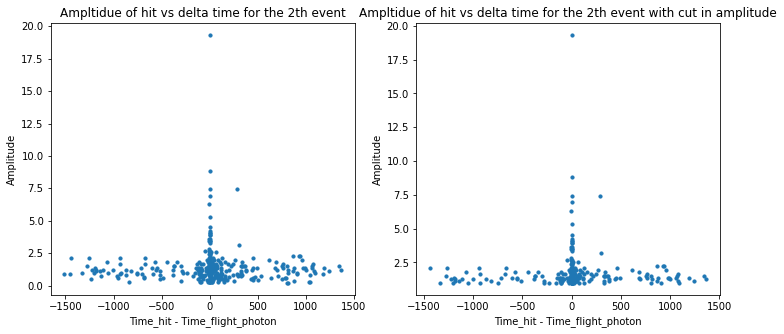

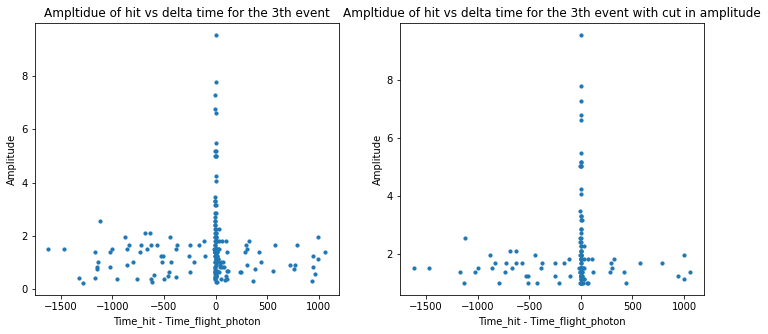

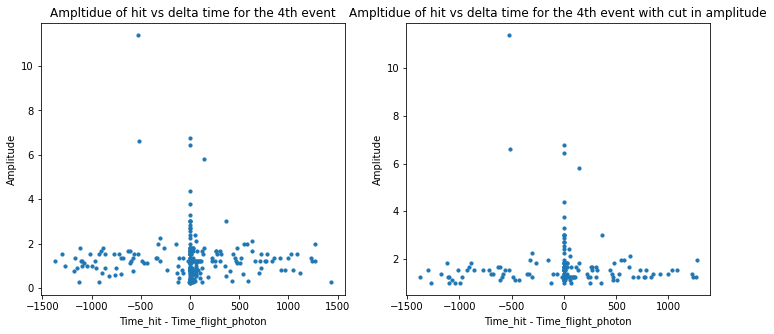

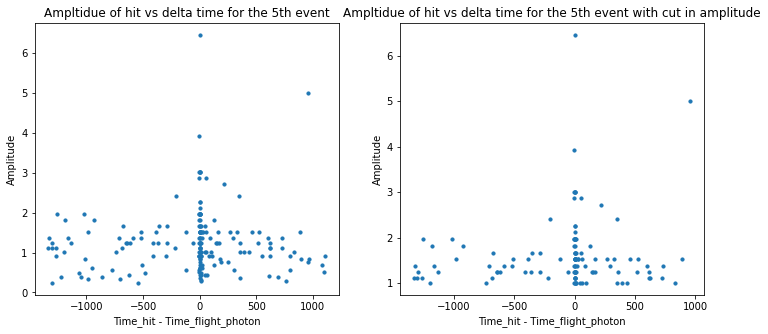

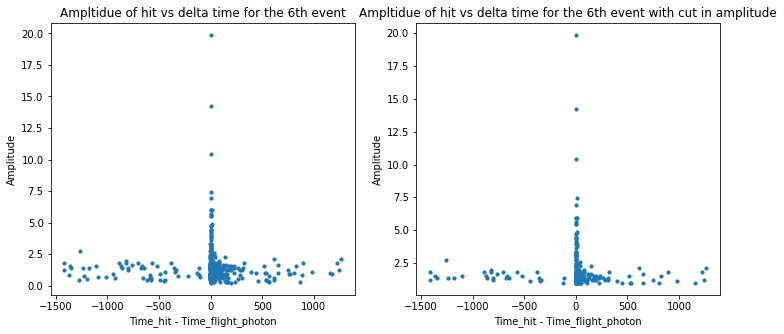

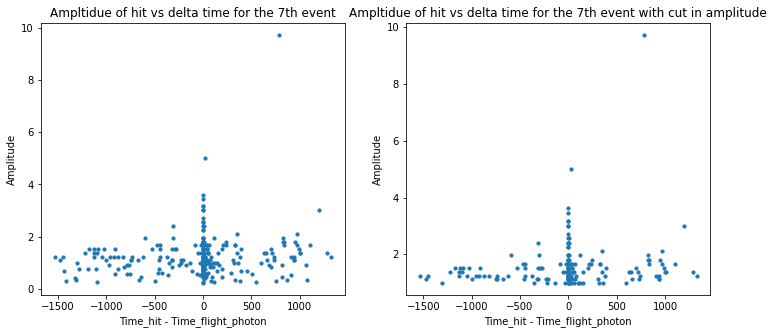

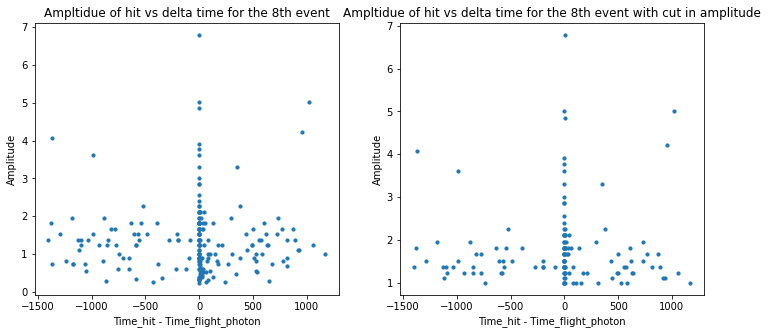

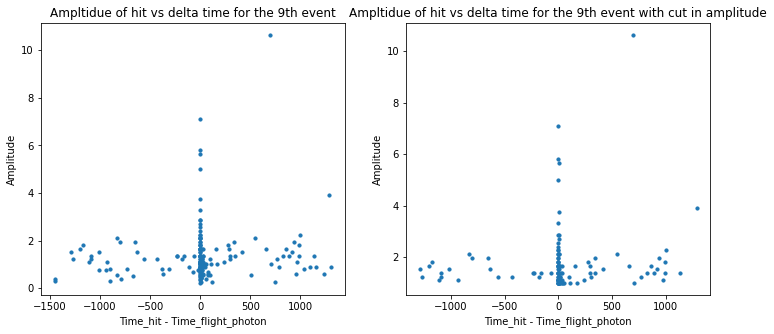

In [61]:
amp_cut = 1

for event in range(10):
#event = 12
    calib_hits, track = track_hit_preparation(event,df_complete)
    result = cherenkov(calib_hits, track)
    time_to_plot = df_complete.iloc[event]["hits_t"]-result['t_photon']
    z_coordinates = df_complete.iloc[event]["hits_pos_z"]
    amplitudes = df_complete.iloc[event]["hits_amplitude"]
    
    cut = []
    for amplitude in amplitudes:
        if amplitude >= amp_cut:
            cut.append(True)
        else:
            cut.append(False)

    fig, axe = plt.subplots(figsize=(12,5))
    
    plt.subplot(121)
    plt.scatter(time_to_plot,amplitudes,marker="o",s=10)#, c=amplitudes, cmap= "PuBu")
    plt.title(f"Ampltidue of hit vs delta time for the {event}th event")
    plt.xlabel("Time_hit - Time_flight_photon")
    plt.ylabel("Amplitude")
        
    plt.subplot(122)
    plt.scatter(time_to_plot[cut],amplitudes[cut],marker="o",s=10)#, c=amplitudes, cmap= "PuBu")
    plt.title(f"Ampltidue of hit vs delta time for the {event}th event with cut in amplitude")
    plt.xlabel("Time_hit - Time_flight_photon")
    plt.ylabel("Amplitude")
    plt.show()

### Comparison for 1 event of weighting and cutting amplitude

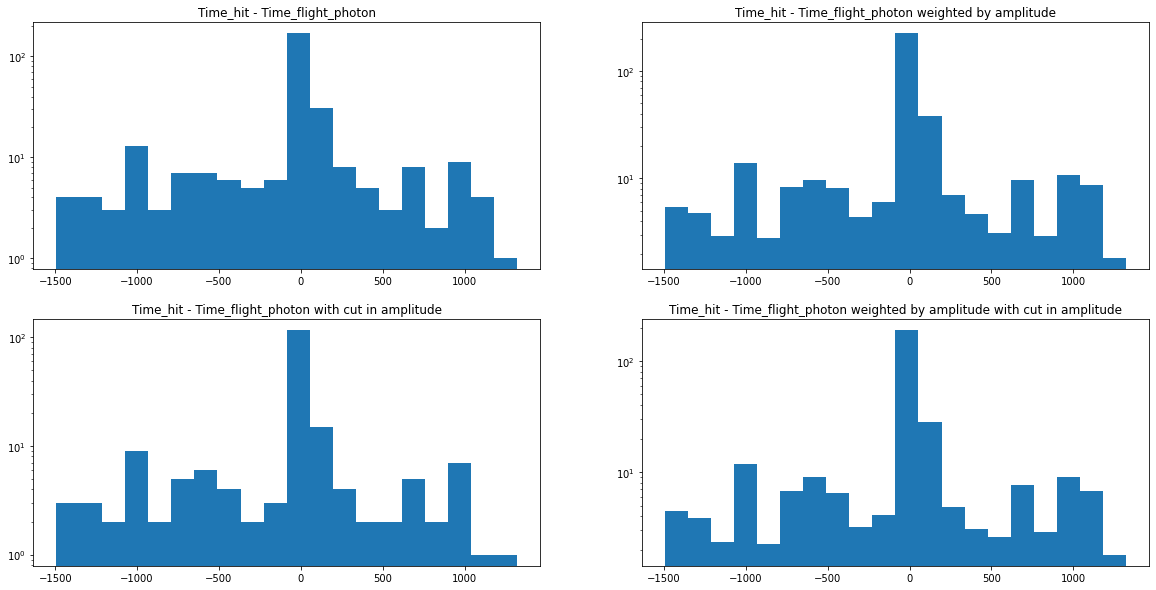

In [58]:
event = 10
calib_hits, track = track_hit_preparation(event,df_complete)
result = cherenkov(calib_hits, track)
time_to_plot = df_complete.iloc[event]["hits_t"]-result['t_photon']
amplitudes = df_complete.iloc[event]["hits_amplitude"]

cut = []
for amplitude in amplitudes:
    if amplitude >= 1:
        cut.append(True)
    else:
        cut.append(False)


fig, axe = plt.subplots(figsize=(20,10))
plt.subplot(221)
plt.hist(time_to_plot, bins=20)
plt.title("Time_hit - Time_flight_photon")
plt.yscale("log")

plt.subplot(222)
plt.hist(time_to_plot, weights = amplitudes, bins=20)
plt.title("Time_hit - Time_flight_photon weighted by amplitude")
plt.yscale("log")

plt.subplot(223)
plt.hist(time_to_plot[cut], bins=20)
plt.title("Time_hit - Time_flight_photon with cut in amplitude")
plt.yscale("log")

plt.subplot(224)
plt.hist(time_to_plot[cut], weights = amplitudes[cut], bins=20)
plt.title("Time_hit - Time_flight_photon weighted by amplitude with cut in amplitude")
plt.yscale("log")
plt.show()

## Cherenkov function implemented, ploted with and without weighting of amplitude

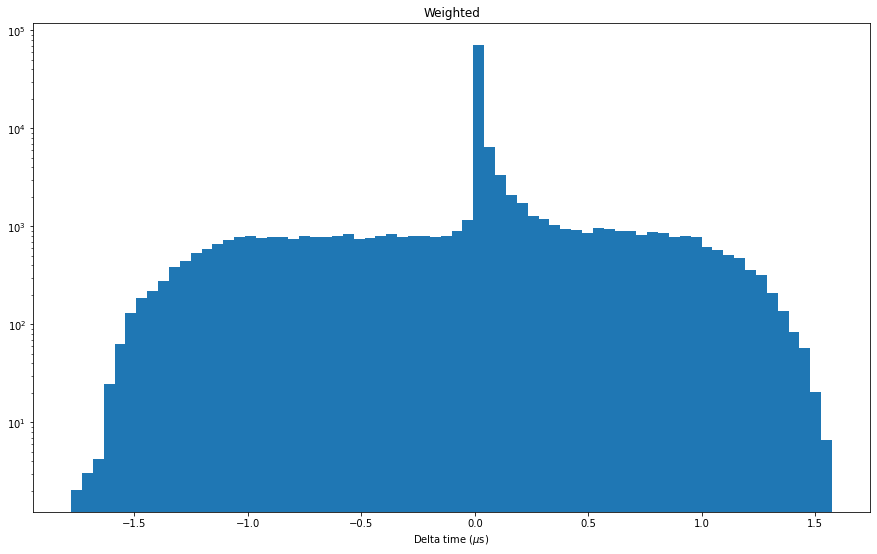

In [51]:
fig, axe = plt.subplots(figsize=(15,9))
plot_time_flight(len(df_complete),df_complete,log=True,weighted="hits_amplitude",bins=70)

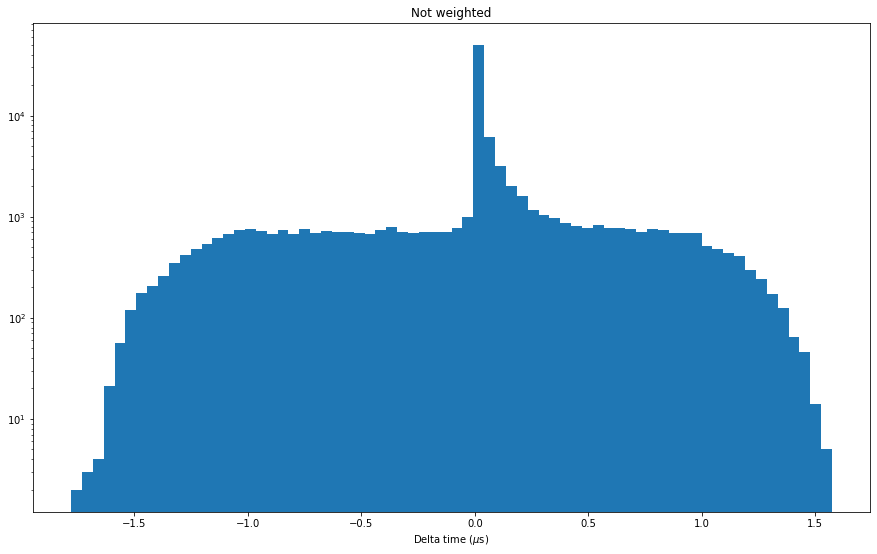

In [52]:
fig, axe = plt.subplots(figsize=(15,9))
plot_time_flight(len(df_complete),df_complete,log=True,bins=70)

## BIG dataframe

In [ ]:
##### Load it, and merge it with the other data

#file paths to read
# filepaths = [f for f in os.listdir("/public/baillysalins/km3net_data/output_df") if f.endswith('.pkl')]
# path = "/public/baillysalins/km3net_data/output_df/"
# dataframes = [path + file for file in filepaths]

# #concat them into a big dataframe
# df_BIG = pd.concat(map(pd.read_pickle, dataframes))

# closest_dom_end_track_BIG = closest_dom(df_BIG)

# df_BIG["closest_DOM_end_track"] = closest_dom_end_track_BIG
# df_BIG["hits_amplitude"] = df_BIG["hits_a"] #correction of hits amplitude column between dataframes
# df_BIG["t_track"] = df_BIG["track_t"]
    
# #datas = [df_BIG,df_complete]
# #df_FINAL = pd.concat(datas)
# df_FINAL = df_BIG
# df_FINAL.to_pickle('dataframes_volumecut/df_FINAL.pkl')

### Load big dataframe

In [11]:
df_FINAL = pd.read_pickle('dataframes_volumecut/df_FINAL.pkl')

In [6]:
df_FINAL.head()

id  run_id  frame_index  trigger_counter  n_hits  \
0   2312    8864         2895              242     183   
1   6519    8864         7951              604     213   
2  12889    8864        15640             1284     193   
3  13555    8864        16421             1338     135   
4  22594    8864        27409             2187     173   

                                             hits_id  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                     hits_channel_id  \
0  [1, 2, 7, 11, 12, 13, 16, 22, 0, 25, 5, 7, 17,...   
1  [29, 27, 26, 2, 5, 7, 18, 9, 24, 16, 1, 4, 5, ...   
2  [8, 26, 7, 11, 8, 8, 9, 10, 12, 13, 0, 5, 30, ...   
3  [1, 11, 12, 16, 11, 7, 1, 5, 7, 8, 9, 11, 13, ...   
4  [10, 21, 28, 2, 16, 26, 26, 26, 2, 8, 21, 7, 0...   

                                         hits_dom_id  \
0  [806455814, 806455814, 806455814, 806455814, 8...   
1  [806451572, 806455814, 806465101, 806465101, 8...   
2  [806451572, 806455814, 806455814, 806455814, 8...   
3  [806455814, 806455814, 806455814, 806455814, 8...   
4  [806451572, 806451572, 806455814, 806455814, 8...   

                                              hits_t  \
0  [38031326.944000006, 38031330.362, 38031327.02...   
1  [15066051.608, 15066158.409, 15066019.94100000...   
2  [76584489.89899999, 76583276.097, 76584290.656...   
3  [38603985.454, 38603985.412, 38603987.397, 386...   
4  [61380896.919, 61380835.286, 61380394.152, 613...   

                                            hits_tdc  ...     start_x  \
0  [37823513, 37823518, 37823513, 37823522, 37823...  ...  461.495703   
1  [14858306, 14858348, 14857940, 14857899, 14857...  ...  463.549708   
2  [76376743, 76375466, 76376475, 76376474, 76375...  ...  452.672960   
3  [38396171, 38396174, 38396177, 38396171, 38395...  ...  443.861645   
4  [61173155, 61173091, 61172584, 61172922, 61172...  ...  462.215361   

      start_y     start_z trackLength      stop_x      stop_y      stop_z  \
0  570.779291  204.770133  146.069625  452.429451  575.460253   59.057309   
1  580.797808  210.889600  140.888810  454.774356  574.805900   70.402067   
2  587.837709  215.626172  131.432008  446.910214  574.047130   85.046759   
3  562.517738  213.966852   90.839376  450.452336  573.179436  123.996395   
4  541.422968  217.774865  135.984316  457.226093  573.749236   85.782995   

  closest_DOM_end_track                                     hits_amplitude  \
0             808979729  [0.9138790663496179, 1.375543844288371, 1.1176...   
1             806483369  [1.8170302610914395, 0.6244029416604984, 0.269...   
2             808969857  [1.2389603160123224, 1.375543844288371, 2.5595...   
3             809524432  [1.2389603160123224, 0.8285079733900457, 1.522...   
4             808981672  [0.3205316203130729, 2.112996673175332, 1.1176...   

        t_track  
0  3.803101e+07  
1  1.506581e+07  
2  7.658394e+07  
3  3.860363e+07  
4  6.138032e+07  

[5 rows x 37 columns]

In [69]:
print("Shape: ", df_FINAL.shape)
print("Size: ", df_FINAL.size)

Shape:  (72803, 37)
Size:  2693711


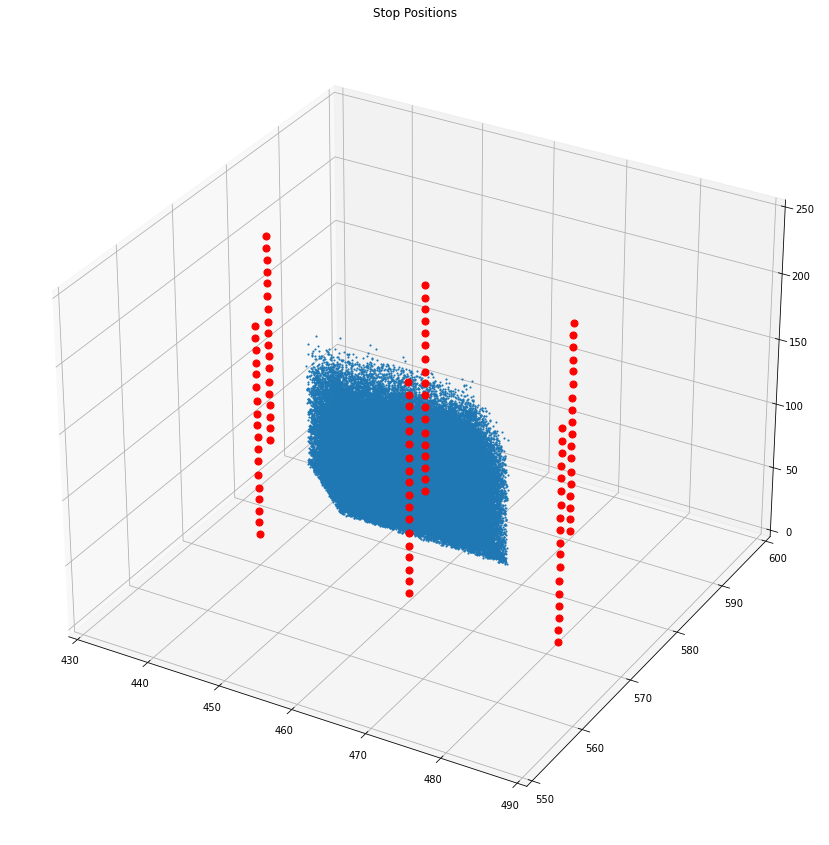

In [70]:
plot3D(df_FINAL,dom_positions)

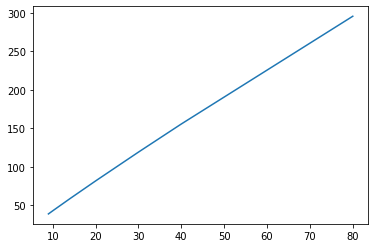

In [390]:
#Compute Stopping powers using linear regression
Es, distncs = dE_dx()
plt.plot(Es,distncs)     

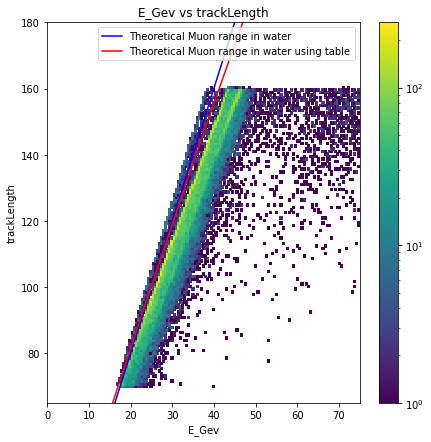

In [391]:
track_data_theoric_real(df_FINAL,var1_min=0,var1_max=75,var2_min=65,var2_max=180)

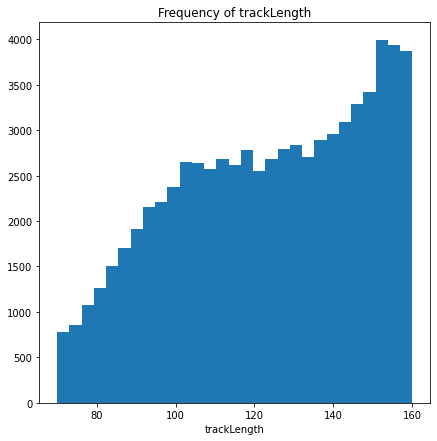

In [73]:
hist1d(df_FINAL,"trackLength",bins=30)

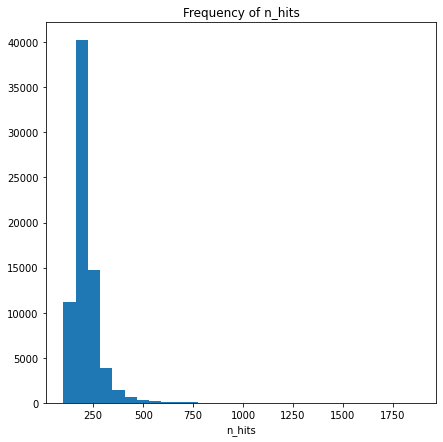

In [74]:
hist1d(df_FINAL,"n_hits",bins=30)

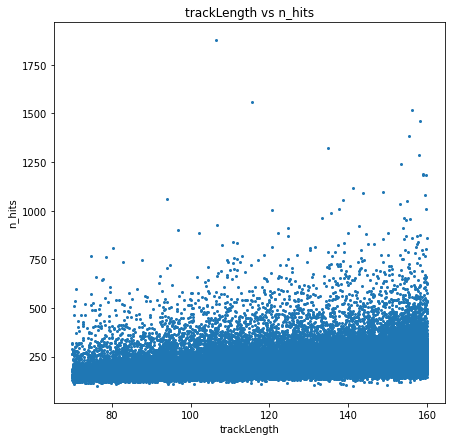

In [75]:
plot2scat(df_FINAL,"trackLength","n_hits",size=2)

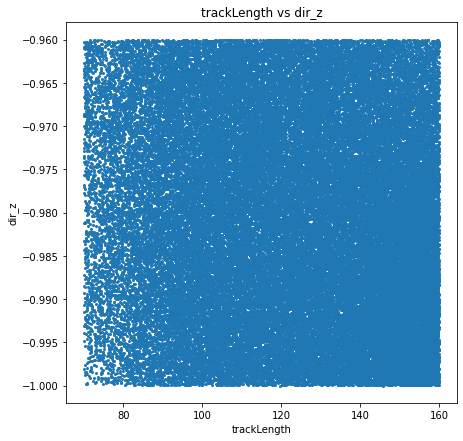

In [76]:
plot2scat(df_FINAL,"trackLength","dir_z",size=2)

### Load merged dataframe, to plot hit parameters of all events together

In [79]:
df_merged = pd.read_pickle("dataframes_volumecut/df_merged.pkl")
print("Shape: ", df_merged.shape)
df_merged.head()

Shape:  (15475040, 4)


delta_t  pmt_id       dom_id  hit_amplitude
0  -2.731102     1.0  806455814.0       0.913879
1   0.339264     2.0  806455814.0       1.375544
2  -2.631543     7.0  806455814.0       1.117640
3   3.625860    11.0  806455814.0       0.913879
4  22.891642    12.0  806455814.0       0.913879

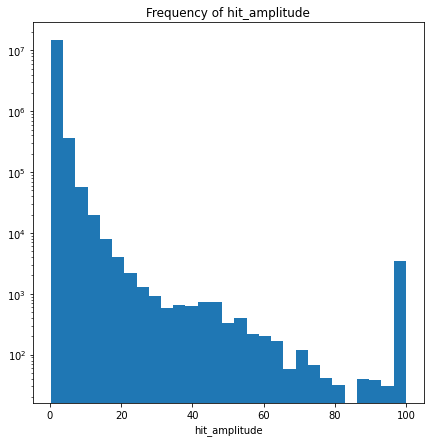

In [86]:
hist1d(df_merged,"hit_amplitude",bins=30,logscale_y=True)

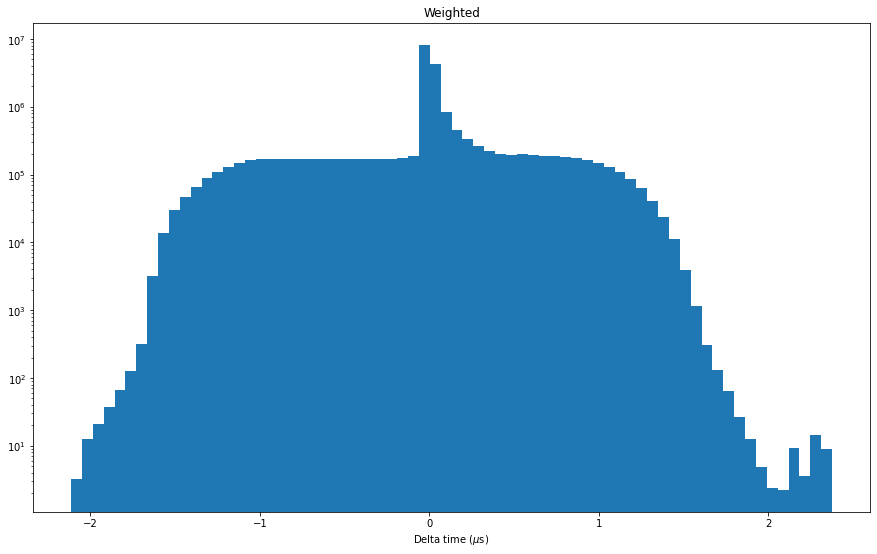

In [90]:
fig, axe = plt.subplots(figsize=(15,9))
plot_time_flight_new(df_merged,log=True,weighted=True,bins=70)

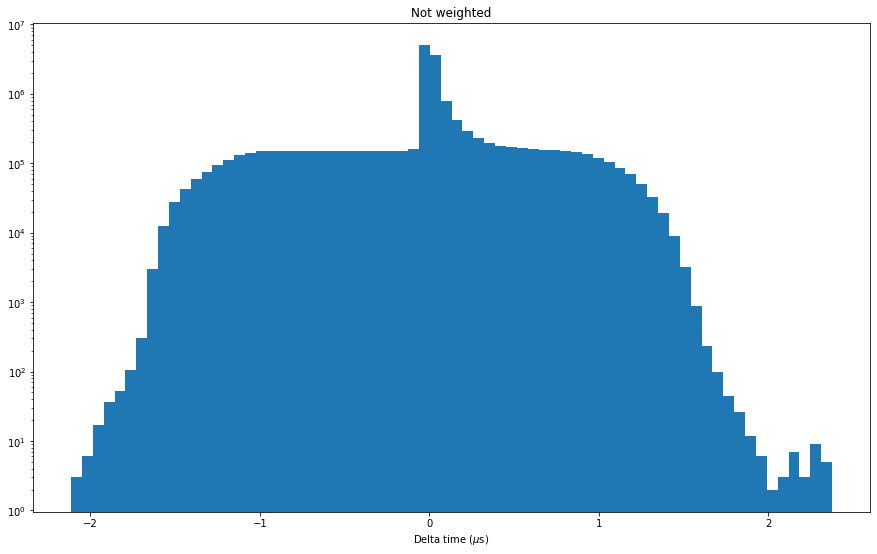

In [91]:
fig, axe = plt.subplots(figsize=(15,9))
plot_time_flight_new(df_merged,log=True,weighted=False,bins=70)

## MC Simulation

In [ ]:
# file = "/home/stefanescu/internship/muonstopwork/rootfiles/muons_6.1_merged.root"
# df_simulation = GUILLON_Cuts_Simulation(file,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
# df_simulation.to_pickle('dataframes_volumecut/df_simulation.pkl')   

In [32]:
df_simulation = pd.read_pickle('dataframes_volumecut/df_simulation.pkl')
print("Shape: ", df_simulation.shape)
df_simulation.head()

Shape:  (10990, 17)


id  run_id  t_sec       t_ns       t_track       E_Gev         lik  \
0  3515    7946   3919  100000000  8.826669e+07  101.690923  353.155223   
1  3551    7946   3959  600000000  8.081857e+06   35.241277  331.590796   
2  4708    7946   5247  400000000  4.532158e+07   30.115935  228.735387   
3    22    7948     19          0  4.144645e+05   25.212146  246.608526   
4  4151    7948   4567  500000000  5.574078e+07   27.770832  260.093078   

      dir_x     dir_y     dir_z     start_x     start_y     start_z  \
0  0.129304  0.087987 -0.987694  437.160525  558.348360  203.641465   
1 -0.193922  0.060581 -0.979145  483.820825  567.381918  200.130404   
2  0.260733 -0.055539 -0.963812  432.296299  579.371779  201.484855   
3  0.193160 -0.039587 -0.980368  441.651713  576.652844  218.813078   
4 -0.139595  0.001285 -0.990208  464.108542  574.740976  206.338251   

   trackLength      stop_x      stop_y      stop_z  
0   153.493758  457.007857  571.853839   52.036653  
1   127.194105  459.155049  575.087487   75.588989  
2   114.129291  462.053516  573.033159   91.485650  
3    94.803556  459.963958  572.899838  125.870672  
4   105.174979  449.426610  574.876130  102.193165

### Frequency of event, in order to compare between them, still to solve!!!

In [79]:
def freq(df):
    """Compute frequency of events for a dataframe. Based on difference between samller track time 
    and higher track time"""
    
    events = len(df)
    
    try:
        frequency = events/((np.max(df["t_sec"])-np.min(df["t_sec"])))
        print("Time difference between first and last event: ", (np.max(df["t_sec"])-np.min(df["t_sec"])))
        print("Frequency of stopping muon: ", frequency, " Hz")
        print("Stopping muon every ", 1/frequency, " seconds")
        
    except KeyError:
        frequency = events/((np.max(df["t_UTC_sec"])-np.min(df["t_UTC_sec"])))
        print("Time difference between first and last event: ", (np.max(df["t_UTC_sec"])-np.min(df["t_UTC_sec"])))
        print("Frequency of stopping muon: ", frequency, " Hz")
        print("Stopping muon every ", 1/frequency, " seconds")
        


In [80]:
print("Big data set:")
freq(df_FINAL)
print("\nSmall data set:")
freq(df_complete)
print("\nSimulations data set:")
freq(df_simulation)

Big data set:
Time difference between first and last event:  34660393
Frequency of stopping muon:  0.002100466662337037  Hz
Stopping muon every  476.0846805763499  seconds

Small data set:
Time difference between first and last event:  11166705
Frequency of stopping muon:  4.217895968416825e-05  Hz
Stopping muon every  23708.503184713376  seconds

Simulations data set:
Time difference between first and last event:  20699
Frequency of stopping muon:  0.5309435238417315  Hz
Stopping muon every  1.8834394904458598  seconds


## Last filtration of hits, based on pmt orientation or in backgorund substraction

In [3]:
#Load DET document and compute interseting info
det = kp.hardware.Detector('/home/stefanescu/internship/muonstopwork/KM3NeT_00000049_20200625.detx')
pmt_angles = det.pmt_angles
dom_positions_bis, dict_id, dict_index = DOM()

#Divide DOMS in the 6 columns
DU = DetectorUnits()

### Dividing the DOMS in 18 z-planes:
DU_plane_z = DetectorUnits_plane_z()


#Compute dictionaries of booleans depending on each plane and each DU, and z_means of each plane
z_means = compt_mean_z()
DUS_Ext = Extra_Plane()
DUS_Inf = Inf_plane()
DUS_Sup = SUP_plane()

#Compute ratio of active-non-active pmts at each plane
ratio_ext,ratio_sup_inf = pmt_ratios()

#Compute dictionary with booleans of inside-outside in all pmts of all doms
DUS_TOTAL = pmt_inside_outside()

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


### Vanila show for the df_complete of the pmt filter implementation and bckg substraction filtration

##### Perform the cuts ont he whole dataframe and store results in new dataframe

In [18]:
# df_complete = pd.read_pickle("dataframes_volumecut/df_complete.pkl")

# times = np.array([])
# amplitudes = np.array([])
# cuts = np.array([])
# is_on_plane = np.array([])
# dom_ids = np.array([])
# pmt_ids = np.array([])


# for event in range(len(df_complete)):
    
#     cut_hits_planes, is_on_planes =  pmt_cut_bis(event,df_complete)
#     cuts = np.concatenate((cuts,cut_hits_planes))
#     is_on_plane = np.concatenate((is_on_plane,is_on_planes))
    
#     calib_hits, track = track_hit_preparation(event,df_complete)
#     result = cherenkov(calib_hits, track)
#     time_to_plot = df_complete.iloc[event]["hits_t"]-result['t_photon']
    
#     times = np.concatenate((times,time_to_plot))
    

#     amplitude_event = df_complete.iloc[event]["hits_amplitude"]
#     amplitudes = np.concatenate((amplitudes,amplitude_event))
    
#     dom_id = df_complete.iloc[event]["hits_dom_id"]
#     dom_ids = np.concatenate((dom_ids,dom_id))
#     pmt_id = df_complete.iloc[event]["hits_channel_id"]
#     pmt_ids = np.concatenate((pmt_ids,pmt_id))

    
# df_test = pd.DataFrame()
# df_test["delta_t"] = times
# df_test["hit_amplitude"] = amplitudes
# df_test["cuts"] = cuts
# df_test["is_on_plane"] = is_on_plane
# df_test["dom_id"] = dom_ids
# df_test["pmt_id"] = pmt_ids


# df_test.to_pickle('dataframes_volumecut/df_complete_merged.pkl')

##### Load data

In [19]:
df_complete_merged = pd.read_pickle('dataframes_volumecut/df_complete_merged.pkl')
df_complete_merged.head()

delta_t  hit_amplitude  cuts  is_on_plane       dom_id  pmt_id
0  850.120743       1.238960   1.0          1.0  806451572.0    23.0
1 -883.452633       1.117640   1.0          0.0  806465101.0    10.0
2   24.017367       0.828508   1.0          0.0  806465101.0    10.0
3 -761.169205       0.752486   0.0          0.0  806469630.0    14.0
4   87.332358       0.828508   0.0          0.0  806469630.0    10.0

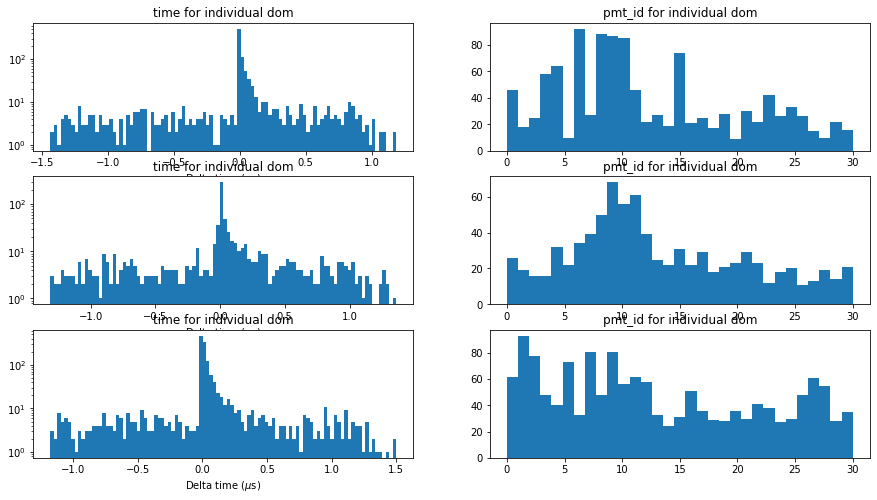

In [40]:
fig, axe = plt.subplots(figsize=(15,8))

plt.subplot(321)
time_dom = df_complete_merged['delta_t'][df_complete_merged['dom_id'] == 806451572.0]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = time_dom
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "time for individual dom")

plt.subplot(322)
pmts = df_complete_merged['pmt_id'][df_complete_merged['dom_id'] == 806451572.0]
plt.hist(pmts,bins=31)
plt.title("pmt_id for individual dom")


plt.subplot(323)
time_dom = df_complete_merged['delta_t'][df_complete_merged['dom_id'] == 806469630.0]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = time_dom
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "time for individual dom")

plt.subplot(324)
pmts = df_complete_merged['pmt_id'][df_complete_merged['dom_id'] == 806469630.0]
counts,edges,plot = plt.hist(pmts,bins=31)
plt.title("pmt_id for individual dom")


plt.subplot(325)
time_dom = df_complete_merged['delta_t'][df_complete_merged['dom_id'] == 806465101.0]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = time_dom
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "time for individual dom")

plt.subplot(326)
pmts = df_complete_merged['pmt_id'][df_complete_merged['dom_id'] == 806465101.0]
counts,edges,plot = plt.hist(pmts,bins=31)
plt.title("pmt_id for individual dom")

plt.show()

Text(0.5, 1.0, 'pmt_id for individual dom')

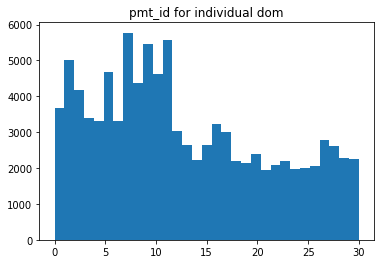

In [41]:
plt.hist(df_complete_merged['pmt_id'], bins = 31)
plt.title("pmt_id for individual dom")

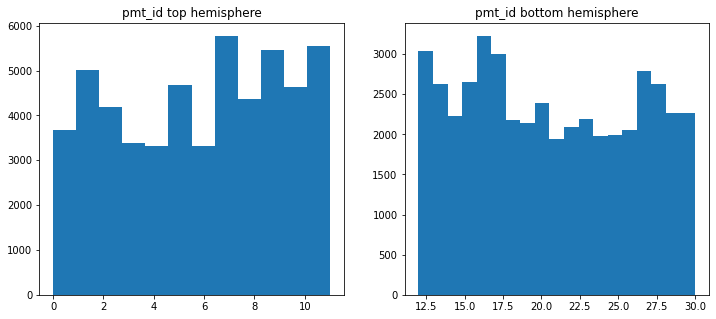

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(121)
pmts = df_complete_merged["pmt_id"][df_complete_merged['pmt_id'] <= 11]
plt.hist(pmts, bins = 12)
plt.title("pmt_id top hemisphere")

plt.subplot(122)
pmts = df_complete_merged["pmt_id"][df_complete_merged['pmt_id'] > 11]
plt.hist(pmts, bins = 19)
plt.title("pmt_id bottom hemisphere")

plt.show()

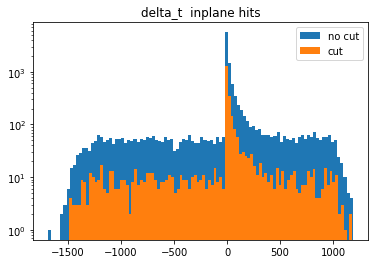

In [58]:
times = df_complete_merged["delta_t"][df_complete_merged['is_on_plane'] == 1]
plt.hist(times,bins = 100, label = "no cut")
plt.yscale("log")
plt.title("delta_t  inplane hits")

times = df_complete_merged["delta_t"][(df_complete_merged['is_on_plane'] == 1)&(df_complete_merged['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()

plt.show()

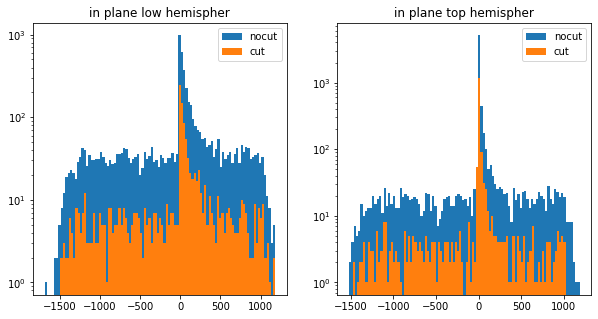

In [64]:
plt.figure(figsize=(10,5))

plt.subplot(121)
times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] > 11)&(df_complete_merged['is_on_plane'] == 1)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("in plane low hemispher")


times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] > 11)&(df_complete_merged['is_on_plane'] == 1)&(df_complete_merged['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.subplot(122)
times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] <= 11)&(df_complete_merged['is_on_plane'] == 1)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("in plane top hemispher")


times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] <= 11)&(df_complete_merged['is_on_plane'] == 1)&(df_complete_merged['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.show()

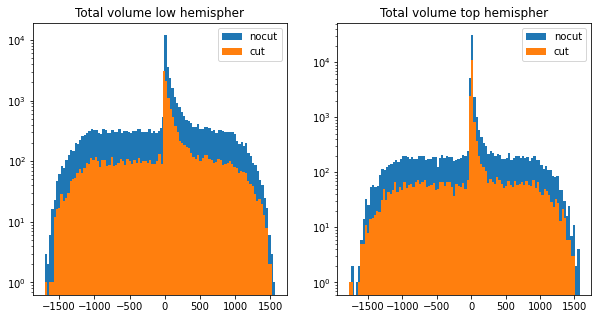

In [72]:
plt.figure(figsize=(10,5))

plt.subplot(121)
times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] > 11)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("Total volume low hemispher")


times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] > 11)&(df_complete_merged['cuts'] == 1)]
counts,edges,plot = plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.subplot(122)
times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] <= 11)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("Total volume top hemispher")


times = df_complete_merged["delta_t"][(df_complete_merged['pmt_id'] <= 11)&(df_complete_merged['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.show()

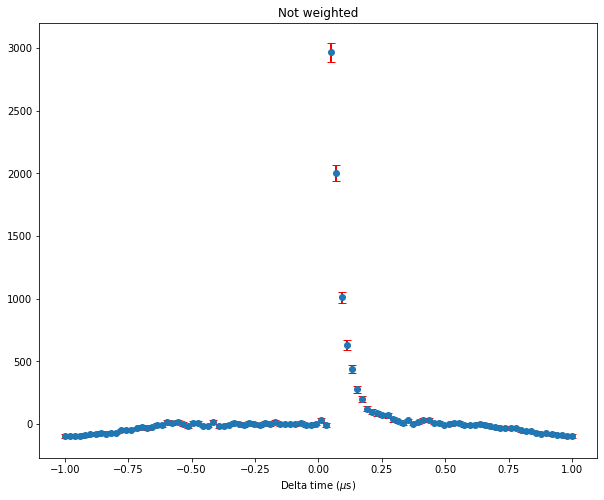

In [93]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [25,35],lower_cut=-1,higher_cut=1,bins = 100,log = False,weight = False)

[  8.55676303 -18.37779481]


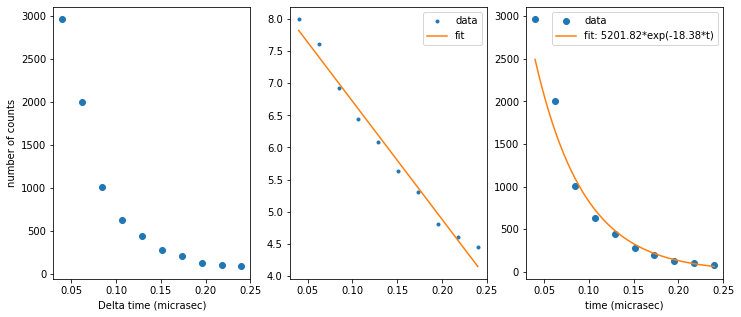

In [178]:
plt.figure(figsize=(12,5))


bin_time = 0.02 #micrasec
x = np.linspace(2,12,10)*bin_time
y = counts_new[52:62]
plt.subplot(131)
plt.plot(x,y,"o")
plt.xlabel("Delta time (micrasec)")
plt.ylabel("number of counts")


lny = np.log(y)
plt.subplot(132)
plt.plot(x,lny,".",label = "data")

X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x
beta = np.linalg.inv(X.T @ X) @ X.T @ lny
print(beta)

xx = np.linspace(2,12,50)*bin_time
yy = beta[0]+beta[1]*xx

plt.plot(xx,yy,label= "fit")
plt.legend()

y0 = np.exp(beta[0])*np.exp(beta[1]*xx)
plt.subplot(133)

limited_float = round(np.exp(beta[0]), 2)
limited_float1 = round(beta[1], 2)
plt.plot(x,y,"o",label = "data")
plt.plot(xx,y0,label = f"fit: {limited_float}*exp({limited_float1}*t)")
plt.xlabel("time (micrasec)")
plt.legend()
plt.show()

[  8.2716738  -17.18612159]


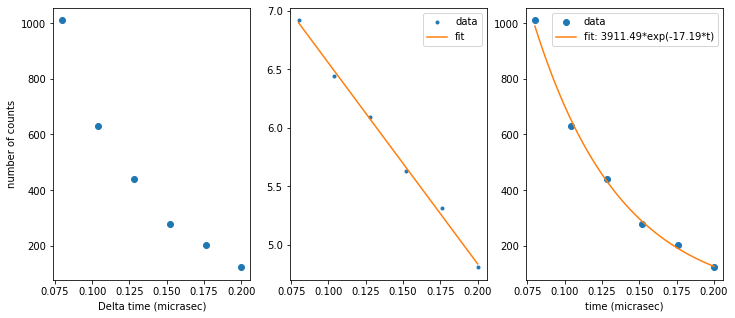

In [176]:
plt.figure(figsize=(12,5))


bin_time = 0.02 #micrasec
x = np.linspace(4,10,6)*bin_time
xx = np.linspace(4,10,50)*bin_time
y = counts_new[54:60]
plt.subplot(131)
plt.plot(x,y,"o")
plt.xlabel("Delta time (micrasec)")
plt.ylabel("number of counts")


lny = np.log(y)
plt.subplot(132)
plt.plot(x,lny,".",label = "data")

X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x
beta = np.linalg.inv(X.T @ X) @ X.T @ lny
print(beta)


yy = beta[0]+beta[1]*xx

plt.plot(xx,yy,label= "fit")
plt.legend()

y0 = np.exp(beta[0])*np.exp(beta[1]*xx)
plt.subplot(133)

limited_float = round(np.exp(beta[0]), 2)
limited_float1 = round(beta[1], 2)
plt.plot(x,y,"o",label = "data")
plt.plot(xx,y0,label = f"fit: {limited_float}*exp({limited_float1}*t)")
plt.xlabel("time (micrasec)")
plt.legend()
plt.show()

## Test with SUPER STRONG Z

In [12]:
#Load DET document and compute interseting info
det = kp.hardware.Detector('/home/stefanescu/internship/muonstopwork/KM3NeT_00000049_20200625.detx')
pmt_angles = det.pmt_angles
dom_positions_bis, dict_id, dict_index = DOM()

#Divide DOMS in the 6 columns
DU = DetectorUnits()

### Dividing the DOMS in 18 z-planes:
DU_plane_z = DetectorUnits_plane_z()


#Compute dictionaries of booleans depending on each plane and each DU, and z_means of each plane
z_means = compt_mean_z()
DUS_Ext = Extra_Plane()
DUS_Inf = Inf_plane()
DUS_Sup = SUP_plane()

#Compute ratio of active-non-active pmts at each plane
ratio_ext,ratio_sup_inf = pmt_ratios()

#Compute dictionary with booleans of inside-outside in all pmts of all doms
DUS_TOTAL = pmt_inside_outside()

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


### Vanila show for the df_complete of the pmt filter implementation and bckg substraction filtration

##### Perform the cuts ont he whole dataframe and store results in new dataframe

In [29]:
df_complete = pd.read_pickle("dataframes_volumecut/df_complete.pkl")

times = np.array([])
amplitudes = np.array([])
cuts = np.array([])
is_on_plane = np.array([])
dom_ids = np.array([])
pmt_ids = np.array([])


for event in range(len(df_complete)):
    
    if df_complete.iloc[event]["dir_z"] < -0.995:
    
        cut_hits_planes, is_on_planes =  pmt_cut_bis(event,df_complete)
        cuts = np.concatenate((cuts,cut_hits_planes))
        is_on_plane = np.concatenate((is_on_plane,is_on_planes))

        calib_hits, track = track_hit_preparation(event,df_complete)
        result = cherenkov(calib_hits, track)
        time_to_plot = df_complete.iloc[event]["hits_t"]-result['t_photon']

        times = np.concatenate((times,time_to_plot))


        amplitude_event = df_complete.iloc[event]["hits_amplitude"]
        amplitudes = np.concatenate((amplitudes,amplitude_event))

        dom_id = df_complete.iloc[event]["hits_dom_id"]
        dom_ids = np.concatenate((dom_ids,dom_id))
        pmt_id = df_complete.iloc[event]["hits_channel_id"]
        pmt_ids = np.concatenate((pmt_ids,pmt_id))

    
df_test = pd.DataFrame()
df_test["delta_t"] = times
df_test["hit_amplitude"] = amplitudes
df_test["cuts"] = cuts
df_test["is_on_plane"] = is_on_plane
df_test["dom_id"] = dom_ids
df_test["pmt_id"] = pmt_ids


df_test.to_pickle('dataframes_volumecut/df_complete_merged_zrestriction.pkl')

##### Load data

In [30]:
df_complete_merged_zrestriction = pd.read_pickle('dataframes_volumecut/df_complete_merged_zrestriction.pkl')
df_complete_merged_zrestriction.head()

delta_t  hit_amplitude  cuts  is_on_plane       dom_id  pmt_id
0    -0.211066       1.238960   0.0          0.0  806451572.0    10.0
1 -1044.025615       1.238960   0.0          0.0  806465101.0    25.0
2     1.941868       0.752486   0.0          0.0  806465101.0     2.0
3     0.013803       1.522337   0.0          0.0  806469630.0     8.0
4  -252.111341       1.375544   1.0          0.0  806472265.0    23.0

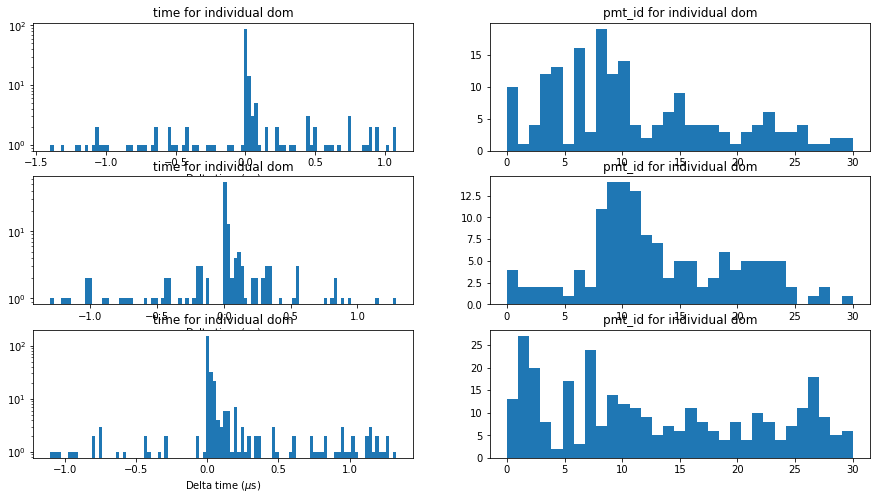

In [31]:
fig, axe = plt.subplots(figsize=(15,8))

plt.subplot(321)
time_dom = df_complete_merged_zrestriction['delta_t'][df_complete_merged_zrestriction['dom_id'] == 806451572.0]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = time_dom
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "time for individual dom")

plt.subplot(322)
pmts = df_complete_merged_zrestriction['pmt_id'][df_complete_merged_zrestriction['dom_id'] == 806451572.0]
plt.hist(pmts,bins=31)
plt.title("pmt_id for individual dom")


plt.subplot(323)
time_dom = df_complete_merged_zrestriction['delta_t'][df_complete_merged_zrestriction['dom_id'] == 806469630.0]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = time_dom
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "time for individual dom")

plt.subplot(324)
pmts = df_complete_merged_zrestriction['pmt_id'][df_complete_merged_zrestriction['dom_id'] == 806469630.0]
counts,edges,plot = plt.hist(pmts,bins=31)
plt.title("pmt_id for individual dom")


plt.subplot(325)
time_dom = df_complete_merged_zrestriction['delta_t'][df_complete_merged_zrestriction['dom_id'] == 806465101.0]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = time_dom
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "time for individual dom")

plt.subplot(326)
pmts = df_complete_merged_zrestriction['pmt_id'][df_complete_merged_zrestriction['dom_id'] == 806465101.0]
counts,edges,plot = plt.hist(pmts,bins=31)
plt.title("pmt_id for individual dom")

plt.show()

Text(0.5, 1.0, 'pmt_id for individual dom')

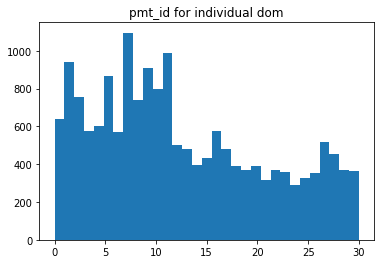

In [32]:
plt.hist(df_complete_merged_zrestriction['pmt_id'], bins = 31)
plt.title("pmt_id for individual dom")

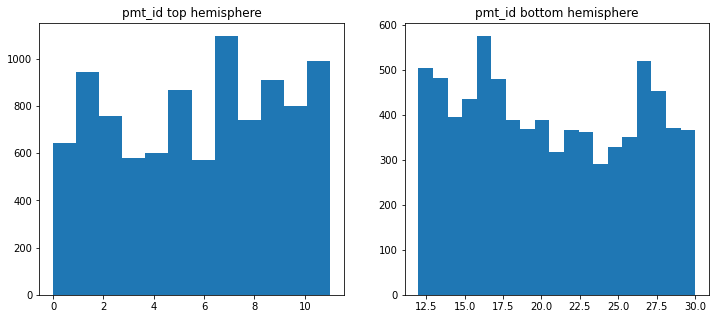

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(121)
pmts = df_complete_merged_zrestriction["pmt_id"][df_complete_merged_zrestriction['pmt_id'] <= 11]
plt.hist(pmts, bins = 12)
plt.title("pmt_id top hemisphere")

plt.subplot(122)
pmts = df_complete_merged_zrestriction["pmt_id"][df_complete_merged_zrestriction['pmt_id'] > 11]
plt.hist(pmts, bins = 19)
plt.title("pmt_id bottom hemisphere")

plt.show()

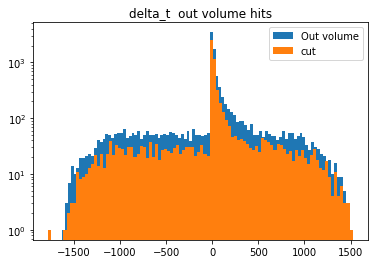

In [35]:
times = df_complete_merged_zrestriction["delta_t"][df_complete_merged_zrestriction['cuts'] == 0]
plt.hist(times,bins = 100, label = "Out volume")
plt.yscale("log")
plt.title("delta_t  out volume hits")

times = df_complete_merged_zrestriction["delta_t"][df_complete_merged_zrestriction['cuts'] == 1]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()

plt.show()

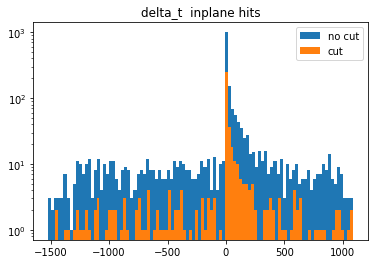

In [36]:
times = df_complete_merged_zrestriction["delta_t"][df_complete_merged_zrestriction['is_on_plane'] == 1]
plt.hist(times,bins = 100, label = "no cut")
plt.yscale("log")
plt.title("delta_t  inplane hits")

times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['is_on_plane'] == 1)&(df_complete_merged_zrestriction['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()

plt.show()

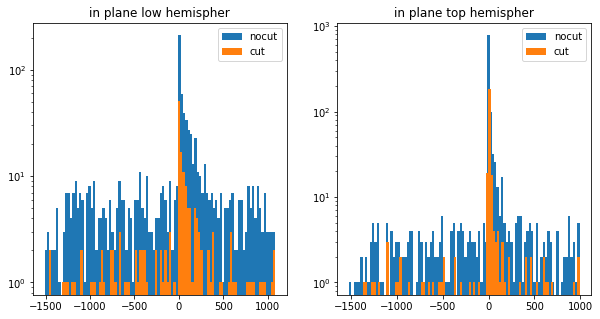

In [37]:
plt.figure(figsize=(10,5))

plt.subplot(121)
times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] > 11)&(df_complete_merged_zrestriction['is_on_plane'] == 1)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("in plane low hemispher")


times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] > 11)&(df_complete_merged_zrestriction['is_on_plane'] == 1)&(df_complete_merged_zrestriction['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.subplot(122)
times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] <= 11)&(df_complete_merged_zrestriction['is_on_plane'] == 1)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("in plane top hemispher")


times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] <= 11)&(df_complete_merged_zrestriction['is_on_plane'] == 1)&(df_complete_merged_zrestriction['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.show()

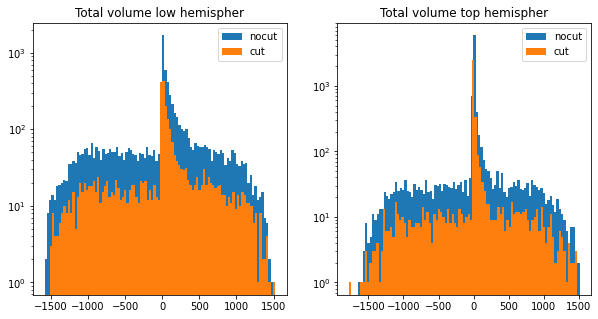

In [38]:
plt.figure(figsize=(10,5))

plt.subplot(121)
times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] > 11)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("Total volume low hemispher")


times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] > 11)&(df_complete_merged_zrestriction['cuts'] == 1)]
counts,edges,plot = plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.subplot(122)
times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] <= 11)]
plt.hist(times,bins = 100, label = "nocut")
plt.title("Total volume top hemispher")


times = df_complete_merged_zrestriction["delta_t"][(df_complete_merged_zrestriction['pmt_id'] <= 11)&(df_complete_merged_zrestriction['cuts'] == 1)]
plt.hist(times,bins = 100, label = "cut")
plt.yscale("log")
plt.legend()


plt.show()

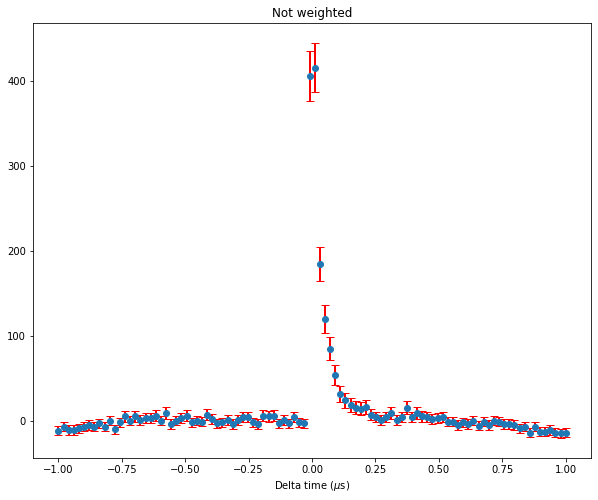

In [39]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [25,35],lower_cut=-1,higher_cut=1,bins = 100,log = False,weight = False)

[  5.05674019 -12.66156314]


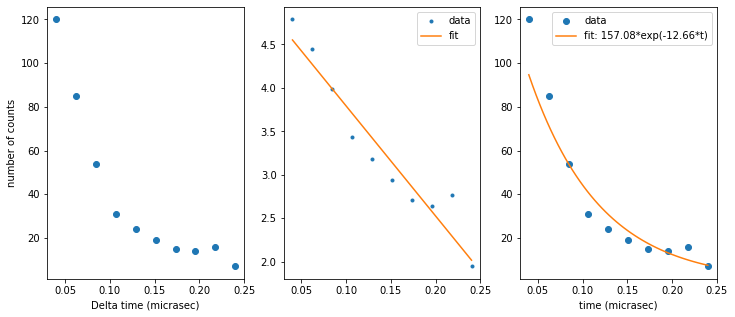

In [40]:
plt.figure(figsize=(12,5))


bin_time = 0.02 #micrasec
x = np.linspace(2,12,10)*bin_time
y = counts_new[52:62]
plt.subplot(131)
plt.plot(x,y,"o")
plt.xlabel("Delta time (micrasec)")
plt.ylabel("number of counts")


lny = np.log(y)
plt.subplot(132)
plt.plot(x,lny,".",label = "data")

X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x
beta = np.linalg.inv(X.T @ X) @ X.T @ lny
print(beta)

xx = np.linspace(2,12,50)*bin_time
yy = beta[0]+beta[1]*xx

plt.plot(xx,yy,label= "fit")
plt.legend()

y0 = np.exp(beta[0])*np.exp(beta[1]*xx)
plt.subplot(133)

limited_float = round(np.exp(beta[0]), 2)
limited_float1 = round(beta[1], 2)
plt.plot(x,y,"o",label = "data")
plt.plot(xx,y0,label = f"fit: {limited_float}*exp({limited_float1}*t)")
plt.xlabel("time (micrasec)")
plt.legend()
plt.show()

[  4.67560517 -10.90602315]


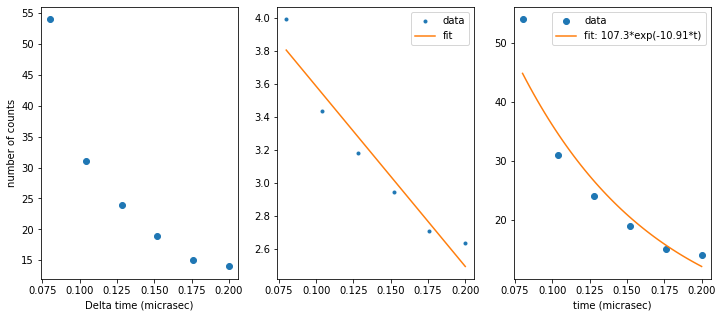

In [41]:
plt.figure(figsize=(12,5))


bin_time = 0.02 #micrasec
x = np.linspace(4,10,6)*bin_time
xx = np.linspace(4,10,50)*bin_time
y = counts_new[54:60]
plt.subplot(131)
plt.plot(x,y,"o")
plt.xlabel("Delta time (micrasec)")
plt.ylabel("number of counts")


lny = np.log(y)
plt.subplot(132)
plt.plot(x,lny,".",label = "data")

X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x
beta = np.linalg.inv(X.T @ X) @ X.T @ lny
print(beta)


yy = beta[0]+beta[1]*xx

plt.plot(xx,yy,label= "fit")
plt.legend()

y0 = np.exp(beta[0])*np.exp(beta[1]*xx)
plt.subplot(133)

limited_float = round(np.exp(beta[0]), 2)
limited_float1 = round(beta[1], 2)
plt.plot(x,y,"o",label = "data")
plt.plot(xx,y0,label = f"fit: {limited_float}*exp({limited_float1}*t)")
plt.xlabel("time (micrasec)")
plt.legend()
plt.show()

### Results of pmts geometry filtration for df_complete

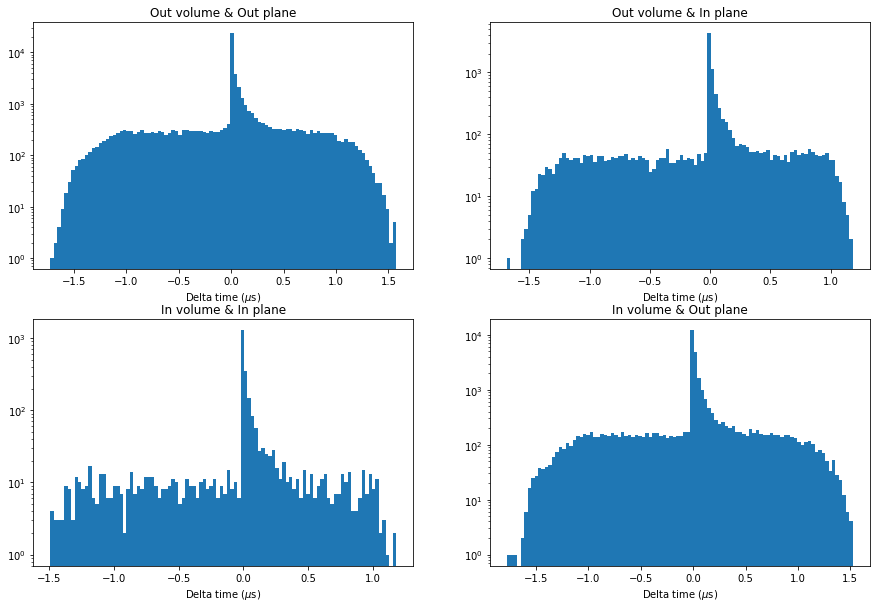

In [131]:
fig, axe = plt.subplots(figsize=(15,10))

subset_time_out_volume = df_complete_merged['delta_t'][(df_complete_merged['cuts'] == 0) & (df_complete_merged['is_on_plane'] == 0 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(221)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "Out volume & Out plane")

subset_time_out_volume = df_complete_merged['delta_t'][(df_complete_merged['cuts'] == 0) & (df_complete_merged['is_on_plane'] == 1 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(222)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "Out volume & In plane")

subset_time_out_volume = df_complete_merged['delta_t'][(df_complete_merged['cuts'] == 1) & (df_complete_merged['is_on_plane'] == 1 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(223)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "In volume & In plane")

subset_time_out_volume = df_complete_merged['delta_t'][(df_complete_merged['cuts'] == 1) & (df_complete_merged['is_on_plane'] == 0 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(224)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "In volume & Out plane")

plt.show()


### Ohter way of filtering

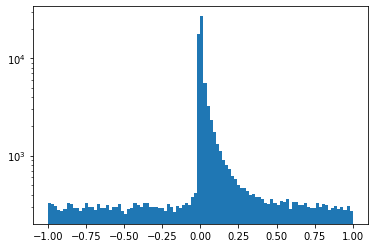

In [134]:
new_times, new_amplitudes, counts = histo_cut(df_complete_merged,lower_cut=-1,higher_cut=1, bins = 100, weight = False)

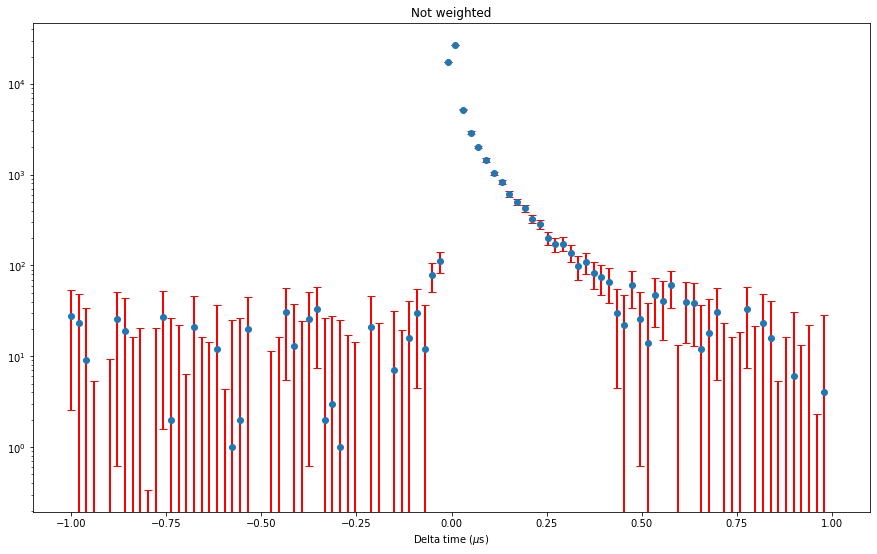

In [135]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [0,40],lower_cut=-1,higher_cut=1,bins = 100,weight = False)

### Double filtration: First cut in oriented pmts, then susbtract the common background

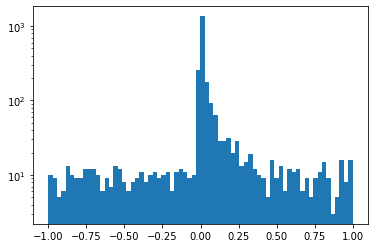

In [143]:
df_complete_merged_subset = df_complete_merged['delta_t'][(df_complete_merged['cuts'] == 1) & (df_complete_merged['is_on_plane'] == 1 )]
df_complete_merged_subset_a = df_complete_merged['hit_amplitude'][(df_complete_merged['cuts'] == 1) & (df_complete_merged['is_on_plane'] == 1 )]
df = pd.DataFrame()
df["delta_t"] = df_complete_merged_subset
df["hit_amplitude"] = df_complete_merged_subset_a
new_times, new_amplitudes, counts = histo_cut(df,lower_cut=-1,higher_cut=1, bins = 70, weight = False)

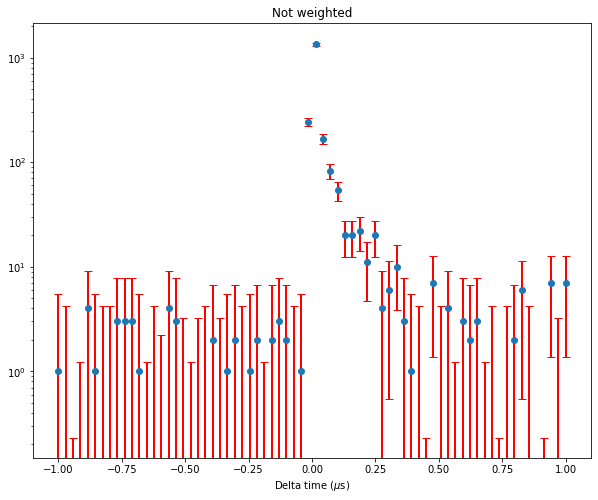

In [147]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [10,30],lower_cut=-1,higher_cut=1,bins = 70,weight = False)

## Filtration now on the big dataframe

In [148]:
path_file = "dataframes_volumecut/df_FINAL.pkl"
df_merged = merging_events_bis(path_file)
df_merged.to_pickle('dataframes_volumecut/df_FINAL_merged.pkl')

##### Load Data

In [149]:
df_FINAL_merged = pd.read_pickle('dataframes_volumecut/df_FINAL_merged.pkl')
df_FINAL_merged.head()

delta_t hit_amplitude  cuts  is_on_plane
0   -2.7311      0.913879   1.0          0.0
1  0.339264       1.37554   0.0          0.0
2  -2.63154       1.11764   1.0          0.0
3   3.62586      0.913879   1.0          0.0
4   22.8916      0.913879   1.0          0.0

### Results of pmts geometry filtration for df_FINAL

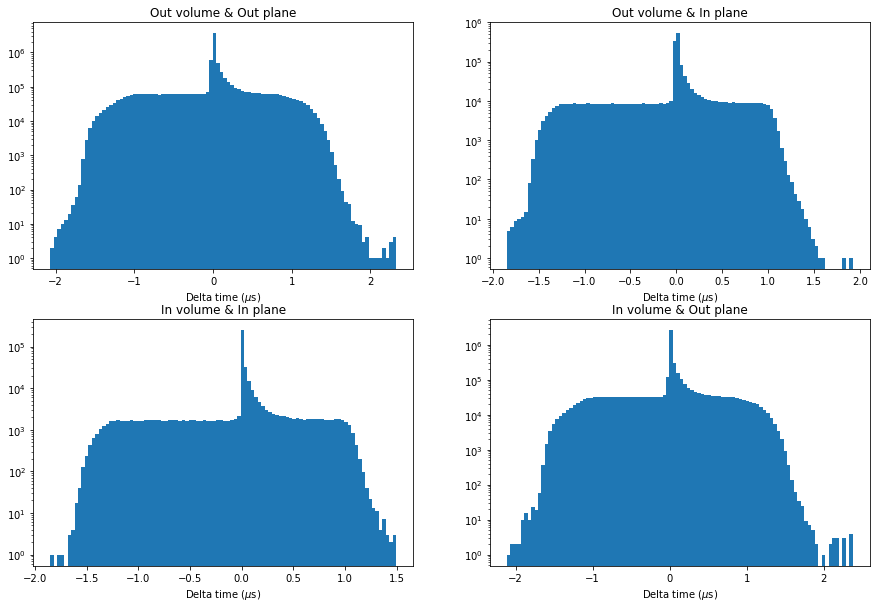

In [150]:
fig, axe = plt.subplots(figsize=(15,10))

subset_time_out_volume = df_FINAL_merged['delta_t'][(df_FINAL_merged['cuts'] == 0) & (df_FINAL_merged['is_on_plane'] == 0 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(221)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "Out volume & Out plane")

subset_time_out_volume = df_FINAL_merged['delta_t'][(df_FINAL_merged['cuts'] == 0) & (df_FINAL_merged['is_on_plane'] == 1 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(222)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "Out volume & In plane")

subset_time_out_volume = df_FINAL_merged['delta_t'][(df_FINAL_merged['cuts'] == 1) & (df_FINAL_merged['is_on_plane'] == 1 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(223)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "In volume & In plane")

subset_time_out_volume = df_FINAL_merged['delta_t'][(df_FINAL_merged['cuts'] == 1) & (df_FINAL_merged['is_on_plane'] == 0 )]
df_out_volume = pd.DataFrame()
df_out_volume["delta_t"] = subset_time_out_volume
plt.subplot(224)
plot_time_flight_cuts(df_out_volume,weighted=False,log=True,bins=100, title = "In volume & Out plane")

plt.show()


### Ohter way of filtering

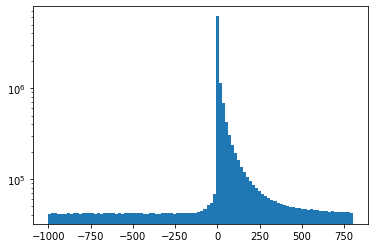

In [160]:
counts = histo_cut_big(df_FINAL_merged,lower_cut=-1,higher_cut=0.8, bins = 100, weight = False)

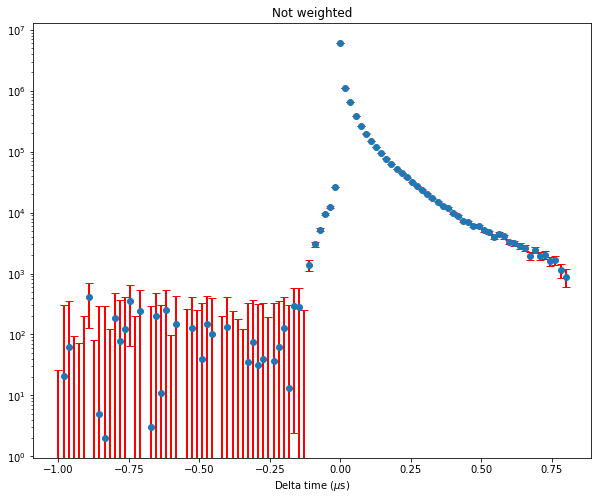

In [162]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [0,30],lower_cut=-1,higher_cut=0.8,bins = 100,weight = False)

### Double filtration: First cut in oriented pmts, then susbtract the common background

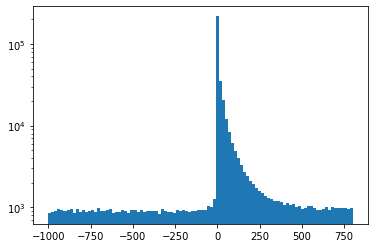

In [163]:
df_FINAL_merged_subset = df_FINAL_merged['delta_t'][(df_FINAL_merged['cuts'] == 1) & (df_FINAL_merged['is_on_plane'] == 1 )]
df_FINAL_merged_subset_a = df_FINAL_merged['hit_amplitude'][(df_FINAL_merged['cuts'] == 1) & (df_FINAL_merged['is_on_plane'] == 1 )]
df = pd.DataFrame()
df["delta_t"] = df_FINAL_merged_subset
df["hit_amplitude"] = df_FINAL_merged_subset_a
counts = histo_cut_big(df,lower_cut=-1,higher_cut=0.8, bins = 100, weight = False)

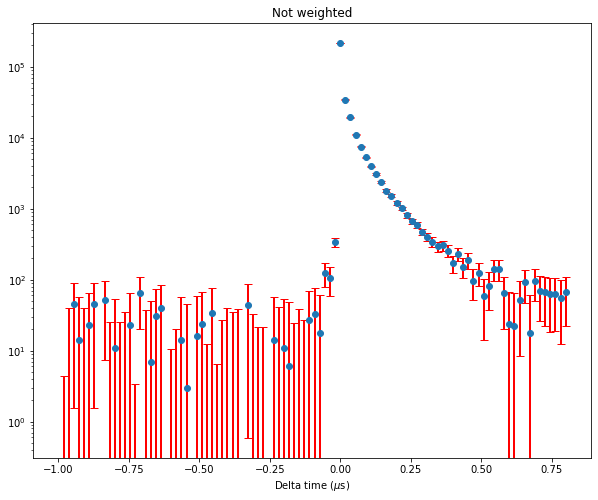

In [164]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [0,30],lower_cut=-1,higher_cut=0.8,bins = 100,weight = False)

In [3]:
def R_dom(pos_stop_bis, dom_positions_bis, r_dom, dict_id):
    """Returns boolean list for cut based on distance from stop position to closest dom"""

    #Compute cuts_R_dom and dom_info (Distance, dom id)
    cuts_R_dom = []
    dom_info = []
    
    #progress bar for user to see
    pbar = ProgressBar()

    for event in pbar(pos_stop_bis):  #loop over all events
        distance_to_dom = []    #list of distances to each dom
    
        #Store distances from stop point to each dom
        for dom in dom_positions_bis:  
            r = ((dom[0]-event[0])**2+(dom[1]-event[1])**2+(dom[2]-event[2])**2)**0.5  
            distance_to_dom.append(r)   
    
        #append true or false in cuts_R_dom list, based on minimum distance to dom
        if min(distance_to_dom) <= r_dom: 
            cuts_R_dom.append(True)
        else:
            cuts_R_dom.append(False)

        #Append false in dom_info if distance higher than R_dom for all cases
        if min(distance_to_dom) > r_dom:
            dom_info.append(False)
    
        #Store info of dom id and distances
        else:
            distances = []
            ids = []
            for i, distance in enumerate(distance_to_dom):  #loop over distances
                if distance <= r_dom:
                    distances.append(distance)
                    ids.append(dict_id[i])     

            dom_info.append([ids,distances])
        
    return cuts_R_dom, dom_info


In [4]:
def GUILLON_Cuts_R(file,E=2,lik=200,dir_z=None,r_dom=5):
    """Returns dataframe for a km3net root file, cutting events based on E, lik, dir_z, Volume.
    Default values: E=2.GeV, lik=200, dir_z=All,Volume=All initial volume, """
    
    
    #Read file using kio
    f = kio.OfflineReader(file)
    print("----------------------------------------------------------------------------")
    print("File readed...")
    
    #total number of events
    total_events = len(f.events)
    
    print("Filtering based on E and lik...")
    #array of booleans, true if n_tracks >= 1
    haveTrk = np.array(f.events.n_tracks, dtype=bool)
    
    #array of booleans for E and lik filters + haveTrk
    cuts_1 = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik))
    print("Filtration completed, filtering in dir_z...")
    
    #filter for z_direction, if not specified, just an array of True values
    if dir_z:
        cuts_z = np.array(f.events.tracks.dir_z[haveTrk][:,0] <= dir_z)
    else:
        cuts_z = np.broadcast_to(True,(1,total_events))
        
        
    #cuts of E, lik, z boolean array
    cuts_2 = cuts_1 & cuts_z
    
    print("Filtration complted, calculating stop positions...")
    
    
    #Call Stops function to compute stop postions based on cuts_2, as well as start positions and tracklenght
    pos_stop, pos_stop_bis, pos_start, trackLength = Stops(file,cuts_2,haveTrk)
    
    print("Stop postions calculated")
    print("Computing Volume information...")
    
    
    print("Computing R_dom information...")
    #Call DOM function to compute dom_positions_bis array and dict_id array
    dom_positions_bis, dict_id, dict_index = DOM()
    #Call R_dom function to compute cuts_R_dom and dom_positions_bis arrays
    cuts_R_dom, dom_info = R_dom(pos_stop_bis, dom_positions_bis, r_dom, dict_id)
    
    #Perform final cut, using cuts_2 and r_dom
    filtered_events = f.events[haveTrk][cuts_2][cuts_R_dom]
    
    print("Filtration finished")
    
    #Calculate track lenght
    print("Calculating track lenghts...")
    pos_start_f, trackLength_f = geoinfo(f,haveTrk,cuts_2,cuts_R_dom, cuts_length = 0, complete = False)
    
     
    #filter based on tracklength longitude
    print("Filtering the track length ...")
    min_track, max_track = 70, 160
    cuts_length = []
    for track in trackLength_f:
        if (track >= min_track) & (track <= max_track):
            cuts_length.append(True)
        else:
            cuts_length.append(False)
            
    print("Filtration finished")
    
    
    #Calculate again final postions for the data, based on the two cuts, in order to have a proper dataframe, and don't loose
    #track of events id... (Due to the fact of the double filtration, step needed for solving computing problems)
    
    print("Recalculating stop postions")
    pos_start_f, trackLength_f, pos_stop_f = geoinfo(f,haveTrk,cuts_2,cuts_R_dom, cuts_length = cuts_length, complete = True)
     
    #Select only good events after all filters
    filtered_events = f.events[haveTrk][cuts_2][cuts_R_dom][cuts_length]
    
    #Calculate % of filtered events
    filtered_events_n = len(filtered_events)
    print(len(filtered_events), " events selected, from a total of ", total_events)
    print(str("{:.2f}".format((total_events-filtered_events_n)*100/total_events))+"% of events filtered")
    
    #Exception in case any event is selected
    if filtered_events_n == 0:
        print("Filtration finished, any event selected")
        print("----------------------------------------------------------------------------")
    
    else:
        #Create the dataframe, including also id!!!
        print("Dataframe with all desired variables for the filtered events created")
        print("----------------------------------------------------------------------------")


        #DataFrame all list
        data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.n_hits,filtered_events.hits.id,filtered_events.hits.a,filtered_events.hits.channel_id,filtered_events.hits.dom_id,filtered_events.hits.channel_id,filtered_events.hits.t,filtered_events.hits.tdc,filtered_events.hits.pos_x,filtered_events.hits.pos_y,filtered_events.hits.pos_z,filtered_events.hits.dir_x,filtered_events.hits.dir_y,filtered_events.hits.dir_z,filtered_events.hits.tot,filtered_events.hits.trig,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start_f[0],pos_start_f[1],pos_start_f[2],trackLength_f,pos_stop_f[0],pos_stop_f[1],pos_stop_f[2]))
        df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','frame_index','trigger_counter','n_hits','hits_id','hits_amplitude','hits_channel_id','hits_dom_id','hits_pmt_id','hits_t','hits_tdc','hits_pos_x','hits_pos_y','hits_pos_z','hits_dir_x','hits_dir_y','hits_dir_z','hits_tot','hits_trig','t_sec','t_ns','t_track','E_Gev',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","trackLength","stop_x","stop_y","stop_z"])


        return df_cuts
    


## Filtration applied

In [5]:
file1 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008801.root"
file2 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008802.root"
file3 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008803.root"
file4 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008804.root"
file5 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008960.root"
file6 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008961.root"
file7 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008962.root"
file8 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00008963.root"
file9 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009571.root"
file10 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009572.root"
file11 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009573.root"
file12 = "/public/guillon/km3netdata_internship/data/datav6.0.jorcarec.aanet.00009574.root"

E = 2.
lik = 200

df_00008801 = GUILLON_Cuts_R(file1,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008802 = GUILLON_Cuts_R(file2,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008803 = GUILLON_Cuts_R(file3,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008804 = GUILLON_Cuts_R(file4,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008960 = GUILLON_Cuts_R(file5,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008961 = GUILLON_Cuts_R(file6,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008962 = GUILLON_Cuts_R(file7,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00008963 = GUILLON_Cuts_R(file8,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00009571 = GUILLON_Cuts_R(file9,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00009572 = GUILLON_Cuts_R(file10,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00009573 = GUILLON_Cuts_R(file11,E=2,lik=200,dir_z=-0.96,r_dom=5)
print("\n")
df_00009574 = GUILLON_Cuts_R(file12,E=2,lik=200,dir_z=-0.96,r_dom=5)


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
23  events selected, from a total of  28503
99.92% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
156  events selected, from a total of  171187
99.91% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
131  events selected, from a total of  182611
99.93% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
151  events selected, from a total of  183693
99.92% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
142  events selected, from a total of  179857
99.92% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
151  events selected, from a total of  179022
99.92% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
129  events selected, from a total of  178642
99.93% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
121  events selected, from a total of  178251
99.93% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
123  events selected, from a total of  142543
99.91% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
146  events selected, from a total of  175726
99.92% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
169  events selected, from a total of  175457
99.90% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


----------------------------------------------------------------------------
File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...


Stop postions calculated
Computing Volume information...
Computing R_dom information...
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


100% |########################################################################|


Filtration finished
Calculating track lenghts...
Filtering the track length ...
Filtration finished
Recalculating stop postions
153  events selected, from a total of  175028
99.91% of events filtered
Dataframe with all desired variables for the filtered events created
----------------------------------------------------------------------------


### Merging all dataframes together, and storing the dataframe

In [6]:
frames = [df_00008802,df_00008803,df_00008804,df_00008960,df_00008961,df_00008962,df_00008963,df_00009571,df_00009572,df_00009573,df_00009574]
df_complete_R = pd.concat(frames)
print("Shape: ", df_complete_R.shape)
print("Size: ", df_complete_R.size)

Shape:  (1572, 35)
Size:  55020


In [9]:
close_dom = closest_dom(df_complete_R)
df_complete_R["closest_dom"] = close_dom
df_complete_R.to_pickle('dataframes_volumecut/df_complete_R.pkl')

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


## Load the data

In [10]:
df_complete_R = pd.read_pickle("dataframes_volumecut/df_complete_R.pkl")
df_complete_R.head()

id  run_id  frame_index  trigger_counter  n_hits  \
0   533    8802          805               47     199   
1   754    8802         1116               60     171   
2  1046    8802         1478              115     239   
3  1184    8802         1650              126     263   
4  2113    8802         2793              202     177   

                                             hits_id  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      hits_amplitude  \
0  [1.5223372950739724, 1.0097999406851943, 1.522...   
1  [1.2389603160123224, 0.9138790663496179, 0.480...   
2  [0.3838016160279999, 1.5223372950739724, 0.913...   
3  [0.5706070529122399, 1.6695302894673176, 0.624...   
4  [0.9138790663496179, 0.7524857728641442, 2.859...   

                                     hits_channel_id  \
0  [14, 29, 29, 30, 8, 0, 2, 3, 24, 3, 13, 18, 26...   
1  [12, 28, 23, 28, 28, 29, 25, 2, 10, 5, 19, 5, ...   
2  [4, 6, 30, 4, 27, 30, 0, 2, 3, 7, 17, 0, 30, 1...   
3  [21, 24, 28, 30, 3, 5, 22, 30, 13, 16, 29, 11,...   
4  [0, 8, 19, 23, 30, 27, 11, 25, 25, 4, 26, 4, 5...   

                                         hits_dom_id  \
0  [806451572, 806465101, 806465101, 806465101, 8...   
1  [806451572, 806451572, 806469630, 806472265, 8...   
2  [806451572, 806451572, 806451572, 806465101, 8...   
3  [806451572, 806451572, 806451572, 806451572, 8...   
4  [806451572, 806469630, 806469630, 806472265, 8...   

                                         hits_pmt_id  ...     dir_y     dir_z  \
0  [14, 29, 29, 30, 8, 0, 2, 3, 24, 3, 13, 18, 26...  ... -0.157263 -0.983211   
1  [12, 28, 23, 28, 28, 29, 25, 2, 10, 5, 19, 5, ...  ... -0.067385 -0.973800   
2  [4, 6, 30, 4, 27, 30, 0, 2, 3, 7, 17, 0, 30, 1...  ... -0.079560 -0.985375   
3  [21, 24, 28, 30, 3, 5, 22, 30, 13, 16, 29, 11,...  ... -0.074699 -0.976967   
4  [0, 8, 19, 23, 30, 27, 11, 25, 25, 4, 26, 4, 5...  ... -0.229236 -0.973349   

      start_x     start_y     start_z trackLength      stop_x      stop_y  \
0  462.388606  608.762152  186.518135  153.768246  476.618910  584.580155   
1  517.945057  573.548404  184.587875  154.091871  484.477683  563.164991   
2  498.313486  598.861779  187.696224  155.305465  474.910936  586.505686   
3  511.961969  577.433218  168.918861  137.849787  484.407039  567.135919   
4  481.909482  601.608486  179.960763  149.769766  482.895737  567.275872   

      stop_z closest_dom  
0  35.331486   808451916  
1  34.533137   808987107  
2  34.662126   808451916  
3  34.244234   808987107  
4  34.182569   808987107  

[5 rows x 36 columns]

In [11]:
print("Shape: ", df_complete_R.shape)
print("Size: ", df_complete_R.size)

Shape:  (1572, 36)
Size:  56592


## Some plots 

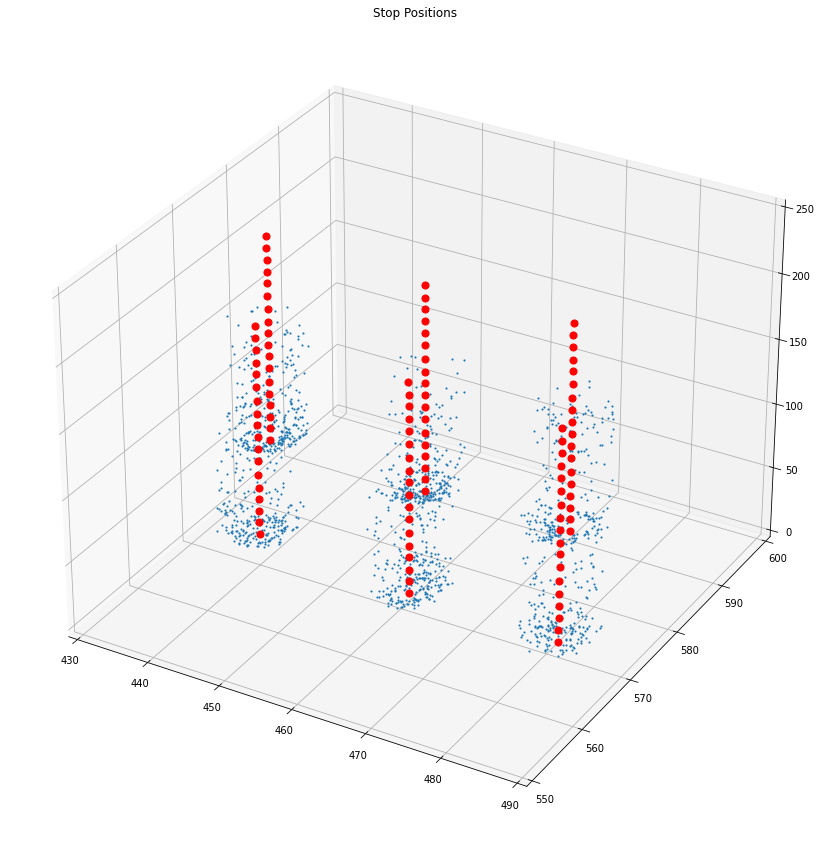

In [12]:
plot3D(df_complete_R,dom_positions)

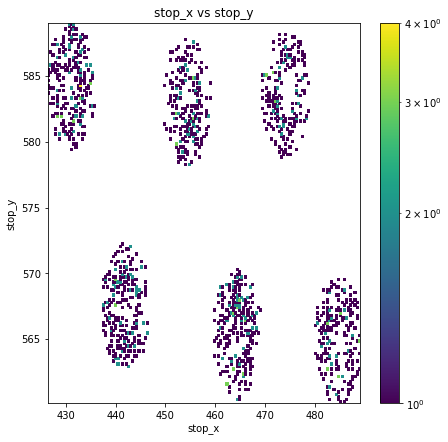

In [13]:
plot2var(df_complete_R,"stop_x","stop_y")

## Last filtration of hits, based on pmt orientation or in backgorund substraction

In [14]:
#Load DET document and compute interseting info
det = kp.hardware.Detector('/home/stefanescu/internship/muonstopwork/KM3NeT_00000049_20200625.detx')
pmt_angles = det.pmt_angles
dom_positions_bis, dict_id, dict_index = DOM()

#Divide DOMS in the 6 columns
DU = DetectorUnits()

### Dividing the DOMS in 18 z-planes:
DU_plane_z = DetectorUnits_plane_z()


#Compute dictionaries of booleans depending on each plane and each DU, and z_means of each plane
z_means = compt_mean_z()
DUS_Ext = Extra_Plane()
DUS_Inf = Inf_plane()
DUS_Sup = SUP_plane()

#Compute ratio of active-non-active pmts at each plane
ratio_ext,ratio_sup_inf = pmt_ratios()

#Compute dictionary with booleans of inside-outside in all pmts of all doms
DUS_TOTAL = pmt_inside_outside()

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


### Vanila show for the df_complete of the pmt filter implementation and bckg substraction filtration

##### Perform the cuts ont he whole dataframe and store results in new dataframe

In [25]:
df_complete_R = pd.read_pickle("dataframes_volumecut/df_complete_R.pkl")

times = np.array([])
amplitudes = np.array([])
dom_ids = np.array([])
pmt_ids = np.array([])
track_ids = np.array([])
cloest_dom_id = np.array([])

for event in range(len(df_complete_R)):
    
    calib_hits, track = track_hit_preparation(event,df_complete_R)
    result = cherenkov(calib_hits, track)
    time_to_plot = df_complete_R.iloc[event]["hits_t"]-result['t_photon']
    
    times = np.concatenate((times,time_to_plot))
    

    amplitude_event = df_complete_R.iloc[event]["hits_amplitude"]
    amplitudes = np.concatenate((amplitudes,amplitude_event))
    
    dom_id = df_complete_R.iloc[event]["hits_dom_id"]
    dom_ids = np.concatenate((dom_ids,dom_id))
    pmt_id = df_complete_R.iloc[event]["hits_channel_id"]
    pmt_ids = np.concatenate((pmt_ids,pmt_id))
    
    n_hits = len(pmt_id)
    
    tracks = np.zeros(n_hits)
    track_id = df_complete_R.iloc[event]["id"]
    tracks += track_id
    track_ids = np.concatenate((track_ids,tracks))
    
    doms = np.zeros(n_hits)
    closest_dom = df_complete_R.iloc[event]["closest_dom"]
    doms += closest_dom
    cloest_dom_id = np.concatenate((cloest_dom_id,doms))
    

    
df_test = pd.DataFrame()
df_test["delta_t"] = times
df_test["hit_amplitude"] = amplitudes
df_test["dom_id"] = dom_ids
df_test["pmt_id"] = pmt_ids
df_test["track_id"] = track_ids
df_test["cloest_dom_id"] = cloest_dom_id


df_test.to_pickle('dataframes_volumecut/df_complete_merged_R.pkl')

##### Load data

In [26]:
df_complete_merged_R = pd.read_pickle('dataframes_volumecut/df_complete_merged_R.pkl')
df_complete_merged_R.head()

delta_t  hit_amplitude       dom_id  pmt_id  track_id  cloest_dom_id
0   140.482153       1.522337  806451572.0    14.0     533.0    808451916.0
1    40.261123       1.009800  806465101.0    29.0     533.0    808451916.0
2   119.931123       1.522337  806465101.0    29.0     533.0    808451916.0
3     7.934731       1.009800  806465101.0    30.0     533.0    808451916.0
4  1289.438853       0.480277  806472265.0     8.0     533.0    808451916.0

In [38]:
df_complete_merged_R.shape

(332895, 6)

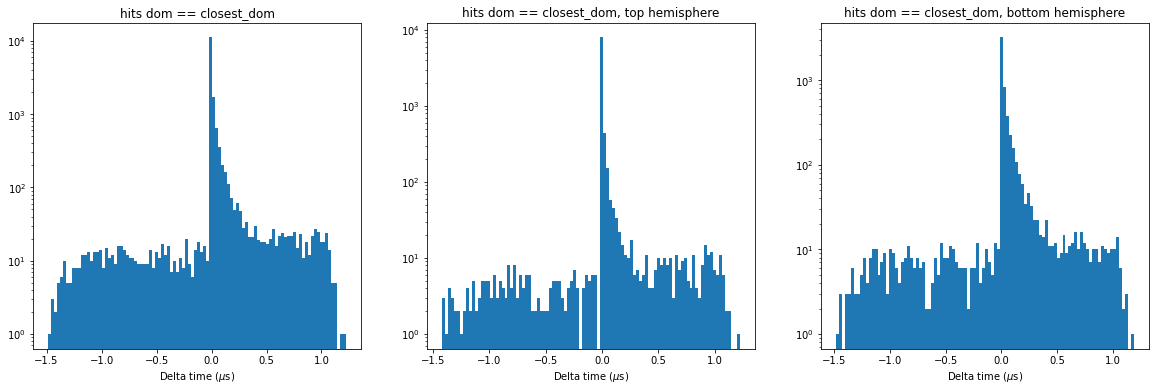

In [40]:
fig, axe = plt.subplots(figsize=(20,6))

plt.subplot(131)

time_dom = df_complete_merged_R['delta_t'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id'])]
pmts = df_complete_merged_R['pmt_id'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id'])]
df_trial = pd.DataFrame()
df_trial["delta_t"] = time_dom
df_trial["pmt"] = pmts
plot_time_flight_cuts(df_trial,weighted=False,log=True,bins=100, title = "hits dom == closest_dom")

plt.subplot(132)

time_dom = df_complete_merged_R['delta_t'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id']) & (df_complete_merged_R['pmt_id'] < 11)]
pmts = df_complete_merged_R['pmt_id'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id']) & (df_complete_merged_R['pmt_id'] < 11)]
df_trial = pd.DataFrame()
df_trial["delta_t"] = time_dom
df_trial["pmt"] = pmts
plot_time_flight_cuts(df_trial,weighted=False,log=True,bins=100, title = "hits dom == closest_dom, top hemisphere")

plt.subplot(133)

time_dom = df_complete_merged_R['delta_t'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id']) & (df_complete_merged_R['pmt_id'] > 11)]
pmts = df_complete_merged_R['pmt_id'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id']) & (df_complete_merged_R['pmt_id'] > 11)]
df_trial = pd.DataFrame()
df_trial["delta_t"] = time_dom
df_trial["pmt"] = pmts
plot_time_flight_cuts(df_trial,weighted=False,log=True,bins=100, title = "hits dom == closest_dom, bottom hemisphere")

plt.show()

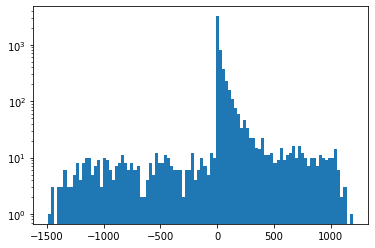

In [89]:
time_dom = df_complete_merged_R['delta_t'][(df_complete_merged_R['dom_id'] == df_complete_merged_R['cloest_dom_id']) & (df_complete_merged_R['pmt_id'] > 11)]
counts,edges,plot = plt.hist(time_dom,bins = 100)
plt.yscale("log")

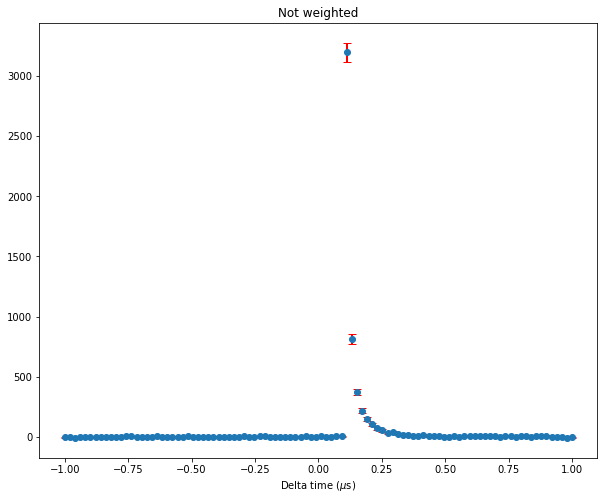

In [54]:
counts_new, uncertainty = bckg_substraction(counts,bins_bckg = [5,25],lower_cut=-1,higher_cut=1,bins = 100,log = False,weight = False)

[  7.60609047 -25.30484479]


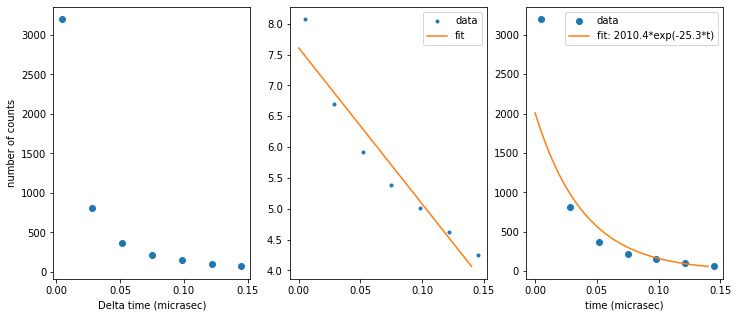

In [64]:
plt.figure(figsize=(12,5))


bin_time = 0.02 #micrasec
x = np.linspace(0,7,7)*bin_time+0.005
y = counts_new[55:62]
plt.subplot(131)
plt.plot(x,y,"o")
plt.xlabel("Delta time (micrasec)")
plt.ylabel("number of counts")


lny = np.log(y)
plt.subplot(132)
plt.plot(x,lny,".",label = "data")

X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x
beta = np.linalg.inv(X.T @ X) @ X.T @ lny
print(beta)

xx = np.linspace(0,7,50)*bin_time
yy = beta[0]+beta[1]*xx

plt.plot(xx,yy,label= "fit")
plt.legend()

y0 = np.exp(beta[0])*np.exp(beta[1]*xx)
plt.subplot(133)

limited_float = round(np.exp(beta[0]), 2)
limited_float1 = round(beta[1], 2)
plt.plot(x,y,"o",label = "data")
plt.plot(xx,y0,label = f"fit: {limited_float}*exp({limited_float1}*t)")
plt.xlabel("time (micrasec)")
plt.legend()
plt.show()

[  7.19060416 -17.45568991]


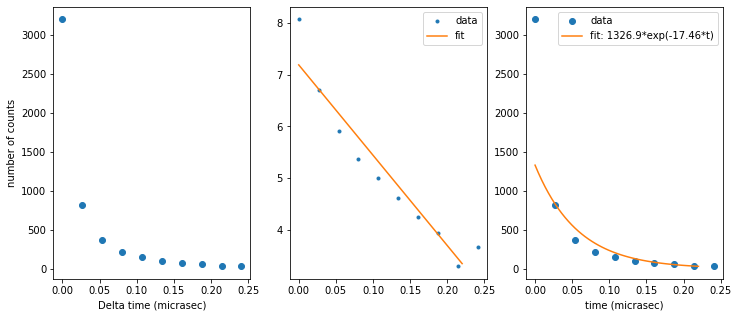

In [93]:
n_bins = 10
time_per_bin = (edges[-1]-edges[0])/100/1000
final = time_per_bin*n_bins
x = np.zeros(n_bins)

for m, n in enumerate(x):
    x[m] = time_per_bin*m

plt.figure(figsize=(12,5))


bin_time = 0.02 #micrasec

y = counts_new[55:65]
plt.subplot(131)
plt.plot(x,y,"o")
plt.xlabel("Delta time (micrasec)")
plt.ylabel("number of counts")


lny = np.log(y)
plt.subplot(132)
plt.plot(x,lny,".",label = "data")

X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x
beta = np.linalg.inv(X.T @ X) @ X.T @ lny
print(beta)

xx = np.linspace(0,11,50)*bin_time
yy = beta[0]+beta[1]*xx

plt.plot(xx,yy,label= "fit")
plt.legend()

y0 = np.exp(beta[0])*np.exp(beta[1]*xx)
plt.subplot(133)

limited_float = round(np.exp(beta[0]), 2)
limited_float1 = round(beta[1], 2)
plt.plot(x,y,"o",label = "data")
plt.plot(xx,y0,label = f"fit: {limited_float}*exp({limited_float1}*t)")
plt.xlabel("time (micrasec)")
plt.legend()
plt.show()
    